<a href="https://colab.research.google.com/github/koki27345/R-D-kennsyuu/blob/main/tutorial_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 画像分類実践

(colab) ページ上部の ランタイム → ランタイムのタイプを変更 → ハードウェアアクセラレータを「GPU」に変更 → 保存  
深層学習では、簡単な計算を大量に行い学習を進めます。こういった計算にはGPUが適しています。

[参考資料](https://aiacademy.jp/texts/show/?id=164)


### パッケージの準備

In [44]:
# 必要なパッケージをインストール
# !から始まる行はshell command (Pythonではない)
!pip install icrawler

%matplotlib inline
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### webから画像をかき集める：クローリング

今回は猫・犬の画像分類器を作成します。猫と犬の画像が必要なので、webからかき集めてきます。収集した画像はランタイムのディスク領域に保存されるため、ランタイムのセッションを閉じると削除されます。

*クローリングの結果は毎回変わるため、この方法では再現性は得られません

In [45]:
from icrawler.builtin import BingImageCrawler
import logging

n_img_1 = 200
n_img_2 = 150
class1_name = "cat"
class1_keyword = "汚い机"
class2_name = "dog"
class2_keyword = "きれいな机"

# 猫の画像を取得
crawler = BingImageCrawler(storage={"root_dir": class1_name}, log_level=logging.INFO, parser_threads=2, downloader_threads=4,)
crawler.crawl(keyword=class1_keyword, max_num=n_img_1)  # 検索キーワードはひらがなの方がちゃんと動物が出る可能性が高い気がする

# 犬の画像を取得
crawler = BingImageCrawler(storage={"root_dir": class2_name}, log_level=logging.INFO, parser_threads=2, downloader_threads=4,)
crawler.crawl(keyword=class2_keyword, max_num=n_img_2)

# ダウンロード用のzipファイル生成
!zip -r $class1_name $class1_name
!zip -r $class2_name $class2_name

updating: cat/ (stored 0%)
updating: cat/000029.jpg (deflated 1%)
updating: cat/000108.jpg (deflated 0%)
updating: cat/000020.jpg (deflated 3%)
updating: cat/000046.jpg (deflated 3%)
updating: cat/000100.jpg (deflated 1%)
updating: cat/000079.jpg (deflated 0%)
updating: cat/000030.jpg (deflated 0%)
updating: cat/000097.jpg (deflated 1%)
updating: cat/000002.jpg (deflated 1%)
updating: cat/000012.jpg (deflated 0%)
updating: cat/000085.jpg (deflated 0%)
updating: cat/000009.jpg (deflated 0%)
updating: cat/000052.jpg (deflated 0%)
updating: cat/000043.jpg (deflated 0%)
updating: cat/000034.jpg (deflated 0%)
updating: cat/000004.jpg (deflated 0%)
updating: cat/000066.jpg (deflated 0%)
updating: cat/000038.jpg (deflated 0%)
updating: cat/000059.jpg (deflated 1%)
updating: cat/000023.jpg (deflated 0%)
updating: cat/000068.jpg (deflated 0%)
updating: cat/000082.jpg (deflated 1%)
updating: cat/000050.jpg (deflated 1%)
updating: cat/000102.jpg (deflated 1%)
updating: cat/000065.jpg (deflated 0%

### 収集した画像の読み込み

画像をopencv (`cv2`) というモジュールで読み込みます。画像は`numpy`の`np.ndarray`という配列オブジェクトとして読み込まれます。  
`ndarray`で気にかけておくべきことは次の3つです。
- 配列の次元 = ランク (`ndarray.ndim`)
- 配列の形 (`ndarray.shape`)
- 配列のデータ型 (`ndarray.dtype`)  

一方で中身の個々の値に関しては、大きい配列ですと確認が難しいため、最大値や平均値など配列全体としての情報から期待している数値が入っているか推測することになります。

<img src="https://qph.fs.quoracdn.net/main-qimg-30be20ab9458b5865b526d287b4fef9a" width="500" >

低次元の配列には名前がついています。
- 0次元: スカラー
- 1次元: ベクトル
- 2次元: マトリックス

これらを一般化した概念をテンソルと呼びます。

In [46]:
# ダウンロードした画像を全て同じ大きさにリサイズし、メモリに格納
import numpy as np
import cv2
from pathlib import Path  # ディスク上のファイル一覧を取得するなど、パスの操作に用いるモジュール

img_size = 64
imgs_cat = list()
imgs_dog = list()

for img_list, img_dir in ((imgs_cat, class1_name), (imgs_dog, class2_name)):
  # 画像パス一つずつを処理
  for impath in Path(img_dir).iterdir():
    # 画像読み込み: cv2.imread()
    img = cv2.imread(str(impath))
    if img is None: continue
    # 画像リサイズ
    img = cv2.resize(img, (img_size, img_size))
    img_list.append(img)

# listをndarrayに変換
imgs_cat = np.array(imgs_cat)
imgs_dog = np.array(imgs_dog)

# テンソルの情報を確認
print('imgs_cat.ndim =', imgs_cat.ndim)
print('imgs_cat.shape =', imgs_cat.shape)
print('imgs_cat.dtype =', imgs_cat.dtype)
print('')
print('imgs_dog.ndim =', imgs_dog.ndim)
print('imgs_dog.shape =', imgs_dog.shape)
print('imgs_dog.dtype =', imgs_dog.dtype)

imgs_cat.ndim = 4
imgs_cat.shape = (141, 64, 64, 3)
imgs_cat.dtype = uint8

imgs_dog.ndim = 4
imgs_dog.shape = (120, 64, 64, 3)
imgs_dog.dtype = uint8


`cv2.imread()`関数で読み込んだ画像のデータ型は、デフォルトでは`np.uint8`という、符号なし（=マイナスを表現できない）8 bitの整数です。[0, 255]の範囲のみ表現可能です。  
`imgs_cat`は4次元配列で形が(n, 64, 64, 3)になっています。これは、最初の軸 (`axis = 0`) には画像の枚数nが、続く3つの次元には64 x 64 pixelの3チャネル (RGB) 画像が格納されているという意味になっています。  
(`cv2.imread()`で読み込んだ画像は、厳密にはチャネルの並びがBGRの順番になっています。)

### 収集した画像の確認

読み込んだ画像をタイル状に並べて確認します

In [47]:
# 画像の一覧可視化関数
import math
import PIL

def tile_show(imgs, n_col=10):
  h, w = imgs[0].shape[:2]
  assert all([img.shape[:2] == (h, w) for img in imgs])
  n_row = math.ceil(len(imgs) / n_col)
  tile = np.zeros((h*n_row, w*n_col, 3), imgs[0].dtype)
  for i, img in enumerate(imgs):
    row = i // n_col
    col = i % n_col
    y1 = row * h
    y2 = (row+1) * h
    x1 = col * w
    x2 = (col+1) * w
    tile[y1:y2, x1:x2] = img
  
  if not tile.dtype == np.uint8:
    tile -= tile.min()
    tile /= tile.max()
    tile *= 255
    tile = np.clip(tile.astype(np.uint8), 0, 255)
  return PIL.Image.fromarray(tile[..., ::-1])

141


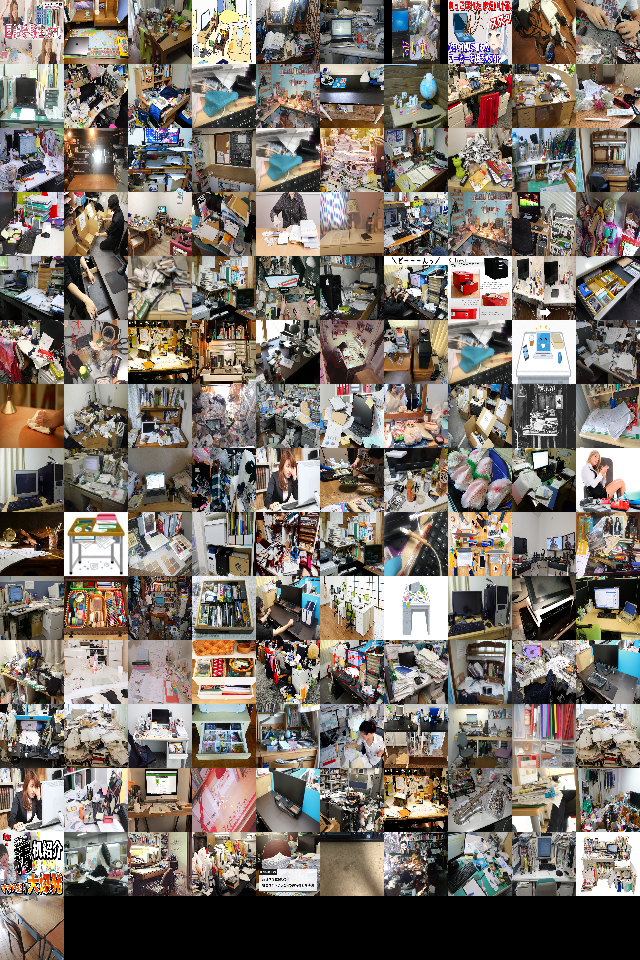

In [48]:
print(len(imgs_cat))
tile_show(imgs_cat)

120


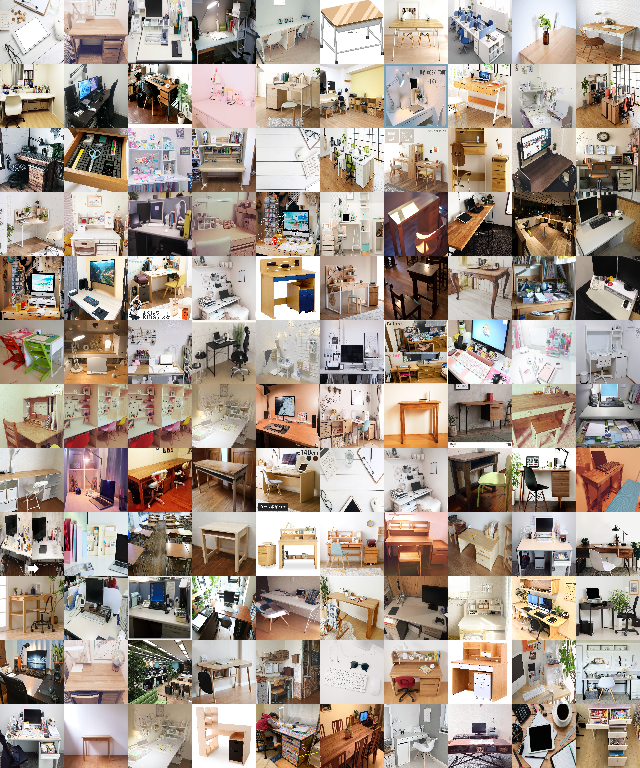

In [49]:
print(len(imgs_dog))
tile_show(imgs_dog)

### 学習データ・テストデータの作成

収集した画像を学習用とテスト用（精度評価用）に分け、ラベル（正解）を付与する（猫=0、犬=1）。  
今回は **二値分類** なので、変数1つに猫か犬かという意味を持たせることができる（変数が0に近ければ猫である確率が高く、1に近ければ犬である確率が高い）。


3クラス以上の分類 **多クラス分類** では、カテゴリの変数をone-hot encodingという手法でベクトルに変換してから用いることが一般的である。なお、二値分類でもone-hot表現は可能で、こちらの方がいい精度が出る（気がする）ので今回はこちらを使う。

<img src="https://smart-hint.com/wp-content/uploads/2021/11/image-47.png" width="500"><a href="https://smart-hint.com/python/dummies/">src</a>


また、画像処理では、入力画像を少数で[-1, 1]の範囲に正規化して用いることが多い。すなわち、`np.uint8`[0, 255]を`np.float32`[-1, 1]に変換する。

入力の画像とラベルは、次に作成するモデルの入出力とマッチするように作成する。

(209,)
(209, 2)


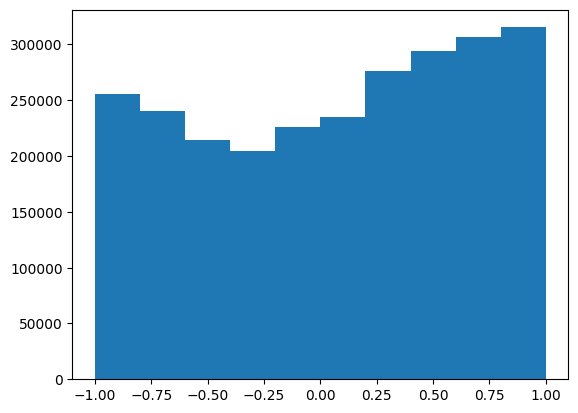

In [50]:
import tensorflow as tf

# 学習データとテストデータの作成
test_rate = 0.2
n_cat_test = int(len(imgs_cat) * test_rate)
n_dog_test = int(len(imgs_dog) * test_rate)

cat_test, cat_train = imgs_cat[:n_cat_test], imgs_cat[n_cat_test:]
dog_test, dog_train = imgs_dog[:n_dog_test], imgs_dog[n_dog_test:]

# ndarrayの結合, dtypeをfloat32に変更, [-1,1]に正規化
train_X = np.concatenate([cat_train, dog_train], axis=0)
train_X = train_X.astype(np.float32)
train_X = ((train_X / 255.) - 0.5) * 2
test_X = np.concatenate([cat_test, dog_test], axis=0)
test_X = test_X.astype(np.float32)
test_X = ((test_X / 255.) - 0.5) * 2

# 正規化の確認。train_Xに含まれる全画素の輝度のヒストグラム
plt.hist(train_X.flatten())

# ラベルを作成。猫=0、犬=1として設定
train_y = np.array([0.] * len(cat_train) + [1.] * len(dog_train)).astype(np.float32)
test_y = np.array([0.] * len(cat_test) + [1.] * len(dog_test)).astype(np.float32)
print(train_y.shape)

# one-hot encoding
train_y = tf.keras.utils.to_categorical(train_y, 2)
test_y = tf.keras.utils.to_categorical(test_y, 2)
print(train_y.shape)

### モデルの作成

今回はVGG16という畳み込みニューラルネットワークを用います。  
有名なモデルはtensorflwoフレームワークに組み込まれており、呼び出すだけでモデルが使用できます。

In [51]:
from tensorflow.keras.applications import VGG16

model = VGG16(
    include_top=True, 
    weights=None, 
    input_shape=(img_size, img_size, 3), 
    classes=2,
    )
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

  `tf.keras.Model.summary()`メソッドでは、モデルの各レイヤーのテンソルの形が表示されます (`None`は数値が任意であることを示す) 。モデルを1つの大きな関数として考えた時、重要なのは入力と出力です。  
- input:  `input_5 (InputLayer)        [(None, 64, 64, 3)]`  
- output:   `predictions (Dense)         (None, 2)`

このモデルは、「4次元テンソルを入力されると2次元テンソルを出力する関数」と言えます。


In [52]:
print(train_X.shape)
print(train_y.shape)

(209, 64, 64, 3)
(209, 2)


学習データ画像`train_X`とinputのshape、正解ラベル`train_y`のとoutputのshapeが一致していることが確認できます。

#### ニューラルネットワーク

<img src="https://www.esector.co.jp/bpa/img/A19-034.png" width="500">
<a href="https://www.esector.co.jp/bpa/A19-034.html">src</a>

ニューロンに対応する部分をノードなどと呼ぶ。たいてい1ノードだけで扱うことはなく、層のような構造に例えられるためレイヤーとも呼ばれる

<img src="https://www.imagazine.co.jp/wp-content/uploads/2018/07/086-090_16ISno13_kiso_deep_zu003.jpg" width="500">
<a href="https://www.imagazine.co.jp/%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E3%80%8C%E5%9F%BA%E7%A4%8E%E3%81%AE%E5%9F%BA%E7%A4%8E%E3%80%8D%E3%82%92%E7%90%86%E8%A7%A3%E3%81%99/">src</a>

畳み込みニューラルネットワーク（CNN）は、神経細胞の発火のルールを、画像の部分領域をベースにしたという点で、人間の視覚処理により近い構造を模していると考えることができる。

#### 畳み込み処理

<img src="https://axa.biopapyrus.jp/media/CNN_Conv3.png" width="500"><a href="https://axa.biopapyrus.jp/deep-learning/cnn/convolution.html">src</a>

中央の3x3の配列をfilter, kernel, windowなどと呼ぶ。畳み込みは特定のパターン（模様）を抽出する操作だと考えることもでき、フィルターの内容がパターンを決定する。CNNでは、フィルターの中身を学習によって更新し、学習がうまく進むと画像内の特徴量（猫らしさ、犬らしさの指標になる模様など）が抽出できるようになる。


<img src="https://i.stack.imgur.com/wrxLE.png" width="500"><a href="http://web.pdx.edu/~jduh/courses/Archive/geog481w07/Students/Ludwig_ImageConvolution.pdf">src</a>  
カーネルの違いによる畳み込み効果の例

### モデルの学習

In [53]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_X, train_y, epochs=30, batch_size=32)

Epoch 1/30
7/7 [==============================] - 13s 340ms/step - loss: 0.6929 - accuracy: 0.5407
Epoch 2/30
7/7 [==============================] - 0s 56ms/step - loss: 0.6912 - accuracy: 0.5407
Epoch 3/30
7/7 [==============================] - 0s 57ms/step - loss: 0.6893 - accuracy: 0.5407
Epoch 4/30
7/7 [==============================] - 0s 57ms/step - loss: 0.6852 - accuracy: 0.5407
Epoch 5/30
7/7 [==============================] - 0s 58ms/step - loss: 0.6814 - accuracy: 0.5407
Epoch 6/30
7/7 [==============================] - 0s 63ms/step - loss: 0.6759 - accuracy: 0.5407
Epoch 7/30
7/7 [==============================] - 0s 63ms/step - loss: 0.6714 - accuracy: 0.5407
Epoch 8/30
7/7 [==============================] - 0s 57ms/step - loss: 0.6638 - accuracy: 0.5407
Epoch 9/30
7/7 [==============================] - 0s 52ms/step - loss: 0.6580 - accuracy: 0.5407
Epoch 10/30
7/7 [==============================] - 0s 52ms/step - loss: 0.6545 - accuracy: 0.5407
Epoch 11/30
7/7 [==========

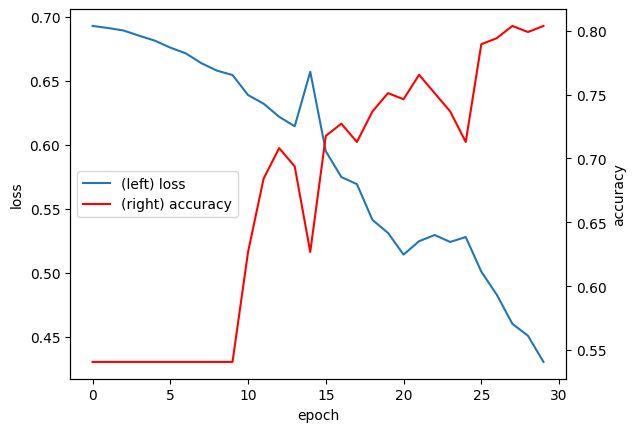

In [54]:
# 学習過程の可視化
fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='(left) loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='(right) accuracy', c='r')
ax2.set_ylabel('accuracy')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='center left')
plt.show()

### 学習したモデルのテスト

テストデータから1枚、画像を取り出して学習したモデルに適用してみる。  
outputは`tf.Tensor`という型であり、`tf.Tensor.numpy()`メソッドによりnumpyの数値として情報を取り出すことができる。

In [55]:
# [-1,1]に正規化されている画像を表示する関数
def show_standardized_img(img):
  img -= img.min()
  img /= img.max()
  img *= 255
  img = np.clip(img, 0, 255).astype(np.uint8)
  return PIL.Image.fromarray(img[..., ::-1])

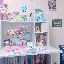

In [56]:
import random
ix = random.randint(0, len(test_X)-1)
show_standardized_img(test_X[ix])

In [57]:
output = model(test_X[ix][np.newaxis], training=False)
print(output)
print(output.numpy())

tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
[[0. 1.]]


`output`の`shape`は (1, 2) となっているが、これは実質的には長さ2のベクトルであり、「猫である確率」と「犬である確率」の順で格納されている。

In [58]:
vector = output.numpy()[0]
print('汚い机である確率:', f'{vector[0]:.3f}')
print('きれいな机である確率:', f'{vector[1]:.3f}')

汚い机である確率: 0.000
きれいな机である確率: 1.000


テスト画像の表示とモデルの出力を関数でひとまとめにし、何度か実行してモデルの性能の感覚をつかむ。

In [59]:
def sample_and_predict(model, X):
  ix = random.randint(0, len(X)-1)
  output = model(X[ix][np.newaxis], training=False)
  vector = output.numpy()[0]
  print('汚い机である確率:', f'{vector[0]:.3f}')
  print('きれいな机である確率:', f'{vector[1]:.3f}')
  return show_standardized_img(X[ix])

汚い机である確率: 0.690
きれいな机である確率: 0.310


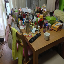

In [60]:
sample_and_predict(model, test_X)

### 精度評価

混合行列 (confusion matrix) を作成する。クラス分類の問題では、正解率や感度など、1つの数字で表現される指標がいくつか存在するが、指標それぞれが見える部分と見えない部分を持つ。

confusion matrixは全ての指標の元になる行列であるので、これさえ載せておけば漏れなく全体を把握することができる。  

今回は「猫と判定すること」を陽性 (positive) として考える。

<img src="https://www.naukri.com/learning/articles/wp-content/uploads/sites/11/2022/03/Confusion-matrix-1.png" width="500"><a href="https://www.naukri.com/learning/articles/web-stories/confusion-matrix-in-machine-learning/">src</a>

In [61]:
# confusion matrixの算出
true = np.argmax(test_y, axis=1)
test_y_hat = model.predict(test_X)
pred = np.argmax(test_y_hat, axis=1)

confmat = tf.math.confusion_matrix(true, pred).numpy()
confmat

2/2 [==============================] - 1s 536ms/step


array([[21,  7],
       [ 7, 17]], dtype=int32)

confusion matrixは包括的な情報ではあるものの、ぱっと見ではよくわからないので指標も計算する。  
ポイント：別名があったり日本語訳がしっくりこなかったりわかりにくい。覚えるというよりは意味合いを把握することが大事

<img src="https://cdn-ssl-devio-img.classmethod.jp/wp-content/uploads/2015/08/Untitled.png"><a href="https://dev.classmethod.jp/articles/aml-evaluation-measures/">src</a>

- 正解率 Accuracy  
$ \frac{TP + TN}{TP + FP + FN + TN} $

- 感度 Sensitivity (Recall, True Positive Rate 再現率 検出率 真陽性率)  
$ \frac{TP}{TP + FN} $  
疾病検査を例にすると、その検査が疾病をとらえる「感度・検出率」となる。(検査で病気と分かった人 / 実際に病気の人)  


- 特異度 Specificity (True Negative Rate 真陰性率)  
$ \frac{TN}{FP + TN} $  
検査で言えば、検査で陰性だった人 / 実際に陰性の人

- 陽性的中率 Positive Predictive Value (Precision 適合度 精度)  
$ \frac{TP}{TP + FP} $  
「陽性適中率が高い」とは、「検査結果が陽性と判定された場合に、真の陽性（有病者）である確率が高い」という意味。


他にも山ほどあります [wikipedia](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers)

In [62]:
[[TP, FP], 
 [FN, TN]] = confmat

accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (FP + TN)
precision = TP / (TP + FP)

print('正解率', accuracy)
print('感度', sensitivity)
print('特異度', specificity)
print('陽性的中率', precision)

正解率 0.7307692307692307
感度 0.75
特異度 0.7083333333333334
陽性的中率 0.75


### 学習モデルの実利用

学習モデルはデータセット外の実データに適用して初めて役立ちます。  
ここでは例として、画像URLを受け取ると猫か犬か判定してくれるwebサービスを想定します。

(実際のサービス例：[Google Lens](https://lens.google/intl/ja/#:~:text=%E6%A4%8D%E7%89%A9%E3%82%84%E5%8B%95%E7%89%A9,%E7%A2%BA%E8%AA%8D%E3%81%A7%E3%81%8D%E3%81%BE%E3%81%99%E3%80%82))

In [63]:
# urlから画像を読みこむcv2u.urlread()を使用するためパッケージをインストール
!pip install python-opencv-utils
import cv2u

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1/1 [==============================] - 0s 18ms/step
これは  80.6% 「汚い机」 です！


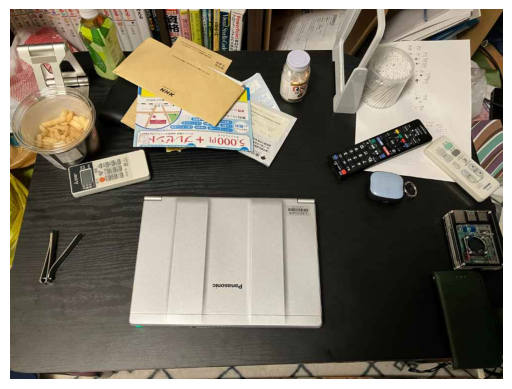

In [73]:
#@title 犬猫画像判定サービス { run: "auto", vertical-output: true }

labels = {0: '汚い机', 1: 'きれいな机'}

URL = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gHYSUNDX1BST0ZJTEUAAQEAAAHIAAAAAAQwAABtbnRyUkdCIFhZWiAAAAAAAAAAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAACRyWFlaAAABFAAAABRnWFlaAAABKAAAABRiWFlaAAABPAAAABR3dHB0AAABUAAAABRyVFJDAAABZAAAAChnVFJDAAABZAAAAChiVFJDAAABZAAAAChjcHJ0AAABjAAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAAgAAAAcAHMAUgBHAEJYWVogAAAAAAAAb6IAADj1AAADkFhZWiAAAAAAAABimQAAt4UAABjaWFlaIAAAAAAAACSgAAAPhAAAts9YWVogAAAAAAAA9tYAAQAAAADTLXBhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABtbHVjAAAAAAAAAAEAAAAMZW5VUwAAACAAAAAcAEcAbwBvAGcAbABlACAASQBuAGMALgAgADIAMAAxADb/2wBDABQODxIPDRQSEBIXFRQYHjIhHhwcHj0sLiQySUBMS0dARkVQWnNiUFVtVkVGZIhlbXd7gYKBTmCNl4x9lnN+gXz/2wBDARUXFx4aHjshITt8U0ZTfHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHz/wAARCALuA+gDASIAAhEBAxEB/8QAGwAAAgMBAQEAAAAAAAAAAAAAAAECAwQFBgf/xABKEAABBAAEAgcEBggEBQQCAwEBAAIDEQQSITFBUQUTImFxgZEUMlKhBiNCscHRFTNTYnKS4fAkNEOCVJOi0vFEY3OyFoMlNcLi/8QAGQEBAQEBAQEAAAAAAAAAAAAAAAECAwQF/8QAJhEBAQEBAAICAgIDAAMBAAAAAAERAiExAxJBUQQTIjJhcYGR8P/aAAwDAQACEQMRAD8A4bWPYezVk3muvULTILAcNVTnqg5rrHIKTZDlpsUh8RQXF2vlF8cfZNOp3AHRXEiVli+RHJV0/QdkXrThal1UhFdaGt5MCJ5RLm9Vke7LlOiiyVjLykvJ2DQU3Dq3AjXLv3qUkpsZKA+9XTPJyPa9rS7Mxw/dJUoX9XHlYx79b2oD1UYZ7dldVoxE7o3UJAzxFpjW+Mac7jE1ucRvu6zVY5Wr8JM9rHjEva1oPZLiAaWSJ4miDntafEaLTG2BtExNH+1NRoldF7OZ2Pc0DcsAObhqDor8HJE6ERxuJyAAg7qm8zfqnNA2LS2wU4o5IXOMbMO1ztzmKT64t2+EsZAZo6awEjc/aruTgdJIHMcHFgGjnNym+StjbMCXSua7kGjZZjKGyDLiWHtWSZBtyIKkherJmavYC+J0Qyhw2Lhaow8U0D2xtY/Lm7VkFtc/FWCeN01xODq3rZQnkidIXCSjVU4EV4JjXFvpqkjDxRrXu2KfRsznumjsGnWDVX5KluKjyNbmc91USGndXNkbDK2QtGujnIz+MbS6txqoEhXinC9HBRc0fAFpzZHm9AFllj1JdvyXQc08BXgFmmLIgS4gkcEHNLAyQBxDcwO5UwC6B7Mgc5moBNLn4vECSWzq3w3U8LinQS01wP7risbK3lnlqwrw09Q1wl452uv1V8X1eIIOzlhbN1kznAvE7tBbgNeA5ELfOxwa1xHaG9Kxe89xRKOpxXW3TI/sOk1dfHUrS852NflLe47qGMgOKiaWgEbkAdo+aeHEzmPErXBumXPWbv2VW+edaYXh8Y11GhWKON8OJMuWQxatstF3zoDZX4UZXvHxa13qrHQF0jZBH2QQSWNtxPf3JU4vnGo05tjYhLDuoubx3UYHvewmRpBsgEirHOuCPdnaeeirFmXHOxuFw0b5WySjPK2gTVtF2eNkroujHs4a1znDLQLjZKh0hA2eMdbnMABLmsA8iSTsEYGV0+Fa8lrmVTTlLSa5hVHAlY1s72Pawte0ttzi0A8Dp3rnYs2+KZtdpo+1Zsc12ek2mKfrG6EEOBpczHlrI+pfnEjXlzQWgDKRfBWM1fL2opiLAcGygFgB1315LJwK04JwdHFdMaQ6IuLy0XuLWbYkJViLxbStXQw6yUx9bLGTxZsO8rMdlPo6XqsQT1cj+YjNOr8VM2Y3z19brvCKVrA72+QU1rnHWgDxCsa2Uztidj5u20FoF3rzF6KifGYTDxxgz4sl9OEYAzAb62EN6SwLj1nt04eRr9WL86C5/R2/uv7GEme173GQvcyUdom7Gy7TZmxsDT9ri4jUlcqJuHlwz58M57w86uduSFpdCyZtkHMasg8jY+5Y+SdZPqzc6utEnSFxO6ssPC7vVY+iMS+Pr2CiLa7XvH9FF0DGDUFxFUSdq2WfD6OxAN6xg6b6H+q52dyeaznh2/bnj7DVTiMfMIXloa01uFRCQ7DCi46cd1jrXtEHQ7Hdcfv8m5rPhyoy49ICrLnDzXVx8V4d1xkOLBbie5cyIAdIwl22y7eOY1uBkoC8tjmvpcW+HDqOZho2OwDswjDi5wtzQSeyCKVf0cH+PJ/cd+C6GEMb+jGuBAINOsccqw/R03jnfwO+8LHyf61vj3HZDnulc0utoVOH6bwuDBw0rHgscdRsbNq9o+tcQBx2XmOkxWPlG2o1WOJL3/6a6t+r10XTWBl2lI8R+S0PxkAwkmIY8OawE6LxgwEAaHSdIQhp+BrnfgtUJhhwU7YJXSxuItzm1rXJde85mxnnbfL00UrW4eJ0xylzcxJ2113V4LXttjg6+RtZ5pHYaBrhkc0NAyE0SeQ5+CrlbhY8rp2iFzuIJHzCy3Jrc1tLj/SPF+z4TI0052o53/f4LbC6hmhxJkZyJDh6rxnSmNkx2JdM73dmjkFZ5S+FUH6keJU1DD/qvNTIVpA3cpjik3ipDioMsn68+K3YQdpYTriD/Euhg/eTs59s3SZvFVyaFkWnpCzjH91D5LPlWp6S+yTDbTrtJgKhtaEwNaTbsptbbhosqANApZbBVzYiaV7IC7QBQc/qQIQ/joUBvbj/AIl14sE3qg1wsDmrxhmCuwNNtFrUxy+qIlCuEBXSEOo0CmIdVFcz2UngpjCnSwumIO5SEIJrioOc3C3xVrcI3vK3CIAgUVIREVQtUZBhh8IVrcOOSn1rs+VrRvVrRI33QHZSSoMvs/ctUMfVxk8XfcjqhbiCbc6lYTZ02GyqACyArJTTGxjQv37hxRC3W1S95c5z+ejfBBXiJmwxvmd7rBoOfJeSlkdLI57zZcbK63TmJ1ZhmHRvaf48Fx1FhIQmildar6HC7NDG7m0L58xhkdlbqSveYA5sDAf3B9yJUpm5opBzaR8l5PFydXhXHi7shevq3UeK8J0jJcoiG0e/ipZtWXIyBMJKyOMvOq0yGMLzoFsgwoGp1U4IRyW6OOlRUyABXNiVwbSkAoKRGpCNXBqnQRWd7NFhwTfryulIOyVjwjcspWp6Zre0KYCTdlY1hPcOay0iphhO+gVjGXoxtnmr2YcDWQ2eQUFDIy7RgvvWmOPq21dkqwUNAKCEEaSpSpIEEWDY7kBSYF7BFgDZIuJ2QRnkbh4HSvDnBvBgslc9+J9pyuyFlaUTav6Rf/hJY2uqRzaaL1WHDxmOFrTuEGiI5ZGHk4Ln9Msy9JSn4gD8l0GgnQLF0xLFNimuieHjIASOax01PbAFMKAUwubRqVUhvNNFVzStgidI7hsOaFyukMT18uVvuN270LtzxM8ud68+HQJsB481U7rOtzNk8E4JA4FtUpjsuo7Iqd9Y3X3gotDqpuyg2YiTK5gaNrCmTkfd6HdQTLeztqqmsBdkdY5Uqw6VktvfbeV8FZNq3MzcahUBfEZRTCHXxVkkMcvaeDY5FUukzMD2DfU6a2pxyGu1uENWwyMNMa0tHC1pjcD2TssMjurosY099K5kmZrXjQ8kGyANMtslB7ua1tB4a9y5ZeGPDmtsnW7/AKLoxyBwa8bEKYtur4i4PIogIlAawnI0m9y21UJpmPpzXPbe4HBaXCxtauGqoyXtLXNaNNCBSnE4kZaBI5qhwjikFykULAoq2QiNwkHu8VJv5Kk2Vxe5mQNIRLFdyGV8enaynT0RNIyPK919xCjJ/isFL1R3aa8k9QtcrDdL4mCRxzZ43HRrhsumzpovbYjP839FwxASQ7hwWhsWUjtei53uwkldCTpOZ5NMa1vMvJ+VBcrG4xzhWbMb2GgC0dU0gh2vK1z3tLXPZWizO717WSRYz61u1HcKqVpD77kYeQNoHdbI4hPK2/dbqSpf8fLp11LyvwuEaxgdJ23Eag8LVx6zDaAukgO7TqW94P4K2swIaNBrrupuLQ27sUufx/Jd8vMIpWtgOcuA20F0oMxETXe/p3A6/JGFkp49CpTTvbJlLADwpevxfLpzfwI5QX52hwHeKVjsXA5pHXNaeTjSpZI6RpLqtp4LUzLIwEtB4Gwr7jPqqG4qFt5p2d3atI4mGRwbG4uPMDRXyRjI7q2sa+uyS0UCs2DGI6gtxTg598ANPRWTPBbK1SxMxMOSQW06+f4rPBgjBMJDKHZQRTY8t3z11WiE2yuRUyqjldLR2wOpcQYbDyQG3VKB8Wy9LjWZ4HDiNV5ouEcrg9oyUTeW9eAUu54J7Y4Mzw6HOWsOtVuVY0UAOWiqIyuzZS3u2VxqyLJI11Nrd8xn1S4FUxtPW01xaeBCv4+KpfbJA4GtVIta8NLiZYA2OcscwnWzmo96nPE+HC3HF1bmjtvBf2x3gikYHBSS4sRNmjjLu0W2bI7tFv6R6NZHlhhxcTZHjVsuUE+GiqNHRAe/ogOc/NmJAAAAatMUxZhWvyl3ZFgLP0Xh8VhIXYeZkYjFuDg8Ekq9lOgkA0yk0sdO3xq5cW3PkynVV4fs4twJIuN22/ApSxNcc9k0QTodBx+4JxuAx0JB0cSL8QuXyf6tWeGvDODojleX0TqVnyBrgDQI2Nnw/FaofdIzZuelLO8NBoAlw7u9eLfOubkk5MVEcuaidBxXZniLYGmRmhiOYtGzq49y405y4thuqkPkutI9jo5g6ZsjjF2NRpobX0fjviOdZMCM3R8tEDK+9e9qzfRwVj3H/wBs/eE8EHOwmIyz9WC0DLW5rgl9Hifa5LJbUTqIF1qFO7LOocfh22OOd113LzONN9IPJ+MWu5BiJXz5ZHACiTmjyl38PMcVwpXdZ0je1yj71Pj/AN2uvTfinQsgzuigMp7REelCxoSDVnwVcVSdGvcGhodKQGjhsnjnf4eVokxGhFNdLmaRfIgFQwgvBQtr3ph/9gt9+p/5Z59vSYpzmTzyAuLo2AsAaHAaHcbhPHzFrercGgZQ+y6tQeGm6sxgDpYmvNNcaGVluvffhsqOkfaOtBjziOtSHaelWFL6dfjn+QpsGEllaSczTISRRul4l4qJuupXusQA7Dua/UFtHXfReHxRGamigDoFrljq7dTg/VDxVh2UIB9UPFTOyUgbsUwk3Yo4KKyt1nPiV0sGNVzYv1hXUwQTtOWHGG8XL/EqQFZMc08jubj96iFQstlTa1ACm0IJNb3LRGwnZQjZdDmujDEAB6qCMUIHvarbDFdgDQaJQRWWGv3j+C3MjDGk8BqqKGsB+5PIARpdmlY0ZQAd2iz4lWMb2gK0aN+9BX1dEDTVAA02118lN9kvr+EKQjDg4cPd8kRS0lxjHF2p8E4y57SbHadTaHBTAaQ7Qge4K3U2tDSA3ZgoIM4zGSV2Yhg7LQrCOr2qmN87UwGsNNAa0W4rO9xkhvYyOJ8uCCOBaZJMzhoDotxAzZjoGhVYRjWRWOKtcSS0VdlAvdaOYCiBeibzbq5KUTbNoHKcsQYDRfoK4Diss0zYInyu9yMaD7grZZC57nDb3W/iuL03idWYZh0b2n+PBByZpHSyukebc42VBMpKNBCFpw8WnWv/ANoUE4mdRGSfeO69Z0M/P0XA7upeOmlzFer+jhzdExdznD5pCuiffXgOkW5ekcU3lK77yvoBHaXiOlmD9L4v/wCQrUZYo47K2wxqETFuhjVE4mUFpaKSY2grAFAAKYagBSRRSdWgCzQVrGE+6PNBRJG4tKxx5GTsjLh1j9mjddcRDvc5OLBRMkdIWND3blo1PmrKliqOLWmjMVqZh+MhvuCtAAFNFBQlnihH1sjW916+iyqwUBQFBGpWYYiSUf4eAkfHJ2R6blSMD3118pd+63sj8ygm6aNr8ma3/C0WUwZHH3QxvN2p9AmxrWCmNDR3BRlljhFyPDeQ4nwHFA8o+1bz+9+SbtBbiABuToAqOullvqYwyMbyScPL+q52K6QwkVkvdjJh31GPP8kHR9oD79nY6Y89mjxK5+K6Ww8QIkmMrv2cGjb73cfJcXGdLz4kZXvpnBkYpo/NYbdlJGl+pWpyzeo7kPSQIccS5kUd5mxgf2VVN02Aaw8Vj4n/AJBcXc6prX1jH2t9Oh7bJiGkSyEuDrrYEeCs8FzYgXuAG3NdEagLl3n4duN/KQUmi0gFMLk2ax9I4nqo+rYe27fuC0yythidI/YfNcKWR00he86krfHO3WernhBCELu5OmHZXA2KKuPabYWDDvEjOrduNl0IGA00GlzsdIqka94GUkHjqpgHKA42ea1dTl3CHQkDUb8FFY3MDgASdO9MaADkrnRkfZUKHKkXFYYBdWLUWx5XWHlWOAbxVZfZobIs51PPl0JBU2y2qALGyk0Df7wjf1aopaNEXyWjD4tj3BgBB76WINBG9FM543BzQPGkZvOO3HLTTvpyVkWIjmsMdddywxy6B3qpiUxTAiNtcwOCMNjomSU2QXWoUhGBCGAGgK1SJsAjxVT3yNlFOGWuLt0FkYa6PI8Ahp2KuDGx4OUhtAtJ0VDjlcHj3Sr5cQ2KBhe4ND3ZTfdqVz73PDNZj0d/hwLyyga8RfJYJMPNh/fjLm826hdsU9tsNtIzJL5n9/cvlZ4cEyF4LRoQqJYs9SZu4rpdJxhsrZAB2hr4rIBWrdON8ivb8fc651z6+TLjA+F8fayODCdHEaFbMLjeqYGvjBHMbre6R3SHR8jH110RDtOIXHAqwtXO5lZvdrrxYqCZwHWhuldrROR1jK3UDcriu0FcSupAzq4Gs5Bc58c5ut83U2Etk14ra9kcsYleDbRuFiGmp2C24c6ujdqF6Pj8zG/SuFrKeGA3zKsh1DmEkeCpHWsxP6sBl0SArPcmB4FdU1ORrGC3OdqhrG7tJKnKM0ZGm3FVQucbDxR0OyCUfZlI5q47LPIcpDuRV/BBXILaRzC85PmixJawWXdmrpelcuB0tE5kwkZo5uoSzfA5eKLi8SOZlzcLvZK2EdltE67KufFSTFokqm8gmycCMAt20u1rmZMrPV2pqmcK3moyDMFIpQStjxMTxLJGBWZ7dx4LXO3DyYpjsM+XHPJ7TJGkX5g2s8MPW4f6toMjXjfiF1+kcEX4nDTQYYPiDAHsYQ1a1MU9ElmDxzhiYpo5pOzGwN0APiutB2ZJmLmR4aVnSeHmw+ClhjYRmDn5vErpkZMa7k4LPTr8ftUWP0zMNbkA1eniqn9maB1ZcrxpyF0tDi0PdmLSRZonVZpxliabuqNrl15jrY6Ef6x+ut7XaomaA5xy9qrGu+qvAqd+mprVUTNkMrsvu0CPmvB+XFx8ccmJ8JF1GSs6rMA4umiqyQfXVcrpIETDyK34d/WRR209lgDdTpwX0Pj/ANY51hwuJkihma11Assirs7KXQdDEYi9PqHX6qvDRiTDTjQOptEmtNbUvo/H1uLxMZNZoXC/MJ3mdJx+GzCRvbiac8EMBBHWA3pyXI1GMGWrz2L23Xbw8AEkjmvFxOIcL30/v0XFAzYxopxt/wBkWVfi91rv019c7El8fs0k7Wau6qZ+UetpYbEZ8ThsMyIxRtmByk2bviVfiTGzBOiayTDxl2YtdCRnPAE5ll6NPW9LYc5Q25BoNhS65rH5euxDBLKMoDnt8snfe6z42Edd1hbI2yBnADq4aa2Fc94ZicrpC0OcNGtAsnmePkqMTlfPcXWNNljjbmtLuGoXOvR8ftPHOy4eQ8mleHxBuRexx+aPo57XuzODKJ5leMlNvK1y5dNEH6pqmfxUYP1TVP8ANKsIbFB90phRdow+BUVmh94rrYPQXyXKg94rqQaQuPJp+5Ts5cwa6809kDZMtJWkLPyCviF0qmx2dVribQsoNGGZbr5LfE2779B+Kpw8ZbFZ3K2RsDdK0FNHjxQXQC7cOO3grzWgcLB3Sa2gABsk7WxdF3ZHhxRCZbiDtmOY+HBWkhrSeSiw5rdsDoPBNwzUOHFBUCWA1qWiz4lW3kjt3AcOajVvA5nMdPRWFtkA7DVBSbOIaBYbG2yAdyrY2FrddSdShxDT9W0ZnnU0pOujSBN4k8UnMa824WVMCgByTrRAmgAAAUAlfac74RQVgoCyqXOGUAcdSgjv5q156uKm6OdoFGJuZ1qMz7eTwb2W+PFBRNK2CN0h9yNug5ry8sjpZHPfq5xsrp9NYmy3DMOjdX+K5JUWEikKTGlzg1u5UVKCLrX2fdG6txEvAKby2GPK1YJZK8SpPJ6KSTWgvcfR1hb0Rh9NXW71K8JGwyPDW6ucaC+k4aMYXDRRM0EbQ0eQpbvhlLd/mvEYp3X4/ESDUPkcR4WvYYqf2fCzTA6saSPHgvIQRkoLYY1tjaoRsoLQ0aIBoVgCSY7kU0wCdlJsfxegWqPDFw7XZby4qCmKOzrr3BamxH7Rocgm98OFZ23NYO/crMcbLMawsJI+N+gQbOyxt6NHMlZH9Ix5i2Brp3/uDT1UfYXTODsXK6Q/CNAFrjibG3LG0NHcEGUMxmI0kkEDD9lm/qrYcJDCbay3fE7UrQBlFk0OapdimWRC0ykcdm+v5WgvpUyYmKN2W8z/AIW6kePLzWed5bEXYycRM+EaX5blcrE/SDDwdjBQhxH2nj7hsrJqa7LpJ3tc8ubh4viJ/E/gFy8R0tgsGPqB18nxyXXpufNcDE47FY2Qulkcb79lXHh3P1A8SdAtTn9s3r9NWM6XxGLd2nEgbA6NHkFiJfJq9x81YI25qj7Z51oro8OTqdSt+Iz5qhkd7DTmVc2G05JYotLzO5BZnyvk0Jocgs3pZylJ1bXU05j3bKLGOkOqnFATqQtkcQaFzvbc5RhiyjZXgIApSArxXK11iQCkkNFj6RxPVs6ph7bt+4JJtwtyMmPxPXy5Wn6tu3eeay0hFr0SZHC3TpCk2ihUQa4scHDgu5gITiI+tIOXh3lcWON0sjY2C3ONBewbEMPho427MbSx03BHG0sa/fT0KhJHmddKMD3dZl+yTa1hulrLTGYL4LFKGB5y7Dc/j4LfipKBYwkH7Th9lYgNaAyGyADwPEeBUtd+ONm1nlic40BpdUq2wk6c9u9bcgDdBpXmW/mEw3cF1kHTiATsfAqa6fSMwiuv7KmGBuoojvVpGgFECjQI25jy3SojetRdIv1Qa3UigTrW4utQr4omyPylwDauzxBShJjkD2/MWrpJjIxv1UebUOIseXmjOE7DjDHsutp4UrYJK0tVwvbFmBGZunHhwUXA5rYC0jzWtcuuLHQY5QmaHNN3oLFGlRDiATld2XDgtV2NOCrkhDIyWMxgEUNLVOLJMbLaH0SMp5kVf3ei1My7hoB7gq542uBa73XaHuUs1EcDjGMijw77a9oqzx12W8PaeK888mJ8jJBZv3lbh8e5hyzAlvBw3C+d838fb9uR1OkW9ZhSdLYQQuU1dBz2ywOyOsOaaIXMa5x2Icp8Esljh8k8rcPN7NimycNnDuUek8J7PL1jNYn6tP4KEj7NVqt0Dva8E6CQ3l0/JeiM8z8OThozLOCdm6ldIa2qI2eywu0zOvgpQH6u7HaJNd61fLvzMXA9oaWtLXU6N/xAWs1DNpsQroz1mGPNhW/jvnGq0SQiRxcHEWK/qoSg5QTqQrIXZoxzCHiwV2ZSjdmaCqmw9W5pDyasa8ksOaJaSrigg8W0hTjNsCiUojRLUVMrm9KsuMOXVjjLztopvwcMkZZI0uvjaxe5Ks5tfPpm5ZCFEDQr0PSn0cxDc0uEd1zd8uzh+a4LmPjdle0tcNCDoV156nXpiyxY021p7kzsoRHsEciplRVmAP1zmEE3wC70Ad1ZEkZZdguJ5j+i83EXNxLS12UnQHkujK85i/GTsxbYxpEXlnypLNbneTHZyuM8TxDbjwB25KWJBZioyRVmlZ0NAY8KJS18Yk1ZE5+bIO7xW57GvFOAcO8Lje8uNy75cSaIe0lxJ1B2d8lRIx4he12W9dW7WuticB1j2vjflq7adiudLBJF1gkbQvTTQ6K7LGl7TmmjkyaOYDmvuUp9KN1RvZV4YF2Hw7qBIblJ5KeJeW0Gi73Xh683HJyOldZQ4cQCtODdKWMzvOQuAAA8ln6TJeGvcKNfircAB1LBYJG1NNr3fD/q51V0e8xxTgDUsGleKp6EvrcZl97qHUm1p6yUBxbTCdDvSs+jn+en/wDjP3hXqZOqce43dXNFNCJDFWQjsCjXeuLECcawAZjm2q7XpJXGjqayHivORaYxt0e0dCLB7lPgu618kxrxsYMAEWHlYQdQWuA8gSVDoRhPTGHBFEOOn+0rRiJ34RoLIZIbsUS9nDcU6lDoC39LNe8lzg1ziTqTovR+HP8AL0bY5ZMW5zsromUAHgXd7ghUyH/Fg023OoEsvXxB+8J4RzX4hsjHPjY4Ze1RznV2/ny4JBzJJgY8RGZA6yHRC65ArnXfiye2fplxbgX3VmrpeOebcV6z6QOrCVzcvJHda5cq2QfqmKXJKH9UxPkpWoBsoyfqneClwUJTURQVYfcrpt0wsh/dK5uHGvmui/s4KTw/FZ69rz6c8KQCiFMLSLGCyt0MWbKDzWSBpc9dXCRlzya0GgQaY2e7ew1K0RR9sfu6nxKhEyzZG59AFqYOzd2XaoA9kEjfgkBRPGhSb3ZbPwi0MskNI2Fk96IlpsFE8uanQUW9pztNBoCgaeVSDSpUgry9q+WyTgXPa3YblXbIDbJPNBClIDVWZUAKCuUUzXjosxNlacV2Y2jiVRh2dZLXJBZfVQ2PeOg8VgxWIbhoHPu8ujQeJW/ENIc74YxQ8SvL9I4n2ibK0/Vs0Hf3qjI9xe4uebcTZKgpFKllocFohb1UZe73nfIKMUVnM4dkfNLES2aClFM8tklZLLjZUnuzO20SaCTQFk7LpJjFuut9G8H7T0k17hccPbPjw+f3L2sjuC53Q+CHR3R7WurrX9p/jyV7pbdfBS+VYun8Rlw0cAOsrrPgP616LmQM0UcbI7GY10o1YOyzwC0RCmi1Ra0KYQyMkWdAtUUBLc2jWjdzlFUtYTq7RaocM5w0GVvM7qBxEELssLDPJW/BD2TTV7ZO2Jjv9NuloLX4jDYU5WnrJOTdSoF+MxHugYeM8T7yuhjw0I+qyXzuyrqvvUGSLARNOZ9yO4ly1gVsFGSeGLR7xm4NGpPkqXTSvHZqEd/ad6bDzQaHObGM0jg0cyVScQ54qCM67OkFA+A3K52J6SwWEfmMhnm/dOY+uw8lx8Z09iZszYSIGO3yHtHxdumI72LxGHw1Ox+IBcNRHufJo0HiVyMX9Jn2W4GLqhtnfq7+i4eUuPMlWNiokO34BdOeNZvSL5J8U8ue50jjuSbVsWFLjVZudbDzWgNbE0NILzvkZ+JR1WKxIy9W9rPha00tseUbhi0A66TkPdH5oyS4lwMhscGjYLbF0bIwZnRSeAYSSr/ZsURUeFlYOeQ2s2rIw5I4BTtXfCFinxEr3lo7LeQXUPRmLzmsLKb/AHCqX9C490ljCS0e5YtbkcwN4BXxQ62V0oug8cP/AEz/ADIH4rSzoTH/ALADxe381i1uRz2MoKwBbMT0biMJG2SdrQ0nKKdeqy0udagAUmitUgLTsAWdlFQnmbBEXu8hzK4j3ukeXuNuO60YiV+MmqJpLW7D8VnLSxxa4URwK78c45dXUUKWVSDLXRlXqNQhWmOuICER0Po9huuxxld7sLb8zoF6WUjIb4LP0V0cMDhtRcr9Xn8FdPFJiCIYfecfQbLlXWKMLCS4vo1sFfiXmKOmUHnQZkN6Dx2lzPocC80n/wDjUr9XyX4m0WdZXMeW6fabVgHeuI15KJLGmi8H7Oh4cD4hdZ30cLHxxhw+suzypXN+jPN4U+rr/ff04QcwUTKGu38HD8CkZYtAHCgKI1NtO48l6Fv0Yi+0+1c36OYUbklPqn9/TyrJI27ZiQNCGgUeBT9oaCSI3fkvXN6CwbRqCrG9EYFv2AfFXIzfm6eObIXXbDsmG4i+zFXfxC9dicHgoYTIGNbkIcT3A6raIYdwxteCZE/t6eIyYtx7MDRd8Cd91ZHDiwT1wLW18O9f0XtajGwCy9IOiEDS8dnNlJ5WMv4pkZvfVeIla57usa6nDRaMJjs3Zfo4bqLXCKQ5xbaLSFnGF62SmnI7mdisytyfaOyx4J0OhVjhmbS48U8kLurmBa4c+K6UE7ZGjVaYZsdEXsErd2mn+HNc9wr3dl3HU1+YgFrtCFzcVhmwOcHOpp1YfwWOox1s8joxj3yuouaz7RH3Kyfo+SPtRHO35hLo/GCMiGQgN+y7kupa432zc6cNxzN194KeCxHVYgZtndkrqS4WOfU6O5jdc2Xo0tfXW0OHZRn62NcrRnNcVmYzK4Nv3VoF1rqRxUaL31wUdkXEhopX4U5ZSw7PCrdR0A0CTndWWu+ErXPiq1wnI9zCr3bLPKQHMkbqCtANi16GVBOSYHgVeVROOzfJWxuzRgoEVOKEufnOjQNualHFm7TtuXNaNFy77/Eb55/NSbo0cE7Ub0SXF0StZsbgcNj21iYg4jQOGjh5rRsgpPHoeXxn0cmw+aTCO65nwnRw/NchwLTlcCHA0QeC9/ayY3o7DY4Hro+2ftt0cPzXXn5P2xef08M/Qg8ivT9FYcYiNrjiJnMb7zHG2nu2XPxf0exTcQxkVSRPNdZ8PiF6bDQsw0DIY/dYKvn3rfXczwk58+Vqg7MDmD6HJ21qaRaHaEWuDoh1gaB1gy7a8PVSIa5tEAtPDgUjG6yWHfcHZQykVQMR48WoIHCMDai7HdwWTEMewAPsC6NcV0M7mD6wafE3ZT0e3SnNKxeJfKWPLdJHNECL478FLo+QdQ03lcHVZOm41+a7OM6LixTCGkxu5jZcxuBxmCY9mhbd5m1qF3+KyTHLrmueQfaJQD9lyn9Hf85iP/jP3qLSHYmQ3oWvU/o8P8ZiD/7Z+9dO/wDWs/H7daQfVk/+3uvPQx9bigzKHEk0DsSvRS6QE/8At7Lz+FYX4wANL97aB7w5bhZ/j/lv5l8nZkEGI6PjicRoQ5zSPMkhaPo4K6ReQfdjdRq+IUMdhJHsjGGweIZGCba5pJB9Top/R8DrsSXENAhNk8NV6L6cZ7d6B75J3GaEAscXRH3dK3o999+qwwR4aWaDENz5nTOIuiCaK0YKKVskjy4SRAO6sE2B+XLyRhw8zRNlgjNMbIHNbWQkGx9/qsOjmfSR1RMHeV5leh+kzu1G3uK88tRK2xfq2eCZ3CUX6tngmfwWGhwVc+kR8lM7KvEe55qwpYYa+a34js4Jw5kBYcKNlsxhrCtHN34LN9rPTEFNo1UAtEDLctI2YSKm2uvCwshFDU6eazYaEU1tb6ldRjO20DhqUCa0UR/tVrW+iixp6wtGzRv3q8DTREVuYDQLbs2UMHZJLaJNlWZU6QRazjSI2U3x10TkNQu8KTaMoDRsBSAyhOk0wFFAaEwAhCCWiWyNkXQs8ERlxTs0gHBoV/R0YzOcVQ1uYlztibWvBO7Tq5qjmdPYgQ4IdWdZTuvKld76Qm4MIOGU/guCpVhFNjS5wA4opXAdUy/tFRSleI2BjVglfw4qyaTc7rOBeqvMZtAHFdr6N9H+04v2iRtxQ6i+LuC5MUTpJGxxjM5xoDvXusFhWYDBMgZuB2jzPFatSLJn3oud0g9/VCKMEufvXALW9wFudoAsZlzPzFZVnhwshrsHzW6LBv090HvKTJQPFXMmdWg+SaL4sIALLgXcyLCmejo5SDiJZZAOBIDfQKpsrxROavClYySJzvraOo1cNhaCyPA4UE5YdQa1cVacNA5xc6FjnHiRamxzXN7BsBSRVfs8H7CL+QKTY2M91jW+DQFIqlvWF7S14MWt6WSgsDWg2GtB8EFrTu1voixYHEqDnPGYtGatm14f1QMsZ+zZ/KEdXH+yj/kCYJLQSKJGo5JoEGsG0bB4NCkDWwA8AkhES6x3xFLO7mVFCB2eaLKSLQO0IQihCEIOd06LwLO6UfcV59ei6aH/APH+Eg/Fee2XPpvn0XBZ8TICCy+yPerj3KeJn6iLNu46NC5UUxa5wltzXHtc/FXnnfKdXPDZh80k7WNAZENS1v4rNiWOklfIDudB3LYyVjYsuGB7XvPduVFsQvXVb+2MZrnAnbipAm6Oi14jCBzMzBThusjR2srt+BXTm6zZiWXvQpgIWke7a2hSpil9mxhkq9wtOyyTgWx9aHQri7R6HrgQCOKXXrDhn3A0Xqzsqy1GcLpDFOigE7aPVODiO7Y/esjumXO90ei1SMEsb43bPaWnzC87h5OrblI1Bo3zUMdU9KznYH0UTj8S7a1lZK48FojLjWh9EB7Ti3bZkZsW/ifVaY43n7Dz4NKuERG7HDx0Qc90OIe0hxsEUQuph5HezsDjbgKPiFW4RAa5PUJw1TspbV7AoLs5KpxLPaMNLEftsIHjwU0WBqeCqPLMifNMx72U0+8eBVE8ZhlyGzqC08wuq0AZq90uJb4WqMXB18RbdOGrT3qN8361B4jxOFDZXxNLftPdRC5bcQ3CYgt65j4+DmutcyZrmSObJeYHioLciXvXpB0vhCzK95vuaVCbpPBTQhrnFz2mxbTRXn/72RSv1Y11pWlpaaABA2N/3wXQwWM0DJT2eDuXcuTh588AblFtGUnnyKvhdrR2K83U845bld+wDoQoT04B3LQrJhpjYiedfsnn3LURbaXm6+S83LHWeVFapOOVp5qwj1UJW5mrtFiuMkkkqThoVEmiGhScSGWttE/GQ4fD5Z3FoummiURdNYENAfMbH7hWHGgSQOa477HvXFIINHddufMZr1D+mcAQfrXfyFdDBxkxh7wQDqARRXN6E6E6nLicY25N2Rn7Pee9dwm1z77/ABG+efzQi0k6XF0FppgIpABCaSAQhIoC+SA20JCRhcW5gCOBQGyLUqUSKQSCkoBStBAx0DkcWk+ireA3WzG4mszRYPkr0tkFQe4AlwDmj7bNR6KbSHi2kOB5Kl2FbmBic6I3Zy8Unv6pwdLGWkuoOjF34qinE9FYaclzW9XJ8TfyXMw2An6IxEsrmOnic2gYhZHiF3i8gk0HsBq26keIUgQ4AtNjmr9rmVnI81N0rDIH5WS6ty61X3rlseY5M7HEHXXkvXYzozC4sEvjyvP22aH+q4eM6CxMFuh+vZ+6O0PJdfjvM8RjuWsc+LdM1lPeHgU52bdW9GYyHB9eJmveJWZOzVjXvWI6GiNRwSXdzx2WdL4eB7nQxS25jmgkiwSdE4enWxzPe9sz2kaDN5cfBcS0KYrV0rimdIStc0OYAKoi1g6kfGfRWIVRJjmtaBroK2QXt71BCmLqZcO9Qkp4qyEIVw04iIq3Ktnn66NrMtUbVKFMhoFBXw4gREWzNXeqE0w11oumurN+zg6V739Fa36QlpJ9lbZ/f/ouIhMNdxn0jcwH/DNNm/f/AKLt4M4zEMD8RAzDtOzSSXHy4Lk/Rfo9krn42UBwY7LGCNL4leluyVZBAQjjZTMIO1+SlQRQ5K5BixrcYxmbCxxTZTeQ2Hf1XFf9I8Sx5a/CxtcDRBuwvUXXvajnyXJ6e6Lbi4HTxtrERC9PtjkVMHK//JcRf+Xh+f5o/wDyfE8MPB/1fmuJ5peamDuH6T4r/h8P6O/NI/SfGfsMN6O/NcTVGqYOyfpRjf2OG/ld+a1dHdOYnH4oQTRwtYWk2xpB0815tdLoH/8As2fwu+5MHp7JWnA+87xWVacD77vFRXE+kI+pw3cXBcKl3vpNYw8JH7R4+a882WveF+CWEq+NoHaOwVE8t8dFOWZrmU0eSxSuzGlJFtRc7M7uUgOCi0aLThMM/FYhkLN3mvAc1tl2voxgLe7FyDRvZZ48Su7M+zSlHEzC4ZkUYprBQWaWTI0vPl4rKqcXJbhG3xKoFDvUHOOp3PEqTdwOaguZ6LRGBlF6qljSCARxWtgAJu74BA2sOlWBzVzWnIHWXA7aXamAC0tcaO/gVojIGTUafJFZxEM3Z7Lv3fyUxK9nvDM3mFaY8zXPJ7RKhI0tdRNnmoLGua9ttNhV9QOsa/M62iq4KnVjrbo771Nmd9GNwaBuFReq3wse0gjc3oVZrrr4Ks9ZmaB7vE6aoLN0KLy0MOcijooBrTPYPabwqhyQWIQhAIQhAkIQgEIQgaEIQYumNejn9zm/evNucGgucaA1JXpulhfRsvdR+YXi8fiMzuqYdB7x5lZs2rLkZsRK6eUu4DRo5BRaGv7LtDwKbQp5Mw2orXpjUY3Pw8lOFg8OfeF0o2te0OabB2WE7ZJduDuScErsNJR1adwOPeFL5blx0QxYsbhKBkjGnEcu9dBpDgHNIIOxTIC5zqyt3mWOM3tMDuI3Qr8VhDHboz2DwHBC9M6ljhebHtQDR0OgWeV1RGOr1sFbndkVYPgsOJbR8VyrtPazC4nKNdRxW9rmvaHNIIOxC4cb6fR2OvotUUj4gXt2JquF/hajV4306VLJiZTHMQ2OPneQElXwzCZoIBaa907qrGxkhr2i60NI5Yo9ql4OA8AAo+0TH/Ud6qIjedmOPkVIYeYj9WQO/RRUTI87vcfNRvvUetjz5OsaXXVDXXyUmFjyPrGtsAgu03RcoVuFdlxDeTgWlWDBu4vb5BSZg6e13WbEHZVlrPisWMlLz1LLrd5HLkrMdi2YPCvmfsNhzK8JicbNiJnyuleMxugSrPKa9W7RRK8tBj8TA4OZM4/uuNgr0uDxDMZh2ys0vRw5HkrmLK5vTODzs9oYNRo8fiuGvbdUHtIOoIojmvLdKYF2DxBFHq3atKsqWMSKQhaZW4Z+SUcnaFb2miFy+C6MLgaEgJ04GvNcfk5/LPU/La12ZveOK6GHmEsdn3m7hc0M0aGlpfdEB4Nq1h9nkaXPa2zThyXD5OPvynNx0XDY8wo5bBCtItuiiBak8R0YyA27Q4kxm+OyulizPFcVg6Qn7QgjJJada4ldJ5aZcQ/O8NHDh3rr9FdDtheMViWgy7tYfs9571Z0V0V1FYjEi5jq1p+z/VdTUqXr9N88/mkdUUpAIpYbKk6TpFIBCEKKEkcU0CQhCqEk5oeO0LpSSQVkSRm29tvI72piRrqGxIsApquSJkvvDXgRugtpF6bKtjXxtoOzgDTNupRzMkAq2k8CgkChMtToEd6CNpIQgqMAtpjc6OnZiG8VahAQNFLPLNIyUZW5mGgO9WMxEb3lgdTtvHwVwU4zo3DYwfXRjPwe3Qrg4zoDEQkuw/17OQ0cPJepSc9rGOe801osnkFrnuxm8yvAva5ji17S1w3BFEKK19I4x2Pxj53Chs0cmjZZV6p6caSSaNVUJCEIBCaSATaMzgLAvidAkhAJpIQNCFZBC6eUMHiSeAQe16Eg9n6KhYfesl3iVtb7o9FThnARs+FzfQjRX0WnawdwrFCEwL9033bFFFUI7FNmuW+QtROugVGNxLcJh3PJ7RFNHeg8Ni2NjxczGe62RwHhapU5Cc7tb1OqhaygS0TQgS6PQWnSsPg7/wCpXPVkMz8PK2WJ2WRmoKD2ivwX613kuP0Ji5sbhZZcQ4OcJMooVQoLrYR1TkcwFlXL+lA/wjDymd+K8vx5r1X0o/yYH/vFeV0I7/FaiEggO3FpnRFoI5ANiQvTfRzAiKI4uRvbeKZfBv8AVcTo7CHHYxkIvLu8jgF7KTLFGGMFACgFKsVSuzOpc+eTrJMrT2W6eatxc/UxE32nbLFHo0VyWVWAHu0VsbbcaFqtgzOAHDdaYmbu9EFsTDoDq7daIWl73PeLrQKEcQtoPmVrZGA2xryCCbA1rhfv76qwC2u7N2d0ABj2gtohS7JpodZJulFDXND303QVok9oMnbNHS6TOjXi+PqnlDnB1hoHzKCh7eB8lSCY32Nxv3rW4BwojtuO5VM0eVxF3XFUOecxwdYxhdqPLvShlfJExzoyxzhx4bohkDIn5tmDN5IgxceJjzxZnbiq4oLTQ4H0tV57IyR0Xb2NVOQtDe04gHTTdQYGiZwDnE1x8ggsQmhAkJpIBCEIEhNJA0IQgx9M5h0RiTGCXhoIoXxC8EBZX0XEf5d/guFjMBBijmLcj/ibx8USvNtarQr58K7Dylj9eRHEKAaAssmxrJAWPGh48lnnidCcrtvsuWkN5K/IMRDkfwU3G+fPhlwU+Q5X+6TX8J/JdAgLjSMdh5S1+oO/eF0cHMZY8rjbmceY4FOp+XTm/hoyg7oRqhc9bx6UuHDZYsTIHBzuDQrnGgsMriA4cV2rHM8qQ8teHitPmF048rshy3GBRaNc3euMTrpodv6rdh5ZI4clljXa1y7j3KOtjTJnYKdYPAg7DgVfgsUZRlkrrBxGxWHM2xXMANokA+W4Ug6nseQGZXabadyM2bHWtZeki4YGUtvs0TXIHVaAUnNEjXMds4EFHBx8RC6xi8MLkjovYPttH4q3DticOuZlMPvUNy08PVGBc5jRG7R8ZyHxGij0jh5MKw4iGzhZD9dGNmE/a8EdOO88NnR2K9obK0gN6t9Afu8Fs0rvXL6PqMxgEkOBaSBoTuF0kZ7nnw4X0qa84WIi8tm15M3e6930xB7R0ZKziO0F4MsfdBrj4Bb5c6LK29FY/wBixQLzcT9Hjl3+Sxtw8ztoZD/tKkMHinf6Enm2loe9ZGCARqCLBHFZ+kejxi8M6M6O3YeRVH0XkxBw7sLio9I9Y3XdDkV3Hx6LnWnzSaN8Mjo3ghzTRBCh5r030n6PzD2uIdoaSAfevL6rcus1LRdropseJw4ZKwHJpmBohcIkrd0TiBFiereLbIR5EbLPc2I6j43wYghzGODxTSQAD6pe6zqy17hYDtcoHnRHmukWxzxljxYK5mIw7sK4gtDmu2dyXnlYsx08FIXw04DNGcp1tW3lceRWXo0l0T3FoALuAq1rc3NQG6lbl8K53ERuyavrs8dVPovoj2ep8SM051AOuX+q24fDxwODpCDIdr4eC0lwWdduef2jlAUSFI6opRtEIUqSpAkFNJFJNCdIIoTpFIIlClSKQRSUkUiIopOkUqEh7GyNp4tSKVIIfWMAo528dNaVjXtcdD3aikKL42yDtb8xuEE3DXRRoDcWoMD4WBpJkaON60rGPa8aHyQHVk6sObu4qB1BG3BTpSL70lbmHMbhWZUYxE+Fz5GEvNaAf3qkx8EYzyNbEXngPw8681uMBcM0Lg5vLis80LJKErNRtwIVyz2FAHtZ9Y8PPMGwVxvpHj8rRg4zqe1JXLgF1cViGYLCOldswU0czwC8ZNI+aV0sht7zZK38fO3We7kxXaLTpKl6XErQnSKQJCdIpArRadIpAkJpIC07SQgdrt9A4cPDpCNjZv5LiUTtuvWdBRCPAua4HPnIIUvpY6OHcGDI/RjtQeRWm3M3ot4clUyF07sjDsLtQZM6MlrjlI0IOykuKvdJHVmx3EWoHEQtF36NKg98Z3a3/a6vks8jofg/nkIC1sRZN0gG9mFhe/YX+S5GLc+eUda+3E0TuG8gtMkoylkdAHgxuUefErFJZe1hB7Tmjw1Wb01I4TgWuLXe800UlZjSDjZyNi8kKpaYCE0IIoKkouQd/wCjJ/wk45SA/Jd7C0MRry0XA+jJ/wAPiR++37iu9hgDiGk8AVmqwfScf4Fx5TfgvJ2DuF6/6SMzdHzH4ZQfkF5FaiCgnHG+V4ZEx0j/AIWgkoZG6V7Y4xb3GgO9e0wcUPROFbHG0GQi3u4uKWjP0L0dJgcKXyRkTSauFagcAtEjZCbLH+ikcdKTZA9Ue3P4tCy04WLkdLNTgRroDwAV0babqtfSL2TMa4gZwdDxWON/aBO21IL8LHqSVtb9U1gy7rM0FrbbqCtWGmtzTWY8BSg2xNH825VhYS4OB7DB5pNNBoaO0863sFYQHk2SABwG6KYDTrqBWneoRQdU/MXEuIuzwVpqxn15AFIAG8+40GuyBUCyxWm55pgDUAdk6A8k6vbKMvLikSaLtQ7cNpAm29xrQAGzzSxA7LCaHcjdg01cd1XPKLLGm63JQQw/6x3grwABQAA7gqMPoHOI8lcHZmZgNr0OiBEEkaNI42FGIO3e1jSR9kJ9aNOydVNAIQmgSE0kCQmhAkIQgEIQgjOQ2CQuoAN1tcfrYr0kb6rq4wXgp/4CvOsb2gA3MTpSC7GQtxMRDS0vGrSCuNdaFdmSKrb1eV421/Disj8O17iXM8UsSxizDwUo35XA3oUYyEQ5Sy6N7rNZWU9NeLhE8NtHaGy52FmMMwJ2GjvBamTSM0afIqt+GdO8uFBx9En6rV63y6aFRgZDJhwD7zDlKFysyu0uzXoHPG5KyvLZ3Ny6AmiVQZC99EnVxHkENkI7V1YJ8ByXVZzi3LGwNc0A9nNodVIGnFo3Bq7rcWoNfmZlNDsi+NBNxa+wSAS6zptojaWHf1kg6xoIIqiftUoyu0YLF0C4Vet0lmpmhsgMPgQhwsuN8Due+0HXwchkwzb3b2Tfcr7XP6NfRkZpqcwpbkebqZXMxH1HSMnwygPH3H7l1cK4OjpwBaRRB2IWDpRpyxSht5XZT4H+oCnH0thcOOq/WOG5aCfuCotHQ0Ecgkwsj46Obq922rhssb+naaepwj3OrTQ1for8FM7E4ZksjOrebzM5FCrS0Pa5h2cCCubDFhhhmFzHZx2Xa8RoV1KXE6TGIgxj2YfLkf26I57qItqInssWmGFh16lp8VxgcdwcweDVYP0idsQ4eDAqPQm4ojlY1gGtAUsT+kGujDi9o8XLmmHGPaQ/ES1WuoXOg6BM8LJrNPF7Jg6s2MgeHNkniykUQXjZeTxjGRYl7IpGyMB7LgbXfZ9HGcXfJV4/oVuEwr5GtsBl35gfitTwlectMEggg0Rshwo0iltl6Ho3pFk4DHnLKOHPwXVpsjC11OadwV4trTd8QujB0liYqtweB8Q19Vw7+P8AQ9HFE2FgYwU0KyxxXKi6ZjIHWMc3w1C2x4uGYDI8OvkVxvNitPtpj7ErRKzkd/VbcPicPihULxmH2DoR5Lh4uaOMiz2uS4WInc+fOxxa4G2kGiFqcfZqdWPfkUkvKYL6T4mCmYtoxDPi2ePzXp8Hi8Nj4uswsofpq37TfELHXF59us6lWJKdKNLKkkpJIBCEIoSTQgSEJoFSEIpBGk00kCQmhAkwEJoI7KL2BwIBLCeLTRVh1UaREWh4cQ423h/5Uj7qEE6UgGWLINFWiYOblmaCOaqailqdWJZrH0z0PL0jEw4SZtM16t3E+K8jiMPNhZDHPE6N44OC90CWm2mipydRi4+qxkTJG8LH90u3HyT059c189SXqcf9FQ639Hy0P2bz9xXnMThpsK8sxETo3d4XZhTSEWmxrpHBrGlzjoABZKqEtOBwOI6QnEWGjLjxdsG95K6/Rv0YmmyyY9xgj/Zj3z+S9NBDDhYepw0bYoxuBx7ze6Dn4b6P4HDYYRSxDESn35HA/KtguL9IOiY8GGYjCtqI9lzQScp4eq9bVCyCBzrdV4mFmJw8mHl1Y8FpF7cig+dJK7GYaTB4mSCUU5hrxHNUIGhJOkFuEb1mMgZ8UjR817bDQiOMgfE7Xuu15DohmfpOAcnX6Be4YCG5uGzgPvWa1GjBU11cSFknDWTudQ97S1c0aWCaHEcFjlPbIbqL4rKoThz3FzwHXxCokw7AA9gocQrmZg412a3BVssdwtf1bh9xU1cYBHUgcGkm+aOkI2YctN28DX8FcDr4fJcfpTEucZHOdqSQ1Z91r1HFldmleeZKQKSF3cUwhIJhAJO2TSdsg7X0YPYxY72H716DD37QzXSivO/Rk64sfwf/AOl6LDH69vgVmrGf6QtJ6PxNcJGk+gXj17TpsXgcZ4NP3Lx+HgdiZ44Y/eea8O9WDsfR3BgufjZW6M7Md8+J/vvXRleXvLirXtbh4GYaLRrBSoUEmFrQSaJPBwtR0FBoNDmkjZBlxbrcGjiqmbitgjEOuY1vsnGNLHgEGyB+TR2rVuw56l3WMAcDt3LmgFzyPst371twxPaJGlbEIrrximAOLddSUZq7TjTToFkjkr3CQeI4FTMrXZQ5mg71FagQWtNU3mojcuaSTeig2dvacSByBRHI2gS8Ctd0EwHBtaZidQplxDtPfHBZ/aAbo7u80nYgCSxsAguJAII3Bs3sFlmc1zyQMoA1KAXOBJOUbklYpsSJXZItI2nf4jzQbYHir4LS14Lc2ordY8OQ1pc40ALJWqDERYhpML82XQ9yCnC4qPFh7mRkFrsoJF3p/VXuJAFAE3qpju2Vb5WtIIcTRqm8f7ooBhcS4u24aKaqgZlZdk5ue/mrUAhCECQmkgEIQgEIQgrxAvCzAb5HfcvPsBa+xoQvRyGoZDtTDt4LiySB/ayFx3shBBxdI68r7Ara6VUjcvd3Hf8AopucXAhvE7WhkRd2nAaaABBixEYe8ZhoNgq/ZmcluxbSWZstOb9yxteRoVisVHqGjgpsbkBripWg6hQczBy5cfNHweTXjaFViPqOkg/YZg5CvXO+Y68dZHWsBnflceW5Vgjc8OaM1ZWjSirmYfsU812QKJ5lXiNrXEOb/qAe7uAEd9RihAebrWQbgjZTMkoIHWOAdmsNPHgoukdQc26ALracwJ4d6nGA0NrLefga4ciqaqjiJa0vJLiXHQ3YCCzK3Ui8gPaFbqztBlnT6txFjmVGu2aGzmNOvcgtgzMna7U07Ka18V0+K5YaQQ6w424iwuhC7PEx53I1Ry7/AGMTGZsLLGN3N08dwreisLhn4Jksdduyb4G9kA0b4hc44PEw4g9SSMPI68w2Ze9qubv9VE3fKqJmxh46sg2NQFjGCgAt2Ilf/C00nHHAyQdX1gPEuo/cg0LJjhE2SCeYEsFsdRrfUfd81rDGHaQnwaVRj4GyYN7esF6EWCNQUGH2rCMdfVOI5FysHS2EZthW33lc7El7HHq8BnHMSgrA7pV+Gd2+iqP79pIj0Y6eZszDsA8FRhOmZIsMIY8PnyEjTWtdFyY/pBjj+o6Ki8o3FX4LpTpgYx0vsUUQe2n5mFoNbHxWso2SdJYx7swwxHks2PxWNxWEkbJEcmQtOngfvAWufH9KyNIvCsv4YyT8ysbf0nKS12NoO0IEbfyWVeSf76YUntJmfrepTDF0YDaUxSjRCBaCzwKD3jzQLQ62qAByguPvHQKBRZJtCYEQnHJJDIJIXuje3ZzTRCEUg9B0d9KXsAj6Qj6wftWDteY4r0cGIgxcfWYaVsrOJadvEcF87pTgmmwsokgkdE8cWmlz6+KX03O7H0SkqXH6H6cfisPI7GMaOqLWmRg9673Hkuwx7JmZ4nte3mCuHXHXPmuk6l8QihMhJYaCSZSRTQk7PlJYzMeV0oMla81q13wu0KCaaSaBJbqSEEUJlCBJoQgEimhBGkimUkAN1JJCIClwRaEEo5XR7GxyVzhBjI8krGvHwuFrOo6g2NDzW+e7yzeZWTFfRfBSzCSLrIm/aYw7+F7LZhMJhcBphIGRu2Ljq7zJUnYqdrAI2tc++PELnYTFvixBZiTkBNkSCl6eL9vTl1Pr7dkAvuteZ4fNWNbWvvV6eSrE0OIZUUrHgakMcCQFffFatrM8pEZm+KoOm+471axw2G3BKUfaHmkWvO/Sjo/rcOMZEw9ZFo/TdvD0XkyV9KLWua5rmgtIog7EHReC6WwP6Pxz4dSw9qMni3gqjCmkmg6f0eZn6Sv4GE/cF7OEnKDWo3C8n9G23LO7uA+9etgIDatYvtqG6LNYjOUn7J2KzucyaR0bGNjeOzV+q1NcD3dxXNxXR7Tnk6/KNSc4WOtxvn21OwWQX1uY8iqnYyONj2jPQ3D6FHxtcSVuUdnHMA8Xj8FRLg43QsmfixI17srcg3PidlifZuz9tWO6Tg92NrXyH4LXCxUrnteXm3kgabAb0Pktj8kcLmxRtsvDQ4OsubxN8li6Qd9a1oAHEgf33LrzMc+vTKpBRCkF0c0ghCaBJFNIoOv9GT9Zix+638V6LDfr2+BXm/oz/mMSP3B969LhtJ2+azVhdMC8LjB/7TT965P0fwvUwPxkg7TxlZ4c13MfGJeuicaEkTW/MrHOWta2KMAMaKAHBBAPzPJPFBbagNCFagrLSFFwoa7K06rPjXZIHHur1QYP1gz8SdVojBJAaNOJWaF5DttCuhHHpemXvOgRV0JDCCG5tb0WwvEh1HbdpQ4LM1tDM4k8hsE2dYHfVtA+9Qam4d8Ac+R7HNc6wOI81Mu0tzT4kKhoeXW49Y4cODU3y7lxzkcG7eqKmS3gd+RRnbz+apMznjO6g2tCdlSX5/caaP2iN/AIjT1jSd9PFTEjQey1ZWDkKVzajaZJD2GiyUFfSOIyxiIHtP1d3BZIGB1WLVLnunmdI7dxvwW/Cx7IrWyISwujcSA4USFZg8JFA19RnM5+YudVu9FZE2grkEXEhpIFmtuaqkBLmjq2kd4Joq5BQLbQIQhAIQhAIQhAkJpIBCEIIyC4pAOLSPkuJ1AaO3I0HuNruu1Y4fun7lw2t67IH5WtrYblAmMzVlOgsEtFWrKrQaKzRraA0QdN6VRVK0GF5Pwlc0tAGwXWdly6jj8kpMFE8aDKebVmzUxydd0XutUvRs28Tw7uOhWJzXsFuFgGrBBHqFnKOd0s2pI3cwhPpR2YRoXTn0PSv7Qc2w7VgNG1Bz7cKoVndporHC3PBP227jgohoa5reecbrD1RFrSGW7UgN3GvyV2pfrekm12qTRiJPGNp9CrQ3tGq/WD5hCoggsotA7DhoKTeT8R3aUBpYAXaaOsk7KnrHS11ejS0AuPPuRNWlwaWg6G3UFpwMpc0RhmnMlZG1HIHMac25c4rZhcQ8TZWBvaPvEbKs9eY6TGU2+y0cwL+ZTcC6qYHd73EqJoFuZxc47Xpfr+SmDYIYAXDfW6/vwVcUMkrz+ta3uay1F8LwLfNLXeKCmJJTo2ORx5nsj+/JUzB1/WPiYe9wtSqtbE79/0UjC8gjKT3EKMeIw4aA57iQODin7RAb/WDvz/ANVDy5MwcJHCuqcN2uGyryTVmrMzmw38v6q3GRNlnc4R528CTZ+SojgAd9XI+N3LN+aKVSB5MbiTW3d4Jda14ObR3I6BWudNEfr4usb8bBqPJVPEczSYXh3nqEE5HgPLgTR3sqDJNSVmJc0ljrB5FPMWMeTwaT8kR5q715lMFDW9kJ5QurBWnmCKb3oGW0EgVXK/M6hsFMvABpUgIJBPgkmgEITQCKQhB2OiQG9HT/vzN+QP5ru9Csy4IniZDquV0Ng5p+inOiaCBK67NcAu10ZGY8CxrhRt1+pXD+b3n8eSXzqfHzf7bWu73F+CVWLaQR3JoAA208F8n4/5Nnjp68RQpHvHmEq5ar2c9zqbBw+kDjI5cNiJzY60ZYIzy7+JWuTGFrcuPjaZ5COqgh1e0HmbXRWLFdGwywTNjjYJZXWXyWa8F1nUvtnGhwMRLGnOQLLSe0Am14dsdeS5E7Jejophg4nlzWjrcVJue5q2YSXE4hsfXYXI0sBE3WAk6b1Sl5/JK22noUklloyhJAKBoTpCISCmkgRCRTQioo4JpIGBy1QkjxRD3UXEa1qe5G+6RNDTyCCPaD21QO65+IrpLpAMa92UDLmA371LH4k37PCbe73yPuWzo/CjDMBPvnfuWO/nvxeeb5Z65ncyud0KcnSbBzBaV6ZodtdBeWwr+p6UYTsJa+a9GZnHYUF9f5ttl/48PweObP8AqefcNaRuLKjVOJzEnjZ3pRvjv5/mpC7pup4ALk7pVW3kVy/pBgPbsCXxgGaG3N7xxC6uStTZOlNG6m9oq2jbkLTR8wQur9IOj/YceXRtqGbts7uYXKQd76NaRzO/eH3L07DQBC8j9HsSI8S+B3+oOz4/39y9Q0ua27BDtlitRe09sLN0iHyYN7I2lzjWg8Vew6u7knFRqXLrkY72o9Fxw4Nj9WZJGGPU3vrw4rnNaIYYIMU1gYxhuNz9Q7UkkDXZdfF4UzOkPWhuetSwHKBuNVw8bjGN7EH1rGOJzP2LjvXNPxi7PtqJwzYnZYi6rDi48O70pczEvz4h576XQnm9mwzQ52aRwvTn+S5QFrUYphSCELTKSEgmgEimolB1fo0f8ZOOcf4r08GkzV5v6NwSddLPlqLLkvmbC9BZa5uXfZSrF+Mkb1pcPsjL5rnEkkkq2d1uyjYKlQCu4KlWt90IGsHSclZGczZ/vzW9c3E/W4ogC8uiKjA1xF6MbzK2wgsGYXl+N/4KEUJFGg93M7BbGRCwZHW47c/IcFAm3IQBfidz5cFoa0MGXUni1u/mVJsdaVl5gHXzKYdbfqqDeL608uaioOB0a7TlGzioyFrQA8Bx4MGw/NSech6uMF0juHE955BDWZScpDpOLuDUFRiLngy9t/BnAeKMtkgGzxdy8FYR9hmt6knj3nuSNe633fvVCY3MaA7IWfpKWy3Ds4av8eAWp8gw8TpCLyjQcysGGidK8vfqXGyURLDQE6ldSGGqsJQw0NloiiDGFouibvignRawkCyOCkk660AJsb/NArUWCQfRAIpNKxmy2LPC0COiSnSVIpJJoQJCaSAQhCASTQgOB8Fxg3gfVdobrjZi6id6RDskDmphhLL4KLW6g80y510DpyVCeNuV0r6VcjCCxt61Z7lXO50UErgaLWEj0UVzenukDHDJhoTTiO24cO5eWBI2JHgtMrnOilc4kku3KyrcZSL3OFOcT4oSQiPoL4TmzsPa0uzpQVQj+sGh0kIG/FbS3kq3sDwA8XRBWMdZ0xhhoA5iS1zboqDnhked9jM1pGm5HBaJ2tgaJDX6yw1o1N8FiDXOILqL60AGjQsum6i8mR1yaAklsY4Wr4jlHu9r7lXQZdak7lRDS/V2jeShjUYC6IuErOs4NGv3LOJcpyhxJ43p8lISOBAaSe4KQgDnF0psnUtb+JTWLoZJPI6gbHILpxyua0bRgb5VjBoU0UOQVje9NTGszRng555uJPy2VbnB2oiY3wCrzAIL72TTEwRxFphzOX/Uqt0wE1Vlg+HigxxvFEjwcFEBOlBW7BlhzROdEf3TYPksOKwxvrHtyP4SxbeYXUaS3b0QSCdk0xxmvDqjxQHc5vEdyqlYW9ZA4+80hru4rpYjBtfZboDuB/eiwTXMwx1UrBbD8VbhWVmx5t8ZheY5BTm7qFhdTFM9swwmaPrGaELlWF1jCWneloo2OSYIq6VQOSS3TQNNJCBppIQNThhkxEzIYhme80Aq16j6P9G+zw+0zN+tkHZB+y3+qz119Zq8za7nROEZguj2wM1AJzHmeJV/UNGgJA5BEDm9UBeoOvcpPnhjOWSaNjt6c8A/NYydTy1fFRMTW7yEeNJZGUT12ws7KR6qdoIcx7RsQQRyUHx4aix72NujRfRWf6uP0bTyszAdcLOwsWUFsYcbnAI3FhDYYew5pLgAAKdY0UyxhDrLiDfGqtWfHxPUXapkLIxmMjMt1eZRVkmGglaGOaa10vmk6XBgH/EwtPG5B+ax18f6anX7VPY2RjmPAc1wog8UNa1jGsYMrWigBwCtfGW945hQLSFyssbJIpoUCCEIRTQjghAkIQiBJMpUikkmg6IEhJO0Qu9YukMYcNESwXK4U0cu8q/FYhmHjzvremj4ismAwM2LlOJmcKuwCN1vnm1LcT6KwvZ6+S3POxIXSCfVTCgAwgeSMso3i9CvF8v8b5eruJO44LWj9L5XbdcfvXoBpx9Ssz8PEM8jomiQHNmrUHdai0t3Gi+1e955/wDDy8cfW09AapziCNGjQealZBAA7g1vMcyoAi9RY2op5ycrSLvQm6A5FTW8WVncL0rWm7eZVkZBBaKIG1bAKvOP4jewFD+qWa9NhwAFfJPYxdM4BuPwD42i5GduM9/LzC8GQRuF9LaOI00veivIfSXo8YbGDERj6qfWhwdxH4oOG1zo3te3Qg8DS9V0V0qzENDHuDZCa12f+RXl8oPBJuaM20FSq91Li4MMWiUlhfrtdKHt2Ge22YiJw7nC15RvSbnNDZg52UULJNBVPxEBGjcvdZ/JZyrselxeMwhhe1+IY0ObWjha89JPhYRWHY6d3Bz9h5LGZY6r7gl15/025SdMx1P9FZDSle+SUmRxLzv3dySTQpLTIQgJoBCEIBBF6DcoTbo9viEHs8Lh24bDRwsGjG14niVNxAs/CFNxqys8xoBvE6lZVUdTaSEIGrWe4FUrY/d80Ce4MYXHYC1gha6R5JIHEla8Wfq8vEpYfCl4BAsorVh4QWjIP9xWpsPVttvZv7XEow7XucBTWtA2WnLm4+agylgJDCL45B+KZLicsdF3F3BquMVim9hn2ncSoFmdh+xEPmoqgVTmwmh9uUqVANDWN0+y08e8qbhla3safYZz7yoOD29kG5X+87l4IIGhmaDdavd8R5Jtb6lS6sMAaNm/MpPzUGR/rHCgfhHNUZJ7xM4jZ7ke/eVtggDAFODDNhYAN1bSqJgAKVi6sWoApgoG8ubG9zG5nAEgcyq4XSluYxBpc434cD/RW0DqQD5JP0b2GtJ5VuoG6mRdo3wJPH0VceUyuFUWm/w3U2B2udrO7LsFKhyHogaEBNBAoUilSKihNCBJJoQJCEIJN3C4rRQXabuFxi5oNV5qoL4BLNTh4oc6zbdFXKSI3Hahogzv6ahZ0hLHI05BQzt1o+HJa8dKyTouaWJ7XtLaBab30XnThXvc6N7bkbqCNyFS+OSGIuEvYcacAaN97eKuDLK8ugs8XLOr3hz2ANogclSQRuqyEIQg+jmYuJOgvkol4AJcaaBZJTbEM1XfMjYLPiXtziNvus1cefILLSmQulkD3bn3W/CPzU+pptXXxEq2FnE+8UEdY7L9gbrDcrKY2+99gc+KrIdKaGjeavlOd2UaMbpoo3e2gWa1pxtawU3zJ3Kl4KNphRFgTzKCYCompBRaFY1vNQACkmFIihoLUtxcRBTCiXiwDpanYA1NJ9pTDTHZIPJRu9igFAncxxWDFxXU0ej2G10SLCqcwnw4oPPmIx4yUhpEMoDu4X/VcfHRdViDXuu1H4r0uNyxwGN1262Cu/ZcPpJueIS8Q4fMf0XXmudjnIJ4BCYboujBBNGVSyoIpp5UUgEJqzDYeTF4hkEQ7TzXh3oN/QXR3tuI62QXBEdQftHkvXUqcJho8Jh2QRCmtG/M8SrivJ319q78zI1xtAjboLIFpSYeCU3JDG883NBU2kZG6jZBBJ0dS9E9OdKOKOJuWNgY3k3QKqbBYeZ+eTDskcdy5XZXXo/TRJ7HuYQ2XISDTquigzy/4eBjGRhtXQB0CTmzOhY5sDHvLgSC/LQ5qDGullYx8nWZRReRVrfY5hZl2rZkZ5yYZGEe54KBwUZdfs2GILtywWQr52tkiIsWNRqo4aUOipxALdNSrvkzwnT61DPBUsgm9ofbom4fKAxrAbB433LRnZ8TfVLOz42+qWS+08qHxubuPMKsilq62Mf6jfVZYXOnx2MY1w6qLIG6cSLP4Llfi3zy3Ov2Sam+N7NXM05hQXGyz23uhCEIEUJpFFCEcUigEk0EIIBRe9sbS55poFkqZNLlYiR/SE4gw5tgO/M81rnnaluJQxu6TxedwqJm18Au8wBjQ1ooDZZ8LA7DQiNobo3cc/7vipvlkjjle6EUxtjt+9t6cfRemTI5e19pgrCzpGJ0RflsjL2Wus6+NLTh5RPE2RoIDuB3VLLFeJF9YOJafuThmtoDtNOKc363xCpw0jJImNcADVFp3Tr0xPbUY2u1FhQcwjvQ1jmH6sgtH2SpGSjTtPFZ1pWCRzUs5AJaAHWDtasLWu7ioOjLVqdM4nE175BIGho5u1cR+Cp6TwTcZhZMMQLcLYa2dwUgS02DSn1hIp+pvQ8lrTHz50bo3uY8U5pog8CgCl3fpJgalbjIWktfpJXA81wrVRBzAd2hUvYBsFpVbwoM5CVKxwUaVAE0IQCaSaAQhCATHvDxSQg9y+tB3WVje/M4lXSyfVgj7QFeCzbLKpZggEKNotBOxzVkZ4KnRWNOUF1XQ25oEWmaehw0XVw8ORoVWCwvVsDpPeOq2hFDomSUTuoduPKHDsDgFYFIFQUiQSPJkprANATugvaWdY49ke6Fa5jHe80XzGhUDBGTxQVvcI253Htu27lVG9gzOO/DvWj2eMG+0fNTbGxuoaL5nVBmYx7/AHRlb8TgrmxtjHZGp3J3KsJSKCBSKaCqEi9NBaSLQTLg0W40E8wyl3CrUd9CmdWkCgTzFqKRmAkDMrrP50rVUwPDyXZcvCgrAUQ00kIGkU0kCQmkgSSaEUkk0IJM94Lg7ld5nvhefadERNQmaHROaeIpTCqmOwviqsYXt7ALXViIzbT8X/lLpVmHxXRrMSG5XlwBrSua0YiI2HtHlz5hc3pUNaxvUSfVyHM5nI81o6jkSjJWQpCZ2zwHDvRLwVarC0GN3HKhVIQfRutyMLiKDdSb3CyxAl1nQk5ie/8Av7lKd1MDfiOvgiPUd5/v7lzrcXXlbtqdB3BQkcI48gOp3PemHW++Soldbz3LNqxAnQNHmmoKQWGzCkFEKSCQUwLSaFMaKaGApg6KsuU2Nc7YKaYsGqueA1gHFRjYWmyRopPAOpOveufV1qRjex0srWs2G55K3ENDYnEEGgiJwbbeN7qudwLTHerzQXLXTGfD4ijld5LYwg7nRXRYSERBhjYa41qnHh2scaJrkV2nTFRDdNFGxRvZTkjyNc5pqhdLPmJLmBpsKzrWcYOlGZm2OBDlw8b/AJRwPwMP3Lv48gYaUngwrhdJDJC5p3DGN/v0Xbhjpxy7Km2RVP0KVrtjk1tc0q1jWuWEOVrJS0orb7Peyg6AjgnDiqoFbWSxvGqI5rmEL1PQXR3seH66QfXSj+VvJZ+i8CyeUTOFxsOneV3q5rh8vf4jrxz+SvuJRdg0lq0bX3hDW5qvUkrg6LhhWu1zn0QcIBs8nyWgaJr1fWOX2rKcJX2j6KhzS10gdG9oaQGudVO8F0VjfeIxIaNWjTyWbI1LacWGEkWdz8vcrPYmfG5ZZ+i5JMaJzOA0dqwzathS6TdWg2DY3HFa+sOr+qo9jZ8TvksoDOvDSH5Dx0BXS1VGLjzw5uLdVLIk6usJmiaaMMn839FCTFxsYXDCyurgHaq6fttbKPtaO8QqaJ0C5W5XK9dS5qwzwtYXviyta3Mbcrui4XQ4XNJpJM4yP8SskcftU2SrgiNyH43cG+A4rqL0cz68+fyS2+1mYDiq3RNd7pAKDenBRurJ2AtS8ytfbFbmEGiokUqYekXYhr3R4cFgJ1c6vwQcVJbCcMQ1xoU++F6adyx1/H7npefm5q1CbXNfYadRuOIQbql57LPbtLqKRTpJRSTJACAFi6Qxgw8YDNZHaNH4pJtyJbjP0liHPPskJIkk0cRwHJdLovBMwkAYHB0oAznksvRuCjhAmxDC6UnMO7UH7wF0GNw7XveM7S8Ue0eZP4levnj6xxvWrwCnWmo0Wd8URY1sUrY8hJaMopvlz5KRiLnyFs4yuadBvZ86+S0mpiNjQQI2gEUQGpxRMiaGRMaxo4NFLJEMZnja8vDDCbLgLDuG3/lLBYjFvxDI8TG5tsJJDaG/ei60zj60eCzwmOSJrHiiNPRaMSae3wVeGAMYJAtrnAHlqU69MT3Ta2SP3HGRvI7hWNkZLbCKcN2u4FOuWilK1so7bb8FzbLVAkLbzdnlfFVlsjX5o3hzNSWnfwBQydjqEgyO00dz7kF1B2+6Ri5FRMZGrHEdx2U2lwAs69yuisghc7F9DYPFWQzqZD9qPb0XWsEU4JGK9Wq6jx+M6CxeHGaMCdnNm48lyZAWktcCCNwV9CLS1ZsVgcNjf8xC15r3tneq1qY8AUl3ulfo+cJBJiIZgYmalr9CPzXCWgkIQiBCEIBCEIGgCygJjRBrHSOJja1jZTlaKAIBoKX6VxXxtPi0LCUBBvHS2JG7Yj4tP5qwdMS/aijPhYXNQg6zemeeH9H/ANFq6Px78X0phYur6thfbhd3S4TV1Po+M3TOG8SfkVFezqihScNVFZU00kIHaLSQSgLRaVotAFCSEAUimkUEUISVDTBSpQjlilJEUsbyNw1wJCC4FMFQTRViaiCi1ETSKVoQFoSQgaSaEUkIQgkz3gvNNdoF6VvvBeQ9pAaAwFxryQbDIGC3mgoAl5sZtr02I5LLHFJM7NLd8O5aYnFgDXEbbbJrpOTMg0bQyH5LldNMyCPXQ2a4XzXSdmDtaB46brl9NkudE27oE/36KxOvTkzaOA7lUrZNXKIaTqAT5LTkhSFIgg0QQe9CqPd4tzet0IIFpt0Jrv8AyVeKaQGtAy2K+asb+sd3An5rl+W/wM1NJtUlSLvdbzN/36pELHTcRTQmsqAptFlQCvgj6y6NEcFLRNjHHYKwQE+8aHcn12QBrhlPBVuxQboSFzvVbkWBjGHQWrQ6hey55xRefq2OJ79FbC2WSzNoDwCx5VcZwN91B0kj9GMrvKgcOWvzMcfNWh8oqw3xCKqb1kWrhZK0YaIm3S0ST6LHjGSvaXdYdNaU8JiHtYMwJA3KmK6WQt1F+Cjnp3JSjla9oINpSZXDUa8FWEjq0qLW5CS499qDTl0JvVLFOzAMHvO08kg5mN+taGgayP8Ala8900/t1fvOv00C7877fJK3QR9hne4rzfSrTna4bDRevhy6c1wsKtWFRK7OSKdlKkKibX0rmykjRyz6oQe86M6TwWIhjigqN4FdU7Q+XNdAEHQei+bt2sPort9HdPzwVHi2meMbOvtt8+K8/fxfmOvPf4r1qGAdawkgarPhcXFioy/DyCVo3H2m+KtLGTWx4DmOGoXLmf5ZW7fGt6Fz2HFYQU28VDyJp7fPitMOOw8zsgkySfA8ZXfNey81wllTxEnVxGtzoFyMaZmGPqXuYS0uOU1pa6Etz4jINhp+a0PgikI6yJjqFDM26C5e67c9fR54TYqwevkIvWpCrOvfHQYZWtqw3rD+a7fsuH/YR/yhMYXD/sIv5QtOn93P6cF8uJLnETvAvbrT+a2dEOldjSJZHvb1RNOcSNwumcLh2gkwxADcloVDcVh2OIwcImk2+qaAPN2yslrPXyyzMLJldLC4gNIsE8KWaJj8ScsJLY/tTfg381big4NE2PIcCabDHo2+88VN2LljLWHDNbYNDPsB5LXPxfl5eupa0MZHDEIogGsaKACpxGKGGEbcuZ8hpougs8uOkbmLoWUw0e2oSYz2gtidhGvcNaDzbfRdZ8d3a53uZ4WOxs5LQYIwS2wOs3Ufb5RGJBhw5t1o4/kshkjOZzsI4BmhJldpqpvhjZQOEHadWkx3XT6cz8f/AL/65/fq+qTXxPkIZhCCQSckpAS69hjbJ1M4aDpU2x81cyHASYV8zo5G9VoQH34UqerYWZBDiAwkUBMKur5LWxnKvw8EU+IcOtxMM1ZiC8G/kpjGxgU0TTNH+pkGvz19FHCSRYd73ezYl7x2SXZTX3KqNkMp6uGSSFr7yskYPkVy74nf+zrz1efToAteLabrQ9yVc1z8ST14PtwbIzTsxn0Poro8fEQRNNFY+02xfiCvJ3/G6k3ny78/PzbnXhLGYhmFhc92tbAbnuXGgw0803teJilL3HQAe6PIqyRsnSuLDyWtgjdTA54BPeQt+Mw8xxLXjM+HLVNvQ+AXb4Pi+vnr25/L8n28RQXuDX/XzRuB0z3r6qcs0kbmiLFMmu7sDSh3IsRwvLp543gCs1gHTv77VJkDnMDZmSF13nY0148V65JXntxuw03Xw5yKIJBrZaY4HPF6NHes3R8onDQWBuV2UgDTmrH4qeJoBINSUTl4WRzXDqXcjtx62tQwxHuvryVb+uj3c6uYKpn6QkgmlYAHZCa+/wDH5LWZXGIuDM/YBFDR3cudlnmtzL4jM5znkZjdKUGVwkjJFh508dfxQ5mjSWluYXR4dyI4mPdJmGocDYNcAp36Xn2vAc072CfRTY+9NiNa4pBItLnAUC3jzXF0TLbBPFQc0PFPaHBNpJGxF8DwQCLo6HkgqZE6MHqXgiqDXbBS69rXhsgLHO24hTqyg99FBIEeIUnHSlTHCyMksFXwVgCAJtlHyVY0UnmzpssPSuPHR2BfPoXnsxjm4/3a3EcH6U9I9diBgoj2IjclcXcvJcFMkuJc4kucbJPEpLaEhOkIhITKSAQhCBppJoEhCEDCYKigFBYCux9Gm30xA6xpm04+6VxgV2/oqL6YB5RuP4fig9iRaiRSmkQsNIITIpJAJIQgSEIRQhJMAnZEK0lixvTGBwOYTTh0g/04+07+nmvP436U4qcFmDjbh2/GdXfkFcHqcRPDhY8+JlZE3m41a4WN+lcERLcFEZiPtv7LfTc/JeexcWIMrnYx73TDV2c2SOBHcq8Vh2RNifE/PHI27Ioh3EeSuJqzG9K43HWMRO4sP2G6N9FmikfDK2SJxY9psOG4UE2ZS9oe7K0kWaugqj3vQ/Sbek8GH6CdmkjRz5+BXQLqI03XhMLJiOh8bHiIrfG/ls9vEeK9tFiPaII58NT4pG2DxWa1FucXVH0UmuzXoRRrUKtzpO1lbrwVgOmqimmq+2HEl4yDhXqm0nTt719nRBMpJpFA0JJoBCE0ANPReME4w8Y7DS6tAeK9kTTH9zT9y8ThsMZwZZn5IW+8/ie4d6LLi6LEYnFXrHHG3V0mXRv9e5RlxUj39hxDdhYFnvUZ5+sAZG3q4We6wfeeZVS1Iu1PrpT/AKjircNgJOkJNraNC92oCt6O6PdjH5nW2Ebu59wW/E45kLOowQDWjTMPw/NLcPZhuB6KZliibJPxNC/M8Fjnxc2IP1juzwaNAFRxs7oXO3Vkxzel4u1HKBuMpQtmMi63CSACyO0PEIW+b4Y6nl6HpAOj6qQ0dTSoY6sxdocpGvguQ3p6bEyRxzMjEZNGrsfNbIJnNxTopDeb3Tz5LNhKuacz4nDUEEfd+SsKxQvMdsdvG6/JbnC9QufXtrmoIUq0vluokrLYU4Z+qd3FVOPJHUyEZiKbxKlI3Slr4u0LWWN3UOo0WE+ifuMoOzBVG5CWj5rlW43tMThtRUqc6yHbKnJmiyjTRWQWIwAe5RWZ2PMb6kaa2sK/2lmQ7i9tFRiowx9uFtdvXBQwoc/V7HgDYkVYVF87rjofaUojladOyqJ5QwitaOgV0HZYAXZr1tRUs2QlzNt6VgxLcua9a07lXls2olm+lIJQSZZ80jiBV1/fqlPMTbh779GBVMJaz6x18649yz4uc4dhkcQJXDsj4BzXXnlz6rPjpxG5sTTpGav4ncT5bLm41ueIjmLCqExllv7I0C1TtLWPrUBp+a7yYxPLglJWTNyyEKtdY4hAQhUNSAUaUgNUDockXW1qQtSAPJQJmImhlEsLzG8cWlet+j/SsvSL5GTsGeNgJe3S9eS8plFbUvR/RBlMxj+Za371Mlptkeic4AWTSrlayUASwF44Wy1OJjJQ98gJDDteisOIfVMjF5TWvHgruJOdYuoaw3DJiYa4NJI9CpCTFN2xZP8AHCD9y0+0YmxcTao3rx4KZmnLWERDWyRd1por9mvqye0Yr/iIh/8Ap/qo9ZM89vHOA5MjAW5ssxa8llFuoGU9r5pulka2wwuNgAgV8lPt/wAMYRFhyQZHPnI/aOJ+S0xzsDMrBlrYAaLQZHguphIA070nyyNc0CJxBdw107+SXrTFMr452ZJInuF3oDoVV7NGTbjiXHxKu67FFzwIthpYOuyXWYvsfVsBIN92unySdWei8y+1DsFhzZMeIN6nfVRfhIy7MY8QT3krbM+cSNEUYc07m9lWyTF/W54RQPYrjr48k/s6/afTn9MfsEBu4J9d91J2FjdVtxJrayV0LlsWGgZdeJtAMnY7Ng+9pVbd571f7Ov2n9fP6ZWNgjgdD1D8rt7B1WY4aAAATTNDTYBI04cl0onyOBMjMhva1OzzUnfU/K3iOW2FgL3MxjwXb2AbShwsDHxvOILi3YEVS6h13USxh3a0+Sv9nSf18uZ7NkxD5YJWdshxa/UWFnkwsrm01sB7WY9o663su0YozvGz0UDhoT/pjyJC1PmsYvxSuGcDiMxL4WvsAGnDa9aSOHlZCwDDzB7TqWEajyXbdhogCbc0DUnNt6pdQwhpE0gzbAjU+S3/AH1n+iftwzJKzPc0sVVlDs235pmYnJUzJC7g5o08fmu2cNIBpMD4tVL8HM7Uthf/AH4LU+afmM/039s2BnMrD2AwxkbCgum3NLTmymr1aWj0WVsE8YoQtA5NITHXMN9U8Hu1XHuzq7HXiXmZWiRkj2kOjik7J97ieCi5+JbeWFhAbpR46afeoe1yN9+J3m0hRONvQENWMrpsWzuzFgIpwFkclCE/WSDuafvVYN6g2hjiMUR8UYPoT+atnhiX/JsCCVBruakQDR4jbuXLHVI6hQeHF7ay5eN7pjMNBqBtzUiQfFQVNLq7NijqHKYsizoU0IBDuy2uJQOZ2Ubs2rAhqV4np7pAdIY89WfqIeyzv5ld/wCkuP8AY8IIInVNOK0+y3ifwXjwKFLpGaSE0KoSSaECQhCAQhCBhNJCAQhCASTQga730QF9KyHlA7/7NXAXofocP8diTyhr/qClWPWgp2o2i1lTKiU0kCSTq1lxvSODwA/xU7WO+Aau9EGhKR7IozJK9sbBu5xoBeYxv0skcS3AQhjeEkmp9NvvXHzzY+b/AB0s0j3tuOyKJ89PRXE16TG/SjB4e24VpxL+futHnxXIb0j0j05ivZ/aBh43C8rOyK+8rlSRGF7o5KDmnVW4fF+zMIZG3rM2YScQllzwS/tbj+jXYCbITnBFtdtm5hZmH7Dj2Hfeuvi+kj0phmsjhDS2i57jse5cZwIcQ8URus/Herz/AJ+zq87kbRKx+GcyZzRNAOw4n322bbd9+ixxwunla1oAzuDRZoAnvV2JwmKhfH18bs0jbbxsKTcLiDgHYlrGugL8jnHdh7/VdETPRXUdJOweMkDHtqshsO80SYcvb7I++vj/AFVAAOHD8b8lRDhZpsSWRML3t7Ro1oON8FuxUvXYEzu6psuHkAYRoXDYgje1RlwUwkjOExBy2PqnEDsnmSt/Q3SPsOKOFmflie8h3/tv2vXgVycU+KVscjXkyVTwb05aqzF4uPFYeHM13tDdHvOxCg+gixo7fipBcH6N9K+1QeyTuHXxjsE/bb+YXcCy0GvDtLBvTa/72TYbAcAyia0RQOtBMAch6IqVnOBplIKZS43QtNQJCChA0AoQgjMQ2CVztgxxPovHYiczFrQMkbNGMGwXrcUbweI/+J33FeO4LUJEVs6OwLsZJZtsTfedz7lDB4R+MmDG6NGrncgujjMQyGMYTC6Mbo4j7ktxosZjG5fZ8N2YhoSOKwoSJDQSTQG65NSYaokxLWmo+275BVSTul7Lbaz5ldLA9DFzetxn1UQ1DdifHkrIlrnRsxGKkysD5HcmjQIXoDi4sO3q8HE1rRxr+7QtY5X5I8xAYsoyMp1bldQA4nDhzTU0XqQuLEcpC6OGnGHmZIbyXrW/it3nx4c5158tZf1rRiAO03sytH3rVDJ2QfeG3iFS5mSQ4jDEOb9oVuPyU42tc3PBqzdzOLfzC5denbn20NcWklp0OnkouFajZRbJl72nimTQsahcnRQ19T0uhdwus8FhY2Jzi7NTv735LUQ4RHYgjcLNajNEOskLe1l7le3BC7a5481PDzisjhRC0h4vVc2kImPY2t+9RbbBTua0Bza5WouLS2iQUNRc5vZI5qbnAjWgq4sMZQQWPIvfZOaBjW1evIOVymxljwoLXOc4myatWNDgMoAFcFOB2ZuVhArioODY5C7MSeQUxdQbKHOpxp3LkpvkzcTl+9Qe4vdbhZ4AKt8rYe08gv4DgFucs2pSvELM7xr9lv5rzHSWOdiJXAOsXqef9Ftx2LdiQ6iaO55rikdpejjnPNceutasNst07gWkB3vbhY8OOyruCtI5+LbT78lnWnFm3HxWVbnpimmAkpAKokApgBRAKlkPJBMAD+iLaAllPJSDddWoFmb/AGF6j6LNH6OmePtS16ALzWQcl636PsydCsIHvOcfnX4KxK6UP+Vd+++leGaaAEngVXAxxw8VDSyT6q15c1mop16LF9tz0QFRG2gHbe0MxERmMIeOsbwSaOz2jr3lDY45wRIxrwNiRdeBRfH5Z4pZHdLTML3ZGs929L0WiXEiNwja10kpFhjfx5LNg8M+LH4mQtcGHRpcSbWtsbYyS0auNk8SVl07+sqjLj5D+sigHJozFaMkpgDOuIfxeGjXyVM7cSZWSQPblb70btM3mp4mUshpudsjx2crbI/BVPeYgYHkva3HSmRos7aeKl0fM/EYVr5DbrIvmoxYV0GEkbHK5znAmyAC4kd6j0fhXQ4aMS52vBJLc5rfuUaufW+V/WPkP1QAb8bvwCzF8relYojM9zC0kg0BseS3LG7DynpeOcN+qDKJsb0eCVnizzv6X4nEswsWeSzwAG5KrjbiJmh07zED/ps0I8Tus2IhlxeOhkbkMcdkMc6tQePLh6LaXYnjFD/zT/2otkkme02gNAAuhzNosXRI9UMzltva0Hk11hZ5cBhZpS+SK3Hc5iPxVc5m+SwGIfiWSl9W2QtFclpXI6P6PikZMZWyAtlIb2iNNF1I4xFG1jbpooWbUjfyTmXwhiZXQtjyAEvkazXYWrXEtY5xFloJoLPjYnyxxBjc2WZjiByB1VdH2nEZuv6osHV+/V63+CqSSxf10bsGJ5QGxuYHEHXfgoMngDYS6IxsdpG57RX9FjxbXjoGK2kOa1uYEbLR0oWu6Ie4VWVpb6hTW/pP/txbI3D4dtSkDOMoBJN+A8+CkxscrWmOSww6AHQHvHPxWKFzn9K4YyjU4YObfOtfxU5nmDpqPJ/rRnMOZANH5JqX4/w2Fv6wdaQ5/fqPBJ4xA6nK9jq0ksVfeFj6KiZisC98nafK45nHdS6OecVhgJXOL4JC2wauufPdXU64zf8Ajeke9YXvMvSLoJ5HRRNaCxodlz+a2sjZGKY0D8UZvOM2IhbHmmaSObeCzSyCHEQSEEtIc015fkt2KF4aTwtYMQ7KMM7JnBlyuHcWm1uenK+2uOVkrA5jrsXrofRTGixRjDzySvw73Mly5AH7C+A5H7lNks8JZHiGl5I1e1ug89qHqVlttBI4JEZqO5G3MKDZWkDtAWSBZ3rlzU1MDaK0vQDjunuUrNapZq2UwJ7vshQkkZBE6WVwbGwFzieAQbJXnfpV0hZb0fC4cHTEfIfj6LUg4mOxj+kMZJiZCe0aaPhbwCotFUhaZCSaECQmkgEUhCApIJoQCEIQCSaSAQhNAL0n0NH12MdyY0fMrza9P9DB/nT/AAD71KselQq8TiYMJGX4mZkTR8R1PgOK4GN+lbGgt6PgMhG8kmgHkor0ewskADclcjG/STAYXM2NxxMg4R+7/N+VrzckvSvSn+JkEs0UZvKG/V6a1WymXQvkbiGsa0OFHSqKuM9dZNPG/SHpDGHqmu9lY7gzQnxO6zzYB2FY3EuInrV7T+KMaY5W5bt7ditfQ2J9qb7JK8NP72x8dV05k9Mc93qbjkyMDDYHYdqw8woue4ta0aZTYdxCv6WwLsBizHmzxnVju5ZgeyPBZbTe2NgYRN1hc23aEFp5d6cTIXOAmL2tP2m615cVb0ZFhpZ8uKbI4u9wN+0eXml0jh34Kd0TmFoabaSNXDv5qCxk+HgZGI2uz3T9bDhzUcR9ec8EbnNaO06t1RiZTOQ9zWNoAdhobt4cV0MJiII3ezsmD46triKruU6tk8NfH8XHXyb1cPDY6CTo9+Gxbi0x9qFzWWT3E8lznPLy4bNJvLegPNPEBjJnGIksvTTZSgYXOc7I9zAO0QPdHerEsy4m7rMK2J3aily543NNFzT3hZXMkka+Ytc4A9p++p5n1XQgyzsOCmeLYS7DvJ7IJqwTyNeqobO6APkjDSyVpY9rhmH996IxISO6siglndUbCUDgnkw8zJonZXsNgr6Ph5DNh4pSMpewOI5WF4/o3oQvla/EUWN1I4ea9YJjI0CPRo0zc/BZtai58gZpueSrJc7VxockNbWg1KmG1vus6oY4t5kcla0gjTZZ3y5ZAwsdRHvVopNlbmprgTy5ojQkk117JqqaEk0FGM/yWJr9i/8A+pXkcJG/FmNkQtzh6L2OIGbDTjnG77ivL9AYyODAz20dc1wy8yD+Giu5COhO9nR2GGGw/wCscLc78VzFJznPcXONucbJUTQBJNALnbrpJgc4NaXONALI4vxMjWtaTZ7LRxU2tkxk7Y4mk/C38Su5h8ND0VFmdT8Q4b/l3KyM9dYhg+j4uj2CfFU6b7Ld6/qoT4h+IdbjTeDQoySPleXvNk/JQXSR5uu7TQroMK+YZrDIxu4oRJza4M2FMZ/EbK2HDyPZTcrh3OW+ZmjRyVDY2B3aYHBcZ8tj09fFK0YMOjAY23OG5vQLQYqfnYeqfvew/onAGh7aAyDWkmSZnOc8kngOaz/Zta+mQyXdrrmZXfE2qd5cfJHVuaLbqO42FIa11ZLHHhuCVCV0rr6xhv4mGlfFPMUZss31jCDzCv6xlaPo9+irEh2c81++1J2HZL9n+RyzYsqcM0ge7KQfMFaRM8+81v8AKskeFyHsNf5uC0NjlaNGu9Vn61rYkyQ9YAGNJP7gXShbMGgtyN/2gLmiCdx92v4nUr2xtYPrMTGO4G1ZzUtjbI0kXNiLHIG1Q6WFujGlxUB1ZHYjlmPM9kepSIlI0pjePVCz6rV5SVGQuPvZYm8huqjVXeRnM7lUYnF4fDdkubm7jmcsxfiMRqwdUz4nbpOS9LMVjmQCmGr9SuTPiHTdw5LoHAQ5CCC57t3O38lzHMMMpjf5HmF1kkYttDNQsErcspXSArZYMWKlWmV2HOivceysUUmVSkm7NXuosUTm8xWdTe61ALcZqQUwotBVjWEohgqwOFbKIjPNSEZ2zIHmPJGdPqwNyjI3mgLFXa9j0OY29B4cB7bymxmHMrxuVvx/JNsYdoLJOwCFmvokeIgiwzM00QIZtnFrM3H9aS0y4ccdXV+K8hhuhsZiCMmGkr4nDKPmr8V9G8bBAZckb8ostY6yE2Qsr1QxbCHDNAHA69sapMxb2tOV0FA6nN/VfOHN12UaV8Jl/b6T+kXZM2aDwzf1SPSJDQS6DXhm/qvm9JUr4/SZf2+kjHuDgKicT8LwrW45z7DY2afvr5iup0HAcTPLHeoZm2J2P9VnqyTcWS2+3uB0g911GzT95H6QdlzZGb17y8y/oqUkkMPms8mDbFrLKxg37Tqtcp83N/DX9fX7ewGNksDqmmyBo/mmMZKSB1A1/eXj4cEJ25sOTK3m0afOlRjXR4GQRviLpCLrMNPvWp8kvqJ9LPy9rLj3RA5oQ0881rmzxS4mYl2KvXhdVV6Lxz8dI7RrGtHmqnTzO414Cl257vPmRz64+3i17eBuIwhMjZy9m+WibFXryXcif1sTZGg04WvlNv5n1TbJM33XvHg4qdX7e/a8c/TxH1fKeRUZHCKMvddBfL24zGM93FTt8JCFb+lekgK9uxBHIyErGOmvoYx0PEuHkpDF4c/6leIK+et6Z6Rb/wCoJ8Wg/gro/pD0jHfbjdfxRgrWcsf5vf8AXQPBBkjIIogkaqn2TDujbGZC6JpsMz6LxbfpNjGgh0GGffNhv71az6TkD6zAxu2915H5qfWNTvuens58O2d0bw7LJGbY4cO7wUY8JWL9pmf1koblbTaDR3BeU/8AyfDEj/AyN51Lf4K2P6T4SzbMUwcKcNE+sX+zqeHpIsNLhHS+zZCyQ5g1xrI78lLA4QYTD5M2ZxOZzuZXBZ9JsHl/zWIa795lhXw9PxTGosW1zuRYb+5PoX5rnmOvi2veA0YRmIZVnM8CvVQwMbYo3ABrHOcT1YfmyjYBczF4ybFVEJ42NNkm8vksIwrxIGtliz1ekg08105+Hm++nLr+R1Jk58PUTi4JR+4fuXOmsQQuF6SNOm6n0biJZIpcPiCHPawkOBBsVzChJph4iboSMO3es3n67Gp19sqo4mJ7B7XEYSHOByCs10Tp6WtchmZEDDIJGhuxbd63t4ClbljmDXENfWoO9eBWebCysL5MI8iVxt2d2/guboi7D4fFuizt6qVgvq2nsjy7+7keSJBjsM3N+utxJ4gD71NuJ6tr2YuJrsrbkeRQNeWu6eGEL5DPDKTG/wB0EEHlvxHcg0tzdWM4AdWoBsApHdTOyhxQZukMYzAYOTEvo5R2W/E7gF4N8j5pXyynM95LnHmSun9Iukfbcd1MZ+pgsD953E/guWFYgRqjVGqqBCEUgSaEIEhCEAhCEAhCEAkmhAk0vvSAzGjogdgLXgulMXgYpWYR4j62szstnTkq2YGeTDunjhcYm3bvDfxW3oeLo+UP9ueAQ4aOeWgM4kUDZ20QY8PDL0jiwx0hdI6yXSOJ2Fla34M4XCdbDimSxudlnY2wWjgaOo4rDiHxtxPWYNr4mA9m32R33QV+N6SnxpqR1R79WzRgPOuJQUtmkgLmQYhzQdC6NxGZbeiIGTzmKaTqWubm1At48TsuUNCtJxR6xsgbUzC0sc01VbaeXcg1yYVsWKOHmjedyJGyCsvPbXQLntcYpBIzRzdVvxOOxvTMzWsgDyzYRt1F8ysZjJjc4DRpGbmERvx3SMnS0TIGQuleNRlbqCuXE9+GnIcwBwtpa9t1YrZbOicYcFjOAa/TUWFs6ewHWg4zDsJaPeIGlc9FL1t8us+PeftHGFtulc502NdJJLKCWtLzneBfcB+SojbK4Npttc7KO88luxvROIwkDpS+KQMOWQMdZYdtR46WtObA6g0gblOCF00zYwWsLuLjQV0GHE8BfCxxkjFvt4+Qq1mc8HYeqDtMDZYTGSwGPQlpFdxWCbElj3iN7ml4yyZTQcs8EU0pqFriDueC3YfovM4dYXSu+GP8Sr11qSYw9a+VrY2tzVtTdVezo6Y0ZXCMH7O59F6PCdDSAbNgZybv6rp4bo7D4f3WAnmVjWsedwPQRfR6sn95/wCS7sHRcOHZnlIpo8h5LogADkAqS3rnAv8AdGwWbVxS1vX1TckI2bxPeVqa3g1TyDL2dvmEbDTXksqAABooyxiVhaboqt7g4HNY4AcUuufd35Kih0jixrLOUDS+KrWl0QlBdGKP2m/kqnRCIZ8QDk4Mbrfiq43m2tEDy6Nrzvz5rQ11+PJYZsQ2B3WOfma73WjeuVcPFQg6SjkeGvZ1fI3ajrHSTUGuvQ7/AHqYVVGUXDKP3Hfcvn3R78uIaL0eKX0I6seObT9y+aMcWFrhuCCr7ibj0FKlrJMbOIIBY4nh4+CkA/FuZDh9XSCyRwC7DGxdF4fqou1K4dorEjfXUkOOOHouDLHT5nDU8T/RY3vdI4uebJSLi5xc42TuULpI83XWhaRHFhohPjDQPux8XIJj6PiEs4zTO9yPl3lcjETvnkMszrPyHgntvjj81fjMfLizR7EQ2YNvNCxxxyYqQRxNv5UOZQmuzpS7qkDtUrnEPFhKNlmyvE7LWOIFDeqUgAAojTZTL+pa17hR4Bw+aBvc6Cjs8ixzCxvxDmO7LjajLOXuJJ1O5Wcu5JpjQ7HZGOe9mw4KMHSGFxDspbTztmFWsmLBbh7OznUFz6adwvR8c2bXHu5XpR1XGx4lSPUsBcSABuS8/kuVhMeBUeKBc3g/iPFdVkTXDNG8Oae9a+rOqji8ANTIz5uWnD9IQBmaCKSUc2BrB89VzMZ0W6jJh20RvGOPh+SwYbEvw0li62c08VcNr0knSWIeT1WHgjPOR2crPK7FYg/4nFPe34WCgFKGSOeIPYRlPyVuQkXuD6IM7cNFF2mxgH4jqrGhxOu3Mq4RhzdCLG2qrIymj8+CgThrodRxWTGYcYmKjo8atJPFbHG9zXjxWXEYmKBpdJJlPLifJBxmyvieYpWkOGhWTFvuQrXjMW3EP63qxG1opvM+K5j3Zja3IykHkJOcSop0qFuptCA0cVpw+EmxBqCB8v8AC0lEUt0UwTwXXw30c6RmrPHHA3nI78Ba6cH0XY3/ADGKc7ujbXzP5KbFx5i31xU4o5pnZYo3vPJote1i6G6PiArDh5HGQl39FuaGxtDGBrG8GtFD0U+y48XB0F0lOQeq6sfFI7LX4roQ/RVxI9oxjR3MaT8yvRucG6lQEgc9zADYWftTGKH6O9HQ+9G+U85HflS6EEEOGFQQxxD9xoFqwagFCauCyUb6IQoPnHS0Bw3SM0WwDzXgs7WZm3YXb+mEGTpBsoGj2griQk17wHius9M1LqT3eqOqHFwTOU+88nwCRDP3iiF1bPi+SuwmIkwU3W4aTK8iroHRVWzkfVBy8insbcR0njcU0snxkzmndodQPksWSPv8ymK/Zkp+EakknoEMpgfnie6Nw4tcQpYid2JmM0xzyO3NbqIz12W0Eds/aCoia4NKR1GjVLtA++EEcc6ojR+D5Ip3w/JS0P2yim8XEII5XcqRlPMBPKz4kUzmUC1A95Kgd3fJSpg5lBycBfigjlbztGVilY+EJWOSBUzlaVN+FTzHgl2jwQRy39lNmaNwczM1w2I0Uu0ineCDtYH6RTxNazFNztGgcBw/v/wvR4TG4PGNuJzL5FeDo8wpRufE8PjkLHDYgqD3j+i8K94c6BrSODQACqZMNI1/6txGYOaGOpvcK4Vvf3rgYH6R4nDAMnqZg0HOl6PAdMYPHACOUNk+FxoqeVQmxcMM+TtuJpudoF3vem48uC2wuc8WSHN4OotvyKhiMFDO8uc0h9VmGnj9yo6TxUnRuDZJh4mODXBpDgaAruUVvc0OYWvaHNIogiwVWI2tGVnZbyAXE6M6bfiekC3Fua0SNyxtaOyD/Vd60DK4/wBIOkvYMEWxuPXzdllcOZXWle1kTpHuDWNFuJ4BfP8ApHGv6Rxz5zYYOzG08GpEZ2CgnaeqNVpCtK0yhAk0IQCEIQCSEIBCEIBImlF7iCnA2N8zWSkhrtLuqPegRceAU44ZZr6tjnkCzlF0F2GRtkw3VFrQY9CBtfNYsPimYeSaG3mGSrDXVRBtb65ySpLqHR2FGMxBhMgiIaXWRZNcAOJVnSUGBjDHYGZ8nac1wfvQ2dsKvksmIex+IfJHGGMc4kMBsNHJHvC9hyWFbf0riPZxEOpaACAWxNBbYo1Q0tc+yDp81JzHRlpe0tDxbSRuO5dWTovCwYZpxGJHWSZsj2OGRtCxY3NoOdBh5sS8NiY6Rx4NGysgY3CY5sfSELi3i268NeSs6M6Wn6PjlijDCJNe0DoaI56jXY6LPiZ5MVIHymyGhooAAAbAAINvSYhaOrzxGVhoMw8VMbztx1cucKJAJA7zwT3bqSt2O6Kkw7YZA1wikA7bhQBPPkgswWO/R04OGnLYpiA+23lriPX0UelZcNDjXOwmIM2dp60kCiTvwAWPE4R0EuRzw4VYLdingzFFPUrGOY/S3jRp5qhNwk0zC/JTasXuV2ugccyeI4TE04VXbOnisJx0ULcmbrXN0DhsQua6V8mIc+Fpa5x2Yr3zzkytfH3eb59NuKiZBiZcIcWDA3tRmzQPKuG6pxHSc00b2PLCX++4RgOfW1kalEXR0jz9c7IT9gDM4+S7OC6EdoRGIf339p35BZ9F83w4EOCnkFkdWw/acatdPB9DZ/cidKfifo30XpMP0Xh4XB7gZH/E7VbgKFAUpqY5MHQzQ0DEPzAfYaKaulFBHC2o2Bo7graTUUgE6TTCBludhbtYVA07JFEcFoApOSMSDk4bFSqoa4tKnvq3zHNQoh2V4oo1bqNlkVyNpxcdnH3uXcqnHKQKJcdmjcrZo8HazuOBVL4ew7qfq3HQmtfBUVxyCJ2VxDnH3suze7xWh9PY4Nyk1oCsccYjJLT2ju4aA+CkNNtKRHJmMhkcZbz8b3CgxjpHhjAXOOwC7UmHjxbbkBD26Zm70nHA3CMqBtuO73bq6JwMMULInOBc0a6q5r+DvVZWkl2h/ifzPIK2N0Z7Ebga4KK1N1Nc18xGy+lxOyuF7fcvmrmlpLXAhw0IPBajNej6BxMUPRzyxo68vyk91aK1zi5xc42TuVxeh5cmJdGTo8fMLsquXVuhaiWdHw9dMM0zv1bPxSjDMJD7TiP9jOZXIxWJfNKZZTbnbBG+OPzSnndJIZZnFz3KMEEmLk4Na3UuOzAlh8O/FS0CBQtzjs0LRPO3KMNhgWxN3cdyeZ7/ALlN12OSdrGHD4QUz7bzu49/5IVAAAobIVkitkWppa4oXSe6KA3cdAFACDDWX25x+x+aonxck3ZGjeDRsF4nRpmmiw5qJ3WO5kaDwXOnxDnuLnuLnHmq5JWj7WZ3IIhic453ihwCKA1z91ojgoaqqTEw4cW9wLuQXPn6UleCIhkHPitc8Ws3qRo6WeC6ONn2RZ8SufTkzndRJJNakop3NermZMcLdunlcVqweKkwzgCbj5cvBZcruYTDHcwtI9LDihK0OY4OHeqsb0czFgyRgRzc+DvFcTDvkhfmjcO8c12sPixKBlJDhuBusq5cE83R+IIc0j4mHiu9DI2eLrIyHMPG9QVRimYfFsyTAsePdfW39FxcThpMLJllAo6tcNnBPY9G2WMPAfIzlQdZUZ3xNG7iarQrz0TyxwIXUhlnmizsw8jmfGW031OimDLjcXMOzGco51ZK5rwXEyTOIHMnUrqSMY4kzYmCPuFyO9Bp81l6vBvlFR4nFvOwcQwHyFn5rURyppesOmjRsFZh+j8XiW5ocPI9o+1l09dl2WjEW8QYbDYMRDtVHbh5myqIDL0jiWx4qeV4on3vzVRVhOhHzStjkxWHie40G58x/wCm13cP9EsIwg4ieWU8mgNH4rjx5cH0nG4XljkG54L27Ss9WtRkg6I6Pw9dVg47HFwzH5rbsA3YDYBZMXOR2GGuZCzslccNckr7ZIRprfEWsja7FQsdlc/W62O6jNisrSY6cbrUGlz8V7r9asWL9QtLopMr3uyhp1DdkwOHFukztfQc0iq0sH/wVmxV55HD3gbCnHhXnPJI0saWgeh35c03xxgNJc7L8LTv/fig2uPWRWw6OohVOY5mIjJBFijtqpsLZMJ9UDly0BW1LLFFMAaa73gRZrhr5bKK6TD2R3KSjHxUkAmhCDz/ANMMP1mAjlA1Y6vX/wALxsRAOwK+jdMQe0dFzs3IbmHkvnIGSSiNit8s1dnA2aECQg8PBTF1+rbfPZFu4lgPfqtIh1ncFISPOwtPMf2jR4AoLtP1pPkgjUhOyMr+LqT7P7R3kEHJxe4oFkGxkKVMvUk96fY4ZigAcGOKBdjkUEsrRvzUqI2jPmEEu+EeiCGZvwhMOGvYCkM/BP6y0EDr/poo/B8lMh/F3zSo/GAgiA74B6J07bIL8E619/70Fo+InyQKnfAEa17oTpvMo7PNyBa8vmom+YUqbyJTyjgxBGuZCMo5qYHcE9eQQQod6dDkVLXuRTueqCBH7qiW8Q3XmradzSyk62EHU6O+kOLweWOcdfCNKPvAeK9PhOlMFj4nBr21s5jx968EWHmhodG4PY8tcNiDRTB9DhwmGgdnggjY4/aaFdS8b0f09Lhw1k5JA+23fhuPJegl6aw8OBM0jm5nNPVZdQ8j7lMXXL+lXSRAHR8DtXaykcuAXmwKCZc+aR80xLpHm3FNVB5oQhAkJpIDyRqhCA1RqhCA1QhJAIKEigi9w07lWdFNwUR2hSDbHDPLA+TP7gGZrRu3mSs720LC0wdKdTHC18Rc6M0XWLLeWoUcVA9sgL2dUyQZ2NzB2ioswGC9va9okDSxt5QLJ/pzKMFL+jsa9uKgJIaW0QCWO5gHS1lgnlwspdG9zCRVtNGkPBkJeczjuTufEoNWOx8uLhZDI2PJG4mMhga4A8NNPksbSQKDdVdhYJcU8RwRukkP2WiynicK/CPaHvjLzu1jw4t8aQUFjqLiLA3rgt+E6P8Aa8JJP7TBE2Jwa4PLrF7HQHRaWdMZMBLhW4SKNkjC1xjJBJ5m7tclkhjDg1xpwpwBqxvSg0PHsWJicyWGcsIeCwkt0N0bAXTx3SGA9mc2OJ0suJaHynOdDwBJ10PDRcF0nkpxQSzgOaA1t1ndoEGts0eIwuWebJJFq1znb91LHHHLiCerYXczwC7GB6BfIQerL/3pNG+Q3K72H6FhjA689b+7VNHkmrjy+E6HdMR70x5R7DxK7+E6CLAOsIib8Ee58Su2yNrGhrGho5AKdKaYy4fCQ4ZtRRhvfSvA5qxFdyioUOSVclZQSyhBCk6Typ0UEUwnqloipgikwVBMKCT2CRtO0I2PJZzbHZX+Xer9k3Bsjcrhp9ygzkZdRspgh2uzufNQIdG6nag7HmkRxaoIyR1ZaDXFvEeCrbG55pttbxcR9y0teHDU0RsUz6HkrortkLQ0ad3Eoc1srBroddFXJHTzITZ0De5LO9h3sckFkjAWt00HALCY8kw6l4smxRsjupdFrg5oI4qqVsr5GhrsrBqSNygOuLpQ2Ntgbnkuf0x0JH0g0yw1HiRx4P8AFbNQcjOy0clCLGM610YkDnt3ad1UeKyy4LFgSMLJI3CwV6rDxxiM4mY1C3UfvLT0l0bB0rD2uxKB2ZBuO49y4eKkxUUMWFxYy9SMoA2fyPorup9dpY7GOxMvWPFDZjBwCzRRSTyhjBme5RAc521uOgH4Lc//AAURgjIOIePrHD7I+FS3XRGeRsMfsuGNgaySAe8f72VAAAoIAAFBWQwvnlEcYtx+S3JgIYnzyCONuZxQumAzDR9TAbJ/WSfF3DuQjlfky+Hn3dKCuzG4nm4qh/SMztAGgKOLwr8NIWu1adWu5hZ+C4znmzY63qrfapAbbQKi6aWT3pHHzUKV0LWk07iFrxGdqMcL5DXHvWxnR5yFzzoASVbG5rQCAM3Aq/FPrDnWy4VouV7tuRHLL9dE8yMg5FAaORXoQw7vRm70ZRwBRVfZ+aokHjvUmOdu27GxB2URpwamC7uUG6HpDEMaA8MmbwzaH1WsdIYWeLqsRC9rTwAsDwK5AJB3Hqpa8SPVBswWGw0vSkEQkL4nO2LaJ7is2Llklmd1ri4gkC9grMG7qsbh5Mw7MjT80dKR9V0hPHXuvP3pPZWNX4IOONiDM4cTQyCztwSOHk6psgbbX7VqVr6FeY8c4NNPfE5rSOBq/wAFUdVmAxDcQ+Z0VNIHbmeG7cx/RZYejcHhZhLJjs7xqGwsseqhnL2gvcXnm42kSVlS6VgwsmGdiMM2UPa8NeZCO1YNHTbZdtuLlMUfVRZy+MOvVcYjPhMSw8WZh4gj8LXR6Mj9r6Nw5LyA1paQO4pSOj1MczACKeRoRof6qIibhonuFuJNmxx2VOIiyBg1oaAqWEdLK1+Z1xVTcwsk/kstK3zAkPyNLjz4eicM5mLXZQ1xsaHjZH4JytL4mkNJqwqmQODA4mgHk67Vp5b2iK8xbPE8k1mp3eDp+IU3SCSMO2o8VORkTJMz5DkBzV8+H5qwiNufIA4EZt9/xQPoxxMcg3aH20+IH4rQyR7pHNdGWtGzjxWfC4hzp+qcGgFpIrur81Y/s4oG9xzUVob7ysVQNEFWoBCE0Cc0Pa5p2IpfM8fCYMbLGd2upfTQvCfSmJrOlZHNrWr9Frn2lc1paRsfVOxwaEQXl0y+asdr9sDwC2ygCeDQfJPtnZoCkarVxtHYPFyBfWCth5p3JxLfMoyt+FyYZrpGfNBHM4f6jR4JWeMg9FZlcN2NHikM16EeSCHjJ8k/BzlPbd3oEwAdbeT3IKwy/tO9FHIOZ8wrS3h2yjKeAP8AMgryDk4p5L2afVSyk7Nd6oykbg+qBBo+H5p1p7g9UZdNGn1RX7vzQLUcGhHaOzm+SMv7g9UV+6AgVHiUj4qVHkEvMBAtE9ORKL5n5I8ygPJFd3zQjyQGnw/NKhy+aPJHkEBpyCXopeQS15BBEjvQdQAXEgbDkpa8gjXkgQSUtUaoIoT1RqgSE0IEhOkIEhNJAIQhAkFNJBEhRDRm1NBTUSO5BB44jYrfhsVFJgH4fEvymPtQuonXlQWEG7DuK39FRwSmSJ8BfPux2aqHFUV+wYmVpf1eUVYDtCVo6FcZZ24YuZGHmnOczMSK93utdAztjY4Yh7GvjOV2vHuXCxcsbsU98N5Xc+a589W2yvV8vxcc8zrmrng4TFyDDTaC25mO3BHcqHEAUFS6QVooFxctvKsdJQpSgimxUojhbmceCoDbUsoVHqOj/opNo/E009+p9Nl3sN0Xh8NWWPM4fadqV8/immi/VzSM/hcQuhgukOlZJ2Q4fFzue7YF9gd5tTFe8DU6XGYzFOa32rGzSuA1yfVj/poqXV19uT/mO/NPrU+0dekLkgyA9mWUf/scfvKsbicS3/Vz/wATR+FJ9afaOkhc8Y6du8cb/Mt/NXN6QiI7bXsPGxY+SmVdjWhRY9sjc0bg9p4tNqVFRSKSkVFFCEIQCE0KBpqKdoGQHNyuFhZ3NMR3tp2KvBT0IoiwVBlIvUbqbHhwp3rySljMWo1Zz5KB7Wxp33qC1wvQ8fmqnROOzx5t1UmSX2XjyVhHnex5qivM2JobqUmzNJrbxUJRUoJ0CrexzXE2MqsiLZGFrs7PMLO5zWuLixrM51N6uV0UuXsu2+5LE4VkwDgNuSCiCdxeSz3eVbeK0YiCHHw9XKNRseLSoRsBsDgNAqoHYgFxmYGEO7OU2CEHLlwzuirce3M4kRurRo5+Kwgb62Tuea9a+OPEQ5JWhzHDbkuDjejZcNIOrBkjcaaRv4FXnGpWOON0sjY42lznGgF1A1uFiMMRBef1jxx7h3IZGMDFkFHEPHbcPsjkFhxWJ6u44z2+J+H+qtrn11bcgxWK6u44z2+J+FCpwmGEzi+QlsLPedxPcO9Cza3OJI04rC3G+CZtkaj+i8/iMO6HUHMw7FehY7rGhyyyQjM5jh2XbHkvD8XyXm46Wa4VqTXEHRaMVhDCSWjs/cs3Fe2WdTY51cyUtd4q6SUysb81jKviFsBNeZSczdQ6/h9UceCeXub6ormGeq2gq+DfMo/lT8m+qL7moDzYgeLU7PIfyp9rlX+1AxXNqYPe30Sp3L5J9rWvwQSutczdNVu+kA//AJEyDaRjXjzCwdutAFv6UuTDYCUnV0AafFpIQaejX5+jw0C3AluuxWDo8mLpOAnSpKPnorOjpnZRh2xCQukBzO91niqcS4RY97mPDw2S8zdjqg3FmRzmfC4j5opXYoAYuati6x5i1UoieHZnl6sbyNc0eJBpa/o0+8LLGfsyfeFjhc6OZkjRqxwd6K7ooxxYrFMbJcb2l9jSqcRwS+ljtziJ8Z6w9lp1oqluNw7dO00DY1ooyNMmHMcf2SDQdayMwksjsoaRzJFALh111Lken4+OLNtaXPees1G+hA7+ay29z3tLiQRdHXUGvxW72Rwk0cMmXKL8E48EA7M99miNBVWuuuFY3N7IDuVailfhA44WNpsjLl9NPwWpuHiaAMjTW1i1cGmtApo50WGl9ojky5QwkmzuKIWx8Qe5pJIy8ApvcxnvyNHddql+Mgb7oc/5ILTsrmtJA0XOdj5P9NjW+VqmSeR/6yQ+ZpB1XyRx+/I0eaofjoW+6HP+S5EmIhj1kkDfE196xydMQA1E10h7h+KuJruPx8jgQxrWfMrynTzA05nOt5N96tl6UxMmkTGsH7x/JYJmS4mTPLK0kcNgFqRLVMLDl9wm1bkdp2APFGStDJ6JlkY3eStIA1/DIPJALh/qNS+qB7u9Fx8BaBk3/qj7lEafbb8ypZ2jZpCLe7ZvyQLs/E0+IKV1xb/KpfWf+dU6lqswQRDiNj/0p5yPtf8ASinfEAgh/wAR+5Ag6zq4eQRm/eb5tTHWA2HFH1nGvkgWbTTJ6IskbsT7Z0MYPko765NPFA9f3EnA/C3yRQ+H5oob5D6oFR+EJ1X2R6pVf2PmnX7vzQI97Qj/AGoIPFvzRXcP5kB/tHql5AeaddwSo/CEBr3J2eaVnkB5J9o8kCJ7/klfenr3I7SBeqDXeiyiygWiNO9NF9yBI0QjTkgSfmjyR5IDzST8kIF5oTSQCEIQCNUIQCSaSASItNJBW4G7UgXD6xji1zOINHloghQLeF6IIF9mzqTxKKJUgxSDVRDJzTAU8qdKCICdKVIQRXofoxA0RT4g+8XZB3Dc/gvOlen+i5/wU/8A8n4BWJXYpIhWKJW2UMpIsJEHkp0OSVeKCFJEKzXmlXcEGeWFr2kHM2+LSQfULiYzE9JdGzgMx05jdqwl5PyK9CQuX04wOwDnEascCPuWbGpWBn0k6VZviQ8fvRt/JaI/pXjW/rIoJPIj8Vx4MNNiDUTL7yQ0epUp8HiMOLkj7PxNIcPULPhp6KL6XRn9fgnN72SX8iFsZ9JujX7ulj/iZ+S8UhTDXv4umejZvdxsQ/jOX71rZLDKLimikH7rwV81RxtMNfTsp5JUV83ZiJozcc0jP4XkLXD0z0lD7mNmP8bs332mLr3qa8ZH9Jukm+8+J/8AFGB9y1w/SycfrsLE/wDhcW/mphr1IPPis00Jj7TNW8RyXLZ9KcNX1mGlZ/CQ78lez6TdGH33yM/ijJ+61MNabEg3o8Cpxy/ZcsM2P6PkHW4XGw8yxzspPgDStjkbKwPY4OB1BCmK2vaHN11bwPLxWSWIsvsgkbWrYpiDRVzg1zebfuQcxkWeRsjwWybEA7rVHIWGjqE3MMT7qwoPkaRQs/7ToiL3RCQZmmjzCzTXG5uZ7nOJoAa0rGTEARsBc523IBWxxBri4m3ncoJMFNAO9JkWNdk0WiuN0nhpcPE6XDtMgO/Et7+9caHDvkcM4cxvFxGq9kubjcFlBkw4ofaaPwTdSePTnPzOa1jGGOFnuhxA8z3oUaJ1q0Ji/asOBnySdW86HZasY0tYHgXl3HMLlusHTQhdjDyNxOH13qj4rxdzL9nRS0NxEYAILq0viFycXhTC7MAcl+i6NGF1t01Wl7G4iLNQNinDmrz39L/xLNebWoNpo7KJ8IYJwBqwmwfwTofAfVe3myzY50UB9keqP5EVr7g9U6r7AWkK+9vkEZubj6J67ZWBMFw0BYgjmvcuPmjs8nWpW742os8ZAPAIF2TwcpAA7MKMw4yOPgkS394+JQSLdPcA/wBy6Mwz9BYR2n1cj2fcVzOzXufNdLDES9A4llUYp2v9RX4IM0WOxUEQiilLYw7NlAGp71DEzvxUzpXhrXO3DRQVSBSqOzCfao2zBvusDHWdyBugZDh+sMgDi0kNA1FLN0fO2IOa4SuFghrCuphI5+pLYOjiMxPbkKyrFi4xJhM8TZNgS510rejnZcZh7rI5pbQFbj+i2O6OxEkYZi8VFGzYtYLKlh8FgMI9r2iWV7TYJNBNV0442sFNCnlJN0VjdjZPsNaweqokne/35CfNYxddJz42e/I0dwNql2Mhb7oc8+gXKlxUEP6yRrfE0sMvTmGaaiDpD+6PzVxNd12OkPuNa3ytUSTyP9+Q+q89L0zipBUMIaObtVmdPjJtHyuo8B2fuV+qa9DJiYYv1kjW+JpYpemYGmomvkPc38SuQ2HW6bfzVrWOGzgPJaw1ol6WxMg+qjawfvH/AMLK+XGSjt4gtB4NNfcphp4PJPmgtdzPmVcGduGN2TZ71YMOQND81Ml4HvWoF0hOuh70DEQBo36pOYBsEdvNRcPRLK8j3tuARCLLO2nekIgeaZY87u9UurJ95/raCXVMFWb80xlH2mjyUOrYN3C0fVjTRAy5g43XCrQHt4AnyRbWjRjkZ3H3Ggc0CdJezSi3UOy0cinneRVClHO4aZR6IAufffzRb61v0QHPJ21QHObsQPJAu1zKYz/Ekc7KN7qWaQ7ICn173oVA5xuT5lTzSbEqBzHfXyQAzHiU6f3+qLcP/CM5HJAFjuJ+aC3vtKyl4n5oHl8T5oy93zS15lGvMoHl8UsveiiUZe9AUQjVFHmiiOKAspap6oNoFqjVPVGqBWeKVlP0RqgEao1RqgSEIQCEJIGkhCAQhCAQkhA0JIQGiKQhAiFHKFNJAsqKTQgSE0IEkU0iggTqvUfRltYCQ/FKfuC8vxXq/o2QejXAbtkN+gWp7SuuNkipVoorTISOoqyPBNRcarvQNCQNgFNBF2y5XTbv8A9vxOA+a6rtlxunwTghXB4UvpY5MuLPVNZFH1TqAJu9By5KnDzZJgXlws+8HUVZ0lg3YXECg7qn6svks7GtLTmOvBYbasVhqYZmCgDTgBQ8a4LIux0PiojBiMJMzM90Z6t17EDZch7cry3ejvzUCQhCqBNJNAAqQKihBc116FN0Z3GyptXRyVodlFUvZyWrozpSXo+TKbdCTq3l3hRey+03ZZ3svZB7fDzx4mJssTg5pHBaYpSw0V4Xo/Hy9Hy5mdqMntMPFeuwmLixsIkidYO44hZsxZXT0cLbtxH5KJjbvQVEchYd1pBDxbd+I5rKqn00GiGjiRuUmvNihmfsddh3qb47HZ013pNrcrabp3qiE+IZAwukPgBqSskAxE8wxEjzHE2y1osWORCkMGXSdbin9Zl1oDTxHLwV1HEDUOYy9uaqLwQRY2KRIB+9IkNFDSvks+uINA5YhufiUVzZHHrXiJhIs1TbQuv1beZQtI8biG1JopYaZ0Dsw1bxCnOMzA7iNCqoxdtXjnnny6OhO0Gj9l4tQw8nUyZHf+e9WQnrMJlPvR/cqZ2ZoOsbo6M/Jcp+lS6TZlgBH23aLlFh4ErTi8T1zYm5qDQfVZ6viV7Ph5vPHlz6vkgx3FPqwf8AygMHinkHd6rsyjlYNyU/q64oyt+IIplb2gLZwvzCdx1rr5ItvwkozVswBAWz4PVMd0YSzOPD5JgSEb6ckEu1wYF0eiPrjicHI5sZnYMhO2YG/wA1zwH5bzobna5rmyHMDYI11QdqP6OEa4nFsYOTNStkXRnRkH+k+dw4uOiog6XimZ9c0xyAa8iqJ+mYmaRNfIf3RQ9Sp5HXbK2IVh4Ioh3NUJMQ9/vyE+a4EvSuIk9xscfe45isr5ppCRJiZHDk3sj5Jg782Mgh/WPa3+J1LDL03A3SIPlP7raHqVymxRg2GaqY02ATDV0vTGJeajhDO91uKpdPiZW/WSyG+DTlHyUszhskXnu8lRSIY7vq9Vc3simigeAKXWO4V6KJcSbseiosJNbA1zNqNuPAKIL+B8qSMko7vJREi591nSPWcyfNVl7ufyQXvP2iqAucTuSUfW8LQZHndxKXWP8AiKBgy8DXmEx1h+071Uc73HckozSOOhJKCTWvr3yPNPK9woyO8F24/o3iHxtcesJIu8wSP0YnPCT1Cmq4ZiaDqb9EZGCtvW6XaP0YxHJ/yUT9GcTyf6Jo49RjiPQlGZoG5J7l1P8A8fmE/VuzNGTNZFcVP/8AHZODz6hNHHzi+KM44ts966x+j0vxFI9ASjdyaOUXtI9z5pF4P2T6rpO6FeDrIB5KP6Gf+1HomjnZ+QCfWHkF0P0O/wDaBH6Hk+MeiaOf1hP2W+SM44j0K3noiX4mqP6Im+JqajFmbomC3hRWv9ET/E1H6JxA4tVGSiAdEuG9LX+icSfhKX6IxXwhFZbbxIQXDnotX6JxfwhI9F4sfYHqgy5hwtGYcytP6MxQ/wBMeqR6NxQ/0/mgz2OZRoToQrz0div2fzS9gxX7L5oigi0bcVd7Dif2R9Ql7Fif2J9QgpJCL7lb7Hif2R9QkcHiP2R+SCrN3IvuVvsmI/ZFHss/7JyCq0WrPZZ/2TkezTV+qd6IK77kX3Kfs837J/ojqJv2T/RBC0WmYJv2T/5SgxSj/Tf/AClBElFp9XJ8D/5Slkf8DvRAIQQRuCB4KN96CSSVp2gEJWmgEJIQNJCEAhCEAkmkgEIQgSiVJIoIcV1OhsecBiCSCYnintHyK5R0KsBsWFR9Fw7YsVhutgla8dyrcwtOq8Nh8bNhX54ZHRu2Jad/FdTD/SWdoAnjZKOY7J/JalZx6KkiDwK5cX0iwj66xksZ50CFrZ0ngZPdxUfnbfvV1MrSL4oUWSxy/q5GP/hcCrC13IqiB2XL6bOXo+Qirsfeuo/sNLnU1o3J0AXm+nOkY5mjDYdweLt7ht4KUiuTpB3SWDjw+I0kgGVrhxHD0+5c17XRuyvBBCGPMbswpava4JOzJEwNrXNZ17q2v0XN0R6NaH46OyABrrx7lXiy04qXJ7odQV3t8TWFuGwjInfHmLj81kUAhCFUCEIQCEIQNMFJK0F8claFTc0OFt3WcFTjfSioPZe26lg8XNgZusiP8TeDlc5oeLbuqHsvuKI9h0fj4sfCHsNOHvNO4K2MeWHuXgoJ5cJMJYXZXD5+K9Z0Z0pHj4wPdlHvNPD+izZjUrttcH6g9r70f3SyNcWFaWyB41Oo4rKpKD3hrSboDcqE0zImF0jqaBrwXm8Z0912IDIm5ogde9WeR3WvbinVmAjB929Xf0WmwBQFAbLkwyxYlge2r5cleDIPckd56qo35ghYuvkb7zWu+SEVwZx1dhw3Pqs1ZXjkeK2vp4LX+qyuZVsPDZeLm+HRrwrskwB914oqwjLnaRxorPEc0d8Qt0zC6Ezc2g+K59e1efnb9c4NGgNKPVncqb6LjqEDyX0p6cKiGnjSmI+9AB/8J5QqDqinlaNylTaqhaeQVxQFAbV5lSB3H4qOUA0Rr3oAbyb6oJ5hxynzSzN4kFR7I3oozN+FBJ0jeAS6xx2CMzK2PoEzIORQVkk6EptAO6nmae7xCWZo/oEEwxoTzAbKOdp1JI8gjrG1Vv8Akgkc3IqIBdaWdnKjzTzNP2qQLKRuQmARsSE2nTsgHzRYF2QEBkvd1+SAABQ+WqM7dbf6BLOwDQ/JAGgT2te5La6FniVEynh9yhZu9kRY5rTwq1AtaONnxRb3aAkpURpt46KhgNPGvNMBnNt9+qjlN6Ub5IykHVBMZa7Tx4AaKbGOeQxhaXOIAVIYb2J8Fr6MivpGAHmT8j+KivVskx7Y2jro9AOal1/SH7WP5q1CiqvaOkPjjKPaekPij9VZSPkgqaZ5JnS4gtvKGgN8SfxVgCenBJAKLiaKkeSTvdQYnMLnkpdWtUTQS6+amGDkgxdWeSOrW3IOSWQIMfVpdWVtLByR1YQYurPJHVmtlt6scKS6sXogxM7MlLcwDLdLE4ViHBbY/dCCWUIyjkE0IEGt5BGVvJNCCORvwgoDGHgFLZCCBjbeoHojq28AFJHmgrdC2j2fkskkdO0XSrsKh0dlBiyIyLX1SDEEGPJ3fJHV6bD0WvqkdWgydWOQ9EuqHwj0WvquSOrQYzGB9keithjieNWC1a6OmO8Fnw7tkGn2SH4AkcJD8KtD2nj8k8zTx+SDBj8HF7FNlGUht2tZ6IwJ/wBWP0U3ZXtLXDM1wojmqvZ4fhI/3FAz0Lgj/qReiiegsGf9SH0R7PF3/wAxR1EXxO/mKIX6AwZ+3CfJeT6UhZhukJoY6ytOlbL1pwzQfeeP9y8r03AIMdYcXdYCdeFEj8FYMSEDZNVCQmkgEIQgEk0kAhCECSpSSQQIUKI20VpUSECzHiPRGekUo0qLGZnailIteBqPmqaTzOqsx9UEi7gVNuIkZo2R4Hc4hUa80wCUE3yuf77i495tDRxKTW0phQIpUpIQAFJpJoBCEkAmkhA0IQgEJJoBMFRTQWskLVaQJBY3WVWMflKgT2a0d1Wx8kEokjcWvbsQtLnNe3bVZ38lVem6O6cixEQbOQyUbgmr8FbielcNCL64ZuQBteQIQBSn1Nbsf0lLjXEEuEfBt7+KxhxaQ4bg2Ek1R6c4ETxMxmBf1bntzZQdCeSlhukCHdVih1cm2vFedw2Jlw72lkjmt2IBXXdiHSty4hrZm/vDX1CzYOxJI1rMxOnNC8/iHuaAInvbEd2E3SEkNaXdpuXYqt7fqxYsjYrRiWsY4hummqpPZqz5L58doeF99zeDhYVz5CzouRrj9rKERNyR561dt4KnHuqFkY+0S4pz/l3hfEc0kdyWYBSLO/5JdWONr6LiXWN5o6xvGygxDhaXV6b6oJCUcj6plxI5KGQ2rAw8bQRs80Up5DsnQB31QQynknl0v+inY119UZz3II5dEst7EKwOrdSBQVZCjLzBB8FMvrx8EjIe4+SCOVGXfbzUsx+IKYeXCwbQQEZraxzCgWkE6Gu8K69Na9bSJadTfogpRorCW12T6gJFxOgJPkghogNLtQCU7RYB935qhmPm4eWqfVjML08tSgyk8K80utdzQTDAwW5vHuKbiODG13kBU2eaSiLgSdmiu4p6OOgGneqEA0bVFwdy08F0OhGCTHtqiQL71yS612voy3NiJnkDsgD1v8lKr0ZQmkVFFpJpIDnSRTQgSTvdUjooyaNQQhHYJ/eVihF+rHmpoBCEIBCEIEgb0mgboOeTeJf4rcz3QsLdZ3/xLc3YIJI8kJoDgkmn3oFSX3poQLbdFJpIJt9zZRd7rVMe6VW7ZvgUCKX4ppIEhPhaVIBHkhHNBF3unwKwYfZdA+6fBc/DbFBZiZ/Z2NIbmu+PIE/gqJcW1z42uisOcNc2xsD8VpxDGOgc57M+RpcBZHArM8RZA/qO21/ZaXHg6r+SIGYhj2NPVEdq/e8e7uSOJiaA7qnii12jvi/8KYjY0BvVAU8NDes7Wu/DhZKi6OIs9wEEUKk3ymhw270VNuLiYxhyOp4sDetvzVkOIZPnDQQW1d94tZxHE8MAY6mtYW2/Uh3lvorsPEyPO5t24hps3tog2ryv0jH+LaeRcPuP4r1Q1aPBeY+kzaxDTzcT/wBLfySJXHB0TUQVILSBCaECQhCAQlSEAhCEAkmkgEihCBFIhSSpBGkUpIQRpACkhAAJoQgEIQgaEkIGhJCAQhCBoQkgaVqyGGTESCOJuZx+S6mGiw2BLZMQ9wMb3MkAGp0FV801XIDXHZrj5J5H/A70XbdjWYvEkxxiNjWANaP770yVnVxw8j/gd6JGxwPou27UHU/zFYsNi5Y8R1ec5X9kh2oPDirqYwZu9Im13CfqgeriGtfq2n8FViTWGLxHDY1FRt/JNRx90LfhcRnjljMUN1mDurFiv/PyVpADSCyI8QQwXSauOWiwuhK90LLbHEHg1mDNaK14KXo9mDY7HSddMc1xkAkDxOyaY4u4IXYw7S7Cxv8A3VyXipDQyi9ByXUwb8mFja69laNmBibLiMjhYym0K/oinYiRw4Nr1KFirGVzuskJdxNqLG9fOBwvXwSN+ZWnDx9XGXH3pPuXz7cmusTdq4cgudjXh2Ir4RS6Q3XHmGeVzr3Nrf8AGn+Wp36LMAkXjklkPAqBC97kZceSiXFMBSEd8EFeYp53KZjHJMMHwj1QRDimpiMX7uiZYOBQVoUxFezh6I6t3cgiiypCN3MeqOr5lBCyhT6rhZ9E+qPAgoK08xqlLqztYvxT6k8wgrJ0SDnE81N0TjsfkjqMu7/QIEX2AKASVghFWb9E8rAa09b+5BUmGuds0lXWG7NbXgo52n+6QQyOvWgmIjxPpqmHWeA8lInWi6x3UgrdGRsQUurdV0D4FWggfa7PIapF4qwXG9q0QVZHfC70QI3nZpU3OGYZrcO8pF43Ar5IiPVu40PNei+jUZbDK4iiXfl/VeeMjtf/ACfVeo+jrT+js53cT8iUquohCFFKkJ1aEC3R3JpIEoS6AqxVT+6UEox9W3wUuSAOyB3IpAcEV4oCfkgSSdJICkwEIG6DmRm5neJXRbqAudh9XE966I90IGmhAQCEJ/JAtChNHFAjSEHmjdBMe5qonZqkNW7WoHYeCBJJpUgSE/JLggKST8kUgQXOw25XSG65kHvnxQdAMFDdLIO9THu6FHggr6tvHVLqm8B8lYkggIxuN/BIRACm0ByAU0IAbUvO/Slvaid/fH8l6LwXB+lLfqI3fvNH/wBkg882lJRZspLTJpIQgEIQgEk0kAhCEAkmlSBItBQgEITQRQmikCTRSEAhCEAhCEAhCEAhCEAmkmLQFFTw8D8TO2GMW5yidFASOZIHAkVyQei6OfFBhWNw7frXtsuO4PFYsa114lh1NNkHlofkrOi5T1BJNkPIN/33qzEgHERX9vNGfMafMLP5acvCS5cQy9jp6rp3zXEBLHA8WldkPbuLo6jTglIHdy5eKBZiL710i4cCfRYccL7QSFb3HO5rmms4B5AWoZczTdUdFlZjoxBEw5szQQdO/RMY+KvteiZTVGHPU4oB210fuW86aclzJpWPmL2bErUccywQNeN2rYiyftxOHcuc46racZG7fKPW/uWGSsxymxzVgtlpzI3jiKPiFsw0mfDt5t0WKM54Ht4tOZW4R9Oc3mLRHp+ho8mFMh3e75D+yhaME3q8JCw/CCfNC51uOb1Re8DUA6HuWnTetBoAlExwDiTd6DwUj9y+V1fw6xTMcmHkfxqguOF1OknhmFa3i5y5RceVL3fxZ/jrn3fKV1skXNy1lGa91HtHgnlPGl6mBm4KQeO9Ry+CeQ80BmSzXvsnkoa36IyiuIPegdtOidj0UA0cTop5BV8OdoEXg8PUoLgDoG+iKaEZWk8UD6y7vRMOHHRRyjnXzUhGOZtAZwBX4qOYa9kKQY3lfmimXsfmgiJKbVCki48NAp00fZ9UU0HYIK7d8R9Uj3q3sA66Jdi9APNBXm4V6plxJtTzMGtA939hIObwagj2joB6BPKTua8VMOI2Ya8UODzrQpBAR8nfIpiM3oUiHne/VAZIBYBQMx/vH0R1Y4k/JBZINDt4p9W7QZgb2QRyNv8AqnlbW22+qMladZXcjq9PfCBZWVdEL2HRMYj6OhaB9kH1F/ivGlhHHde5wrMmGjbyCUWI4ppHdRS+5FHuTR4oFpxRsNk+OqNkEaVU2o8Vdqqn6vaO8ILKRSOKKCBJ8EeKAgDokn9yDV6BAkONNJ7kKMpqJ5/dKDnYUdoeK6I2WDCDZdDekBwTSRaB+KOKEIGhFoQHgkmEkFmzFW77PgrNQzUqB4eCCKCmkgLSpPwQgVIRSKQA3C5kOkrvErpjUrmR/rn/AMRQdFvuhBFIbq0KVIIooJn7kUghxRxUj4pEIIrjfSZt4IHkQfn/AFXaIpcn6Qi8C/8Ah/8A9NQeVYpKDFNaZCEIQCEIQCSaSAQhCAQhCBFJNCAQkhAIQhA0kIQCEIQCEIQCEIQCEkIGmFFCBklVv3Vig9B0ujZO09nMBw+4/gtvSArD5ge0whw8iuZ0e8NfESB9pp+8LoTFrGCSYOc2S2iteCzfauTjhkxUgGxOYeasijxsjWZM4YRQ1GyrxgL4sPLzbkPiFqjmGSFzsgFUTl1PD8FUKSDGRgB0hA5lMYKeZhzzDQWBxWnExuhY8A3/AKje7hSyYWZzsTG0mg92U681uc6zesVPwDm7OtIYF5NZgCupisLHFZa52ZoJ140dflS5zcQ5vIqznYn3Rf0fI0+80+CQwEnMLsVE7DB2xcN7oWoUK7IIdzOy5625Z6PkAsvYB3qEuCkjZnzNLeBB3XXeIi0gW03q0nQ96qlhacE4A5iNb5pq45WGP1uU7OFIjOSVpddA6qv3X2OBVs4+sJGzhmVR7u2nVux1CFh6IxAxHRcLr7TBkPl/SkLm2vfED+r2GgCpcKoDUrbifqYmxitrsBZWUztbu4Dl3r5NmV1jk9KPImaw7tasQf4K3FyB+JkJ11pU2OS+r8XP14kcertGa0XaLHJFjkuiCynbu/0TDh4Izcigicx3tGU8lIPpIu1QTdg5fY3YgsHVgb+dLAHloOU1a9FiDl+jQbtbR83WvNuOhUl0sX4d7i0myrrJ3AVGFsM0BWkF4OlhUKidm+gUgH3YbSMz+I9UZXb1XmgeZx+zZ5pPc7Lb9AOKuw8Wdkk0zssEY7R+I8h3rnTzOmfZADRs0bBBqFlth4y87QIy7WwfNZYWufbR7u5WqnUBenigMle8a80wIxvqlk/eCWVt6uPogOzwHqU87wNNB3IGQfZtTaXCwBQ7ygiXPI7+dpDPuLUzmr7KYzOGrm2gqLn72UZnHf7lM2ALc1AzWaIPgUELkOvaSp9d26stxOzQkc3MDzQQDHcqSynlSsIO5d8lHLrQcEEoIS7ExN4Oe0fNe6aKa0dwC8b0ZGHdIwiwaJOnh+a9oRyShcd0jzT46oUUkfcmdkigPFJOtEIIqo6yt8VdwNKkazDwQW15o4bI3RVoDwRwR4oOqBITSKA8FViDWGkP7qu7lRjNMLJXJBkwgulv4arFhByW47IEhHehAJpDkmgf3oCOKK0QCEboKCY0YoO4eCs+wqzw8EC8UuKfBCBI02RwTQLvR3p+CSAXLZ/mHj94rq8eC5Tf8zJ/EUR0me6DWie/eos9wKfgilWiRGqkkgVJUpHTuSpBErl/SBv/APHu8x8r/BdWvVc7pxt9Gv7rP/SUHjWKagxTWmQhCECtNFIQJCEIBCEIBJNJAIQhAIQhAJJpIBCEIBJNJA0JIQCEIQCEIQCEkIGkdkBBQTwzi2yL7Ba/0K7OMaPYn5dTG6/K/wCq4mHeWvc2yA9paa4ru4Z3X4UA/wCpFR8RopVjlTU/CSAfYeH+RVvR01QObQNGxYUIBnD2H/UjLfMaqvo11T5TXa57Ks10S8PyDN2jYN9//hYm4aiLft3LZLTC4kNBZy4oigmxOOMMQriTV6VasuMSasc04tmVrgx96FxobUVl/RrnPyMlZK8msrA6/mKUsY6fCTuhMjZAKs8FCDEND2ukxEbCOQJVlsnhfq1ROaAYjG3IBueKzHDTPmLcj+qLvfAOgVpuSP6prJaOYujdr6IghPSWJpsXaaAHEgnu4LDcXfo4RRNfE+WR5NEEVQ8FBkEoxR+rdleyjpsVWIDFIRHA0vaSMwIpNs8wnayWNg/2kV81Fc3E4eSB31kbmi6BI3Sec0DHcR2StXSTntqMUIj2gATV+ayxDNHI3jWYeS0js/RiftzYcncZx5boXL6Nn9lx8MpNAOo+B0QsdTy1K9bPL1sjnuNAKsTHqpJQAGRtNH4is4zYiVrBxKl0jII8F1bTQJpfN442+XW1xiQ5xJrVFNSpqK8V9NxOhySFAooIoKh6d6YISACfZQGYXyQ5+n5hPsptY2R7WAe8QEHS6V+r6DiaNLyA+lrzLz2SvSfSI1gogDoZTQ/h7K8y86LPPpemzDmowrw43rr5KELg1jRStDhyr5rSFnVkDH4iZsbBqdzyHNQDiTQaCSdNFdjZvYYDhmEe0SD65w+yPh/NBR0ni2yluHgP+Hi2/fPErFHG6V+Vos7nuUdyABZOwWuIGJha33j7xrfuVQ2MLG5W1QUqJ3cB4FMZ+9BjdxFeJUUhlBskuKYeAdAll11cPJS6vS7NeCA6w8AB3qJJO5U6YEwWDjr4IK+0RoHEIykjZWF40O/iEjJfBBDI74T6JZTyKs6zuscrUS5zth6IIjN8VeaZZzJKMzhpZFp5HEII5BxI9U8rK0dqk1ovUpdnmg6fQLGv6SbW4BPzC9WvO/RpodiJX1WVoHrf5Bej2RSpCOGiOOigOaEIQIIQUaX3oA7EKmP9ce5qtdo3uVcItzz4BBP+9kb8ExrqjggVI14I2KNLQBHqjijv9UD5oDfxWfG6YV3kFo8Fm6QP+H/3BBVhBstmiy4SxS1IEUJpIH3WhLgpIBNRT5ICk+CKSQWfYVZ4eCsNZFB248ECSQhAIRwpPigSKQBe6NjSAG65R/zUn8RXVGpXKdpjJP4kR0mfqxzUlCP3ApooQnskgVJKSDqgjSx9KMz4CYdy2qnFDNARwLm/eEHz9itVTNDStWmSQmkgEk0IBCEkAkmhAkJpIBJNJA0JIQCEIQCEJIGkhCAQhCAQhCAQkhAIQhABCEIIXlcDyK7fRb/qQCdWSEeThouI5dLotxLpG/FGHDxaUvpYUo6jHOrZsmYeB/8AKyV7Pji3g19eS6HSjP8AE5gNJY9PEf2FgxmsrJR9tgckRp6QzECiaO/etEs+I9mw0kJDBNGIzVa5T3quUdbgmuA4USoYJ4fhAw7xShw8CokZZ5M0rhdkH3ufeqy0O12PFGokc07glSWtMRZcb8zSQQNCDsujhse/FMGHe8Ryn3ZAPfPIrnqDmEEFqmK68UkjB1T2hrmglxO51SI6wljjWtX3FIT+1RMld2ZWdl1bO8U3mnA9nXTskrIpxbS/BRuPvMOU+WixYd2WZpOx0K3RudLDiI36uvPffxXO2NrQlI3K9zeRpCniNXh/xgFCD1UJbh2dY4248ONrD0g/MyNhOptxVpNkBZMY653DlovH8c3p0vpnrkUUeSkB4FFd3zXrYRoooqVabBGvIIFl7x6orvCdE8Pkn2r+z6II1zcFq6Na321j3HsRAvd4BUU7mArS7qOjMVMSLcBG3z3+SlIXTExkwOBzbua55HibXEOrgO9dXpnsnCRfBA0HxXMYLlAV59FdGMsDQK4KzMK9wqLQQPeC1YeNrYzisU4mCPh8Z5BAxI3AYcYl7R17x9Sw8P3iuM5xc4ucSSTZJ4q3F4mTFzuml3OgA2A5J4aIO+se0kD3RzKC3Dwvg7bgGvI0B4BXVJV00fioUSbyV4qQaasNCoCHD7Qb3WlZ+OlItIGtAcdEg5o2FnvUCIHGS/JGRnxfJTBcSBTW+YQSdi4BBENZxLvRPI0cHeNIsDiXdw0T1OuSvEoI9kfZJPepUCLEXzTpx0zAeWygQBu8nwKoLc3gG+KTy5w1kHkphg+yxx8UqI2DR5WgrAHFzj5KYi0vKT/Fonbh9to7gld6mQ96gC07ZG+qKc37LRfO0iGk6v8AxUS1o+0g9F9GmfVzPNb1p5LtLmfR6MN6Nv4nE/MrqKKXFG4QhAIQhAgnyRwpCCDz2VGDZx71KTZRg0jJ5koJ+JR4BHCgjlSAKEVyQgBokUz3INoEsnSP6lg5uWyli6S92Id5QPCDRaVRhNloKCJTQe5CAQhPggAmNd0qpPhXJAIQjggsI+rVbtx4Kw+55Kt+48AgjsgIQgEI80/wQJGxQnvsgQXKk/z0v8S61rlzaY6S+Y+5Eb4v1YU+ChD7gU+CKYRukn3oDyS38E/BCCNKrGEDDSO+EB3obV1KnGjNgpxxMbvuQeClbkxMreTyPmhSxf8Anp//AJHH5qIWmQhNJAITSQCEIQJCEIBIoQgSEIQCEIQCEIQJNCSAQhCAQhCASQhAIQkgaEkIBCSaBO2Wro6TJiISfjLD4EUsp1CcJIzVuO0PJB2OkAfZoXn/AE31/fyXPxDbwjP/AG3lv4rrz1iMLOBs5okb6X+C5IGeGZvNgePEKRaswspOEy6HWlDAv6vESx0DnY5oHfwUME4BkgPDVOIE4xj7aLIOprRVmTysxcFwjGx6sccrwPsu/qsoIO2q7OEwTc+JE0rBETlAvR3Hgue/CxiV7YnNc0E1R1TWrGZIk8jSnFTZKmadOBVsslxujYcrHcOAREsER7O8uuy+hXgrgwZBJrZ1Otq7o7AxSxiSWUMjjNtBJBdzKgwCnsa4FtkDNoVAo2Bk4fejzlI8Rp9y52IZ1cz28itkkjmMFV7wvyVfSQBmEjdni1YKXdrDNPFppCUHaZIzmLCEHpYW5pByGpXNkcHyOdrqV1pnCHDSZeVeK499y8nwedrfQpp4lFDn8kXZ2RpyXqZLTmjTn8kyAfslA/gQGiNE6PIeaNQOFIFpyKn0iP8AC4LCjeR2c+ZoIjaZZGsBAzOATnd7R9IY2j3WSNaO7Koqjp1wPSkoGzQGj0CwYcXONLWjpJ+fHzu/fKj0dC/EYrIwGz8lZ6SuhhoOuecwEcbRb3k7BUY/F+0vayIZIIxUbPxPepY7FNyey4Y/UtPad+0dz8FkjY6V+Rg8TyCBxRda42aYNzz7lsu/t1wAAQ1tDI1gDRzUtOOQeVqoQ73OPkmByBPiaRY5k+SB3NJPgiijezR4ndM6aOePJAzZqy0kcxNEhQHY5k+qOzwBT2HvNSGu768kD7RNBvyQQ87kD5JaD7TvJOgReVxPegVM4nMe5FH7LCPFPXbRoSNVq42geUlpNgdwUQ0faePAap9ngCUmkDZnqgVCuy0lOgB7hvv0Tc921VXclncDRAvwQLs8WHxtBAG7D6KTS87ADvRmeTQcNEHrui2BnR8QA+yPu/8AK18VXhm5MNG3kFbqopeCKQjjxQJFJ8UeKBI8UFBCCuY6aIhFRN70ptAVOPSNvcAgaXFO9NEIBCSOSB8Ek6pLiUBvosPSWr4h4rdS5/SH6+MDkgvwo7IV5Cpww7KuoIEdkI22R3oACt00I7+aB8ktdEBPQboDghHkjigsP6tVv3HgFafcVb/e8gghwKCEIQHihCPuQCCjwQgBouZiNMfL4j7gunxXLxX+ff4D7kG+HVitVcH6tWIDijZNFVqgSO5NCIVKEozRPbzB+5WHwSPqg+fYzTGyeN/JQCu6Tbl6QkHc3/6hUjZaQ0k0IBJCEAkU0kAkglK0DQlaEAhCEAhCEAhCECQhJA0kIQCEIQCEJIBCEIBCEIEmkhA0QkNmbYsHRJRJo2g72AeDhoi7YNdGfLX7lzohkmDDwcYz4Faej5LbK07Nc1/rofwVWKifHPIACcoDwa/vvU/KsuH7E3VuGptpQ8AOPWtc08xwTxPZxheOJDvVXyQ3LmBa4EWCDaESxEQkZHKwgFw1VRwpAvrAQNzR0Vr8zcOGkWQbTaZZBROnEN09Ui9WapyPGjZneAtVuieQe1m9VuLH6GgAPhFJU9rTlYX2dKFlNZ1mghGUvc91N4BaGyMJYKJzEjelVJFJntrHmxqADopdTKY2u6twLDdFqJmnI0PzAWOPNRxDM2CYbssNFXZTma4FrgBRpJjM0c8Z4ixaNOdh3ZZmk7XRQoHR3mhXEeo6QsYduhAc7QnjS5vmt/SuJdPiASRoKoHbuWKzwXH4ufrw317L/cih8Sep4I7XNdWS8CfRO+Vo7XMI15/NFOv3T6orkz1KVXu71T/3eiC/CU2R8xaAImF3msfRNv6UEr9mBzz/AH5rRO72fot5HvTuy+QWfo7sQY2X4Yq9VBgdmmlOQZnvdoBxtdCdzejsOcFA4GZ4+veP/qFDB1gsKcY79c+2wg8OblhJJJc42TqSeKqJtBcQ1u52XRjibEwMY5zidXEDcqjDMMTesJAe7v2CvDiTfWUe5VEsoGzD5oo8Iz5lR0J1cSmA0fZcVFSOca6DzR2ty8ApAcmUnt9j5oIkDi8H1QGjgHHvTIriAgB1e+PVA8vDIT50gNJOzB4pZQd3WnlbzQSFg1nA8AkWt4vBPfajTeB+SkMlaoDsAagEpFzB7rdU8zANr7kXdUzbkEEc3Jhvmj6w8imZJL0FeKjT3aE2e9AZXEakDuRlcPtgeal1TiddQEzE0Cy6uYQVnX3nk+CnhmNkxMLNTmeAfVRPV8CVq6NDX4+Jrb4kDvpB69o7DRWwT0TKSilxQnultaAKEeKECoIQUabIKZzpurqoAaKieyQO9Xu3QI9ySkbpLggLSTR5IBGiPNB8UC25Ln47/NtHJq6HFc3Fm8afAINmHHY2VvDVVwjsaqyvJAuCSaECHzTRuNimgPBFIqiLCCgNUfcjdCCw+4oSb+Ssd+rVb9/IIIpcU9ikgOCEIQHkg80+KSAC5mM/zzu9oXTXMx3+e8WhEbsP+rVqqw36vuVyBI2CaOCA8EeSEIBBQgoPC9NNy9IHvaPlY/BZBsuh9IRWNZ3tcP8ArcueNlpAhNCBIQhAkkyEkAUkIQCEIQCEIQCSaECQhCBIQhAIQhAIQkgEIQgEIQgEkIQCEIQCi5SUTsg29HShkwDtnsLD47hdN5ErAD9ptWuVgMM6cSOZq6Gn5RuRxXajx+Cw8LTGOtlbtm90LN9rGDD4NmIOHkxTwyIAsc47AjYFQ6S6nCSMbhyHgtsjKRXzU8Q/O98heAZTbmtIyk94WXqmccnyVKq9rdRpjQhmKMY7GdpO+V9WrjHHWvVeNf1VT3wMdQDXf7f6qpi49LYg12joK3pH6Vm5u/mWfrIfgH8v9VJpidXYGprVv9UwIYoB19U0+JVkWN6pxc2Or5OKl1DDwj+f5piFnwR/P81PAB0j2cvUgDuchvSGUk9Vv+9/RSGGY46RxnzP5qRwbWntxxjjufzTwrNhoPbMW2MERtcdSTsEJzOgZoxgce4nT5oVRu8kad6lxSsrKlQT7Pei+5O/BUR0T7PJSzGtBaV/ugFFLTg1F8m2UwTytXYVnWYlgIpoOY+AUGfph2WSHDg6RMF+JSwsRf0c+NujsRMGeQ1WTFz9fiZZaPbcSPBdzouFrMA2WRocIsPJKATWpIr70/CflxekJhLiMrNIohkYO4KmFvWShvAalQJskq/AszBxsBaRsMbdLOvepNDG7AlJrBxd6BTDQNNCVFLMPstpAzcLU6NEaWlkdvYQKjp2r80Fp3Dvmm4PA3NeKQa8mwUB1Z5hGSjRKZJH2gUdrgfkgQYeVphhOiYz3oSfAIyGtbI7kC6s8rTDR9oeaWU3qD6p9XXvEBAuwON+CC5p2CYi0vMpdWNsuvMaoImTkPUqLnE93gp0Boco8d0i4E1eiCGRx1rzTEY533KRyXoR6f0UXOBPEoFlAsVa6PQcV9IsNUAL+YXOzcgB6rsfRtlzyvOpAA+/8gg9FrwSKfBLXxUUJI4o13QARsUHRJA0eKEcDSCh2srR3hXFU7zt40rq9EB4pAJnZBQJGifBFIEfFHkmdSg/JAhuuXP2sa9dULlP1xkh/eQdCG8m+ncp8+CjH7lKRGncgjwQpJVzQHiij3I010CfmgQs8U/HmlXgnwQH3JfNNJBa4dhQf723JTd7myg/3u5BBCKRugEvvTpHHZAtijfgnSSAXMx/+eH8IXTXN6QFYxp/cH3ojXhT2Fes+FPYWj1QCaPJCA87R4ao4IO6B80jtunySIQeN+kgrGjuc4fj+K5jdl1vpO2sXfNxP/S1cluy0hotCEAkhCAtKkIQJJNJAIQhAkIQgEIQgEISQCEIQCEIQCSEIBJNJAIQkgamyPPetKolXwWMrnA5TolC6r95HVDmtEjBu3ZVKaivqxzRkHMqaSaIBgabBIKZaDuU03MLasbiwgryjmigrHRuaxrjs7ZIxkMD+B2QQyA8Uiwc1NJNVWW0kHEAjgrNlFw4hUIvcdyjMUkKiWc9yRJO6EIBCEIO0gVxQhYUaJ6DZKkjaoloe9FgcAohCKYta8OHMwOMxDWglrQ0V3lY7vRXYbEyYaQuYQQRTmnUOHIqDHhulZcM9w9nhkzH7TPkt/Tk/U48RtLSGsALWkhpG5Hgs8bGw4k4mGNheLLGP1DTzU2SPxN+0NyG+1m1VRix+Jjxhibh8OyChRa29Tz1UsJAIQc5GYrX7BFGXS5qB9xp38e5V9WRwJHcEEwQNj6KWZnJx77UA0gbKWU1eqB5+TQEi4+feij5qTWki0EMx3vVPM48VPIAO0Nf770qN+6ECt53Ngc6R2jrYICnTeO48kFryPdAriUFZLnHe/NS7e2vqlTjsL8EEnjfogKdfFJzHHdBJUw4u3aD4IKxESCQLA4hItrzVoF61ryCe4s2gp2PJFHf71MtaTv6FKhelnmECAJ2TEZPEV3BWVpWX0RQ7z5IK2MrcG13/o7GQyV242seX9VxaFan1K9D0CzLgC74nX8yEHSSTS15qKEk7SKAQjihAk9haEidEFMes/gCr1TD+tce5XfegSCmgoEhNLigEcU/FJABcluuJkP7xXXApciHWdx70HTj9zdS09Em+4O9Z8Tj4MLIWPEj3Bud2Rl5RzKDQd7qkllPSmE64Rh7nEvYwEN0JeLCbuksM0vaHPc4SmIMa0lznDegg1fejvWMdKYQtaWOfIXgnIxhLgBvY4IPSuEpxDpHBrQ5xbGTQPNBs08UHxWY9I4TqpZOtJZEQHnKdzsj9I4Uy9WHv/WdVZYaz8rqkGmuCN6UJp48PJEyR2V0rsrBV2VPigtd7irf7x4qbvd71B47RQQOyaEUgXDRCaN0QuCVJ2hAvFc7pH/NM/gXS1C53SWmIiP7qDRhfdWgb0s+E93RaCigbJ8eKXFCIexQChLwQPggoSOyDy/0rbUkbu8fd/RcJnur0X0rb9Ux3Jzf/wDS86zZaRJCEIEhNJAkIKECSTSQCSaSAQhCAQkmgSEIQCEIQCSEIBCEIBJCECKEIVCKvZinnCtwxrK1+caa/wB6qgpA6qDog5o/JUFWQOtlKt+jllCQlaSoZSQkgd8OSSEboBJNJAJb2E0tiqqtNNwolJUCEIQCEIQds0jRCFhRpzTAHikgKiddyRbY3RZ5pWeaKWgNfipCuCg4E62mAdygsFJ5wq0IiRfZKiSLsBCCgA8jb7lIOJ7lBSGyB2eZ9Uy81SV0j09UUy8nl6Izm9dfAqN3sL8lJrCUDzNPGk8wrceblEtPd6hLKUEw4C9j5pPcHbBRDSpFoGxRCBrgPFK3cz6poIIQGYqFkkkkqRvkgiuBQRpKlLdJAAkDQqWY8dfFLStihBIPbx0PNer6KblwMY7gfl/VeROy9phGZMLG3kFKq7x4JFCD3IFwQmlsUCQml5IBJ3up8RslJ7uiCEG7z3gK1VQDsuPerUB5o8UUhAuKNd0615oI+SBI70yl4cEAdAfBcnDfrCdN11XmmOJ5LlYQa+aDqN90clmxeFfiS5oxcsUb25HsABDh+C1DYJIOV+h2PkkdG+WAskY6NzmgjsihWuvmrI+ieqe2aPFOGIbK6USFgPvAAgjyXRKE0ct3Qsfs7ImyiwS4vdHZJPEEEEeFod0MDIHtxOY5GtJljDzpx1NeoK6iSaOZP0OZpMQG4wsinkEhZ1YOo77T/RT4p5poJ2ZnPdKwPiBIcdhZNDXjS6XfSNvJXUeegw2JOLwTpYcYZWSXM+XVm+4K9EfeSKBv/VBa73VB3vHVTd7o2UH6uKiobIT8UIEg6aorXig0iBJO0IFwXP6T/WwnuK6K5/SY7cPmguwfu0tF7rNg9lqQLghHchAcUIQgL120Rw7kcSjZBwPpQLwn8p9CfzXmI9l6r6TNvBk/uH/7NXlY9loTQhCIEk0kAUkykgSSaSASTSQCSaSAQhCAQhCAQhJAIQkgaSEIBCSEAhJCoCoqSRQacM7UhSm0dfNUQOpwWmUWAVmikpJpIgQhJA0JIQCEIRQkU0iqIu4FJSPuqKAQhCoEIQg7dI9VKlIC1hVYGiYaa0U9O+u5PccaQQqt0AE8D6KyxwHqEOqvdvvQV0KsnypIW69VIvFVXgkD3fNUMNHPXhqpUPE+ij/e1oRTDb5V6JZOVHwU2nnRRx1BHmgrLddL9EDdWZhQBTADjQ/JBDKeaWUg/wBFaWgA1sojRw5ckEarW6UgAas+gUnX9mvuSbfHVA8p1DdBw1CRFbgmu60w87kkeVfNBe0jcoEbygikMbYo7+KiLtSFAEWR5oA3tw7yhzdrsA8igtdyPojWht5lAwzlx4E5QkWAakjfxTDgOJB7qUXOA2dfiEQZCTelJFnePW0s5rRPMTuT4WgQbrrY8lEiineuwSQThZ1s0cfxuDfUr2sf6tvgF4/AtLsZEBvdjyXsqA8FFLy0ST1QgSR706QgVapcE0IElIOzwKlxUJNkDgH1Q7yVPilGKjamgKtLgmNEUgSE/NCBUik0VogrmNQydzSufg27cV0MRphpP4ViwrapBuGgtCdadySBI0TS8kAEIRogEkeKfnsgSBuE0DdBYfdCg/3j4q37Krd7x8UEePgkn5opAkcdEzsikQjtSKKeqEEVh6TH6m+ZXQ8Fh6THYi8SglhOFLTxWbC2AtO2yBcUJoQJJMpcUAPknfekE+CDj/SNpOAJ7nD8fwXkI17Pp9ubo5/df/1K8ZEtQWIQgohWhBCAgEk0IEkmkgSSaSASTSQCEIQCEIQJCEIBJCEAhCECKEIVAkmkgEimkUDYaK2HtMWIbrXEbjCzRUUrTcNSkgEISQNCSEAhCFQ0kIQJRUjuondAISTVCQhCDvo0SJNXVoBsWsKlrtaDrySQgeiLI4n1SQgid0wmhA/l80af2EUhUCCUeAQGk8EUJh5B0QQQLUADaItzXqb8ijM52goJJboqRPxG1HTlY7060SQPOaq68NEtU6RQQFoQUAaaaoE5xOhJPjaAabQqvBSy2dtU+rN6n8UFaStLBW+velkbWp1KCukKzIP7Kk0Cqy14lBSmG3vp5K2mm9r7gn7v/hEauiIw7pCOrNaleoO64HQTCcY92uja/H8F6D5KKSE0cEEUlJJAqSUq5pIFwUZNlMjVRkGhQTaOy3wRwTrZCBJ0goIQJCaK9UCQnXchBRiv8tJ4LPhhoFpxf+XPeQFTANNEGhHij5lG6Bd+qE+OyEC1QiuaKpAkaaJoQLvS4p8UbILgNO5VuPaPirWeKqd7x8UCrVGydI0vkiI8U9L1T8wlSBc9UeKfBFICli6SHYj/AIlurksmPH1cfc5FRwx7K1Ws2HFBaSURE68UJlLxQIoq6RwRxQJCOKEGDpdubASjuP3FeHiXv8Y3PEWni5o+a8BHvS1CrUISRBaRTQgSEk0AkhCBJJoQJJNJAIQhAJJpIBJNJAIQhAJIQgEk0KhIQhAJFNCCK0wHQhZldA6nKUWSbqtWyKpQCEJIBCEKgQhCASTSQBSdwQjggihCKVAhOieCEHeSpNMFYUgEaVuSe4KV96QHauygW6dWn5Wi/DyQAA5oATvu9SjW7tAUOf8AfomBpqR56oBN7pglUIphyiUBBIuPeojtHWvRFJUQdCgtFAaH5IdR0vRRB5lPS+BPgimGijuUgwcQnYPAE+CW93aAIAQACnXonfcECFcAT6J2Tpbr7ii0rO1ohlx24c1HS9QDySQimTWyiDxvVOkkDu9yEA2K4d6AirQSNVobSs8TtwQATsEZTaI7X0djsyuA7vP+yV3CwrkfR6OsM91uFnga/vZdbL+8/wDmKijKd6RR5Iy/vP8A5ijJ++/+ZAFtkpFpTycC9/qjq/8A3JPVBHKUFql1f/uP9R+SXVn9o/1CCNc0nNOneVPqz8b/AFT6o5h9Y/1QBCVc1Mw8pH+qXVH9o9EKhzQUzG7hK70CiY3/ALZ38oQMA8kqpIxvr9c7+Ufkl1cn7dw/2t/JFSpHjwUBHL+3f/K38k8j/wBs7+Vv5IKsXrEB+8owhPERyZW1OTrxaPyRGyUfbYfFn9UFu4S8k+2PtM/l/qnb+bP5T+aCG3BFkqXbPGP+U/ml9Zzj/lP5oFryQU7kv/T/AJT+aO3r+r9D+aBUkBzT7df6fofzR2xwZ80CQNCnb+AZ80W/4WHzKItj4aqt3vFWxh52EfqVS4S5jQi+aA80Uo/XcovUqX1vwx+pQB8Eb+aR634Y/wCYo+s+FnkUD8UIqW7DG/zKP1n7Np/3IJ/JZsc36tn8SuuX9i3+f+ioxhk6kXC0DNwf/RFKGgtHDTZZYXP/AGJ/nC0B7xtA7+YID+7S8UZ3fsH+rfzSzOA/Uv8AUfmiH3JJZj+yf8vzSz6fq5PQfmgkbSS6z/23+g/NGcfC/wBEVTi6EJPIgnyIXgCMsz28iQveY6QDBTnK4Uw7heGxAy4yYcpHferEoQhCqBJNJAk0k0CKSaECSTSQCEIQJCEIEhCEAkmkgEISQCEIQCEJKgQhCAQhCCKkw04KJTCDU/VqqVoOZgVR3WQkISVDQkhAIQhAIQhAJJpIhJhI7pjdFTbuUIbuhQdurKkBVa7pbJqKiQAVLStEEckieSANDS09BxS+9S2KA9UCu/0RevLzTGn/AJQGXlZToDTVGt2nf9nRUIt9EiyttVLTxQNtLPcAoIhBpTsDgi712+SKrAJNAWpUeSlvy8kaHf70QgxykG1uDfJQod3onzoAIqemwFI4aKAsbAJ33UgevAfegciNUkE9yIfHWkwN/wAAlmrgkHIJHwCQvlY8Etf7CEDA5hAArYfNGtafJGveqA7bpEhOjySo8kHpuhW1gW1/fH8VvqlxuiMeyPD5JQcrR2iNarjXKq9F0R0lgj/6hvoUVppFKgdIYP8A4hvoUx0hg/8AiGfNEX1qit1T+kcH/wAQxHt+D/4mP1QXUiqCp9uwf/ExfzJjG4T/AImH+cILQpAagqj2vC8MTD/OFIYvC/8AExfzhQXlKlX7VhuGIi/nCPaIP28f84VE6tIhHXQkaSx/zBHWxcJGfzBAiClWilmjP+o3+ZFtP22+qghSCKUtDxHqnQPEeqCiYXl0UQNFc9l1sVHKeSKSDzUspRkNbII0lSnkKMh5IIUkQrMp5FGQ75Sgr8Ut+KsLDySyHkgrQplh5aILTyRE4jqFA7lSjBDhpSMpN6IIEbI4KeU8kqPJAge60J16dyCDaCIR5eSkAeWqWUoFyCqxIuIfxBXVXBRkaS2kFEbaHeraQ1tN1CdFAkipVrqlwRUSL1UVOueiiQiIJFTIUSNUGXHNzYDEN/8Abd9y8Ni//wCwn/8AkP3r3mMeyLBzOftkI+S8JjB/j5u51HxVhUUlJRVQIQhAkITQJJNJAJJpIBJCEAkmkgEIQgSEIQCSaSAQhCASTSVAhCEAhCECKQTSQaYTcdclF+6IDqQnINVkQSQhUCEIQCEIQCEIQCSaSICknwSQSCEgUIr0FWEN1G6E1loeaQopoQKgnWm6KRVoF4KQB1RWm2qQBHNA6Ty8U6QAgKHegAH+qdIyoEW8ktL4qYHBKqKAoVujKO/z0TrxQAeSAygcaRQHGvFMglFIFQ4H5JkAc0UgUgWn9lGiNE9N9EQtOICiT3KdaXQQWjQoC6SzHv8AVFhArv8AJAE6/wBUD070w7v08EXr/YQF9yV+iZKL8UA1zmuDm2CNirm4vEfHIR3OIVNnlSkLG4+SpWk4t/Az3wuRQOJxB2fI3xkJUBdbGu4KfiB6pbrjz8f0uy3/AOl7Tif20n87kji8SDrNIPF5SIvuUaA4/JHZL2vEH/Xk/nKPa8R+2k/nKjoihy+aCXtWI/av/mKPa8Qf9R/qo1pe3nSVcUFgxU3GV/oCj2uT9o4/7AqvIeqCOCC04ybg8nxa38lH2yb4gf8Aa38lUjxtBb7bPzb/ACN/JNuMkvV7B/8AqYfwVNa8kigsdj8Q0mo43C9D1bBf/SrG4x5aCXQg8jA3/tWZKkGr2t3xwf8AIH/aj2t1Xnhvl1A/JZE990Gk4x3/ALRPLqR+SXtrquo7/wDiCzEJaHkg0jpA0bDO76vf5o/SDtbawcuxv81m05BIjkg0npE7U3+U/wDcj9Imv/8Al3/csnkkg1/pE8j/ANX/AHI/SJ7/AOZ//csZBvf5JEcyg2/pI83fzP8A+5MdJH4yP98n/csBASIVHQ/Sbh/qu/5kn/cj9KPH+o7/AJsn5rnUEUK2QdD9KSftX/8ANf8Amn+lpP2z/wDmvXNoJU3+wg6Y6Yk4Tv8A+a9M9MS/t3/8135LlUEqQdb9Mzf8Q/8A5rvyR+mpv+Id/wAw/wDauQQllQdj9Nz/APEO/wCYf+1P9Nz/APEO/wCZ/wD8rikAIoIO3+m5v27v+YP+xA6cm/bn/mD/ALFw6HJKkHe/Tk/7f/rb/wBil+nJ/wBv/wBTP+1efyqNIPRjpuX9vXmz8kfpuU/+o/8AovOUlQQ16UdNSf8AED0Z+af6Yf8A8SPNjP8AuXmKCdBDXYx/SpLezKZZB7ugAaeel36riAVvqTuSppIIpFSSpERQmkgEIQgSSaRQCRQhAkIQgSEIQCSaSAQhCBIQhAIQhUCSaSAQhCAQhCBJJpILITTwrZFQzdaX7LNFCE0KhIQhAIQhAIQhAJJpIgUVJI7opIQhUegB11Ut+7zSCYtYaFd/zTTATpAiSdzogJ+aEBpy170eSaf97oF5D0TCNE6QGiBqU67iEwgXmnXchNAuaNCdh4UhGl7oCkFPRHkgjXFFKV8KCP72RCDU8vC065lPTaigjlH9lIgcFI/3qnXcPVFQocQl2eSma4BPhpp5IIA6bBMnQ6Cj3KVkgAuJHK0xzFjzRFYJ4V6J6kAUp7H79U77kEA139m1IXxJ9ChGUnYfJUGXjaABr+aMpG6deSBEAbJHa9KTI5E+YTIAHD1QQvXQ14I17ipackanw5WgiQe9LxoKVd5SN1qSfG/xRUaQfFFIpAfJKuVBPwSI5nTxRCo8kq8k/JRP96ICx3pIqu5CARWn9UtEeSA05pE8tU9tgkbPcgRs7fMJoo93okdECNpVraDrz9UqQB3UeFcFLThfolZ5IFookqeqjR7kC8kV3IPijzVAbHBRJKkQDxUDSA9EI0S3RC80UO5BpIoA0opkhCBWhNK0CSTSIQIpJoQJCEIEUkykgRSTKRQJCEIEkmkUAkhJAIQkgEIQgSEIQJCEIBCEkAhCEAhCFQJJpIBCEIBCEIEhNJADdaWm4wsq0RG2EKURO6SbtCoqAQhCoEIQgEIQiBCEIEUimkdkCQhCqvQ+Sk0a2nXegArDRi/7KaWw3IT21+aAAtOtdbSA5JoCv7tMeI9Uf3spbjmEC+aKHKkwL4V4pgUgVDkihwTRugKtKu6k6TAQKuYISAvknQ4DVGx1QHHS09eKApVXNBGrT28VLhX/AISO3JAr/sI1I2Ponr32okcTXmgNfDwS2UgOGyCK3oeaBU4nY6JtaSeCKIO9eak3Yja0Cyp6eSCAO8p2BWnqgjQ4fNPQCqTpx566oAcToLPcgQ8NFKzsQKTN3qBollB4i+VKoR04k+BS0Gw9U+yBvfhomDro1BFF1sFIna8o8eKRs8qQRvSkWdtVIN5nL5H8Ag1zB7kVEg8fvUco7lYBrqPMJEgd5KCGnL5oo1SkHEbfIpbnuQRI8QjTXYHvT9KPciu+0ESDSiRzU61NgJVyr0RFe3ggqWg3JB8EzV1aCGyRUiAEkEUeYCZ8E9eAQR0rcFR0UqN7JGwgroXoEwDyUtSdk6NaoIm+5RIPNSIIUacePzQKq3RoE8vegtFIImu5GnBPTmkS3igCVFxvmmcnClE+BPkgjfii+5Socvkkb3oIIITISNqoRclp3po8kCsc0k9UrQCRTtCCJSKkkbQJRKZtIoBJCWiASTSQJCEkAkUyolAJIQgEk0kAkmkgEIQUCQhCASTSQCEIVAhCEAkmhAkIQgEIQgEk0IIq6A60qVZEaeFKJv3UFbINFUpAIQhUCEIRAhCEAkmkgEc0I4oIoTQqr0iPJOgBv80tODvmsNGmB3JABSA70CrW6TruTHjadaoABGqK01QNrvztBIIQdrsVztAB+L7kAjyKVVu77lIDvQF+KPJMDbf5ovlZ8igKv7JKVVeiZCMtDl5oD0HchMAd3qmPL1QK6O9pE3W6ly7QCDfMoEATt9yBtsUqJO1+KkAQOIAQGp2aT46qIPKj4qVAj7JCKJHcgTW1qWij4p79/mirF2aHcpBul6+iBeYRdcx3gKWWt9EOaK0270EabtfyTNUO1fdroiq5eZRpw18EBTQbDRfNI7XonQ0+dmkdm6s+SoGkggh2qRJIOZ2vK7Rsb/FM1zKBN5BxAT1Ggc4edJeSlyoDwFoEW1uaURQG/wA1Lsi9NVEkA6hwHogHa12tfFKrG49Ux/DfijUnQeiBeJ+aVeJCnR2r1CXcNEEfVApM+PookogI7tUtN6pMG+PzRsN1BE2lr3KWtcVGj8R+SoRtRIKmQkQedeSKgb5pWpHxUaCIlr3KJvmE9EtKQRo80a9yZLdiRfIpEAcCgKPMhIAA0SUc+yfNFV9jTwQQcG1sEwBl29U3XYAFBFOPJAtxslZT14gpdrkgLJUTfcmSeSi52ugPogWU/EkQ7mnmPAJEkboIkEclEqRPMUkgihHki1QeSj5JpaogQjXkg2gWqSZtJBFIplIoIpFNIoIudSYNhRISaaKCRKSaSASKaSASTSQJCEIEhCEAkmkgEIQgEk0kAhCEAhCEAhCECQmhUJCEIBCEIEU2GikUDdBqdq1Uq1urAqiNVkJCEKgQhCIEIQgEk0IEgppFAihSDXPIa0Ek7AIRXoi0XsmB4KQF8EwFlogAe9SqtgkFIC0C2PBP+9k9QNkG+SBCrT47ao24JgEoCtSa1T9PNPx+9AA4lAgON6oPinYvdMdwKBDRPNwARXcmAa2ryQL5Iq06RXh5IFQ3tSquaAD3pgd3mgib46eaKHJTOuwS1qq9Cgia5BMDW61To8SjggXHcWjfUn1TokaCgmGVtY8kAAb0NlIAE7hMC/tBSoDZAiK7vklpz+akKBrQnkEZRrsK70EKF1v32np3DzUst7AnzRlFb6oI0OFV3pADlXmpltbgt/iRl5aoFQspUL2KkRY5eqA2yghpl1I05EJ0AOF+IKPMJ7IFVDT5hRN3uVO700SOmunqghRJtB1Cn4+iW570FdcNPRPfQfcpEc7B8FE0dq0VBXNQc0WpjTilxREQKG+qK5fepbb6qOt6BQIttBbpumLPgkbCCNa7oya3aC3X+qMta/cqI1YOpSrv+aZpKxyQO2gbikiddAjTgKQgWvJI3yUt0BBDtfCjXiFPgkSgrLqOopGYBS4lRI14oCwdlEoLW76pEN2+VoHm0UXHXh6pEMB2rzSIbe3zQF+HqgkJHL3JHLwKBE8kiQU7b8SjbeDkBoEiQglte8lbeZKoDXJRvuUrHAJE9x9EQrSUwyR20bz5J9TL+zPnQQVG0iO9W9RLdBnzH5oGGxDjQhefJTVxTxSWkYDFE/qXDxBT/RuL/ZOPkU2GMiS1/o3GH/08noPzUm9FYs7xFvjSbDGAqJ3XSHQ+JJ1bXmFIdCYg70PMJ9oZXLtJdU9CyjYi+8hR/QuJPBn86faGOYhdZvQk19os8nf0Tb0JITvFX8Rv7k+0McdJdz9BO+KMf7j+Sk3oNo99zSe4lPtFxwUL0B6FiP8AqAf7b/FA6Fh4y3/s/qn2iY88hd2XotkYJY0P8RX4rHUTTlkiykcgmmOahdSDA+0Oui1vcto6IgG75fUfkmmPPIor0Q6Jw3EyH/cn+i8L8Lz/ALlPsY85R5FGV3Ir0Y6NwvGM/wA5WPG4XDRiomUf4ifxV0xyMruRRkdyK6cXRxkjLyAFS/DNILcoY8bHgVdRiyu5Iyn+yphhDyH6VzVzWxkaZUGcRuOwvzTEEh2HzWgsY7RrgD3FROFm3DifNNFRgeNwPVR6s8wrvYsS7QNcfNTb0dij/pn1U1WfqjzCDERxC2DovFfsx5uU29FYo7hg/wByaYwdVp7wR1Q+L5LXLgzAfrnUO4WoPbAyPMJszvhqim1fCjqG8X/JAhbwcbCtj6uU1GSHAXTjV+Cm2WAgNERLjpZdoE8nhVFq1QeKKuDOqkkjJvKascVXKEZVITQqEhCEAhCEQISQgaSEIJwuySsdycEIijMj2sbqShSrHo9N7T8BfgscOOj+2MpWts8bhYe0qWWNanRTF/2Ug69imLKAo76JgEcUwAOIQALQFd5RQG/5qWg4BF9yCI12B81KnUdAmlmN0NUB2r+ynTuJHoinamx6pgAVZ89EBlGvaNBGgHPyR2efzT7I4euqBZWg8U6HenbRwUTIAdEEtNwLRR1oKJk/hHnaedpoBwQPXjaKPmjM3i4JF7BrmHqgZ1OunhomG0dvnagJGb2CEe0R8x6IYnWt8Ubcie8Wq/aouL2g95CPaYzs9p8HBDF2+hsoPf8AIKj2htcfL/yk7GRsFu0A7kMaK8AiqWJvSeHkdlY6z4EfgroZzMSIgdN9f6IL64fgigN0CKc8I/BQlZPG2yGGuVpq4nXJIlYvank5dQTwFg/etcUE0rQXPDPIn8URJB77rxU/YiDTp/Rn9U/Ym/tnn/aFNi4qFjY34m0XpqQPQK72FlWZJPUfkl7FD8cvf200xQXjmEF3faMVBDCwlrnk97ysMbJHm7IbaqNuarH4IJ5hV4jCf4fNGDm8d1Vgjh3dmWJpeOaDRnbzAUXPYBo5vm4Lc2DDkfqIv5ApCCAbQQ+UYU1ccwTMB1cyv4ggzxA++0+a6jmxj3YmD/aENArRrfRNMcv2mPg7XkEuuBOx9CutloaaIN8E0xyc54MefBpQOsJFQyfyldaze6L013TTHL6qY/6Mn8qDBPX6ly6hNnS0idFNMck4fF1ph3ebm/mgYXGH/wBMB/8AsC612EC6tNMck4TGfsWDxkCXsWMOuWEf7/6LrHUd6rJ0vak2mOcMBjdO1hx/uP5KmeGeAFz5IL7iV0JsdGwHtWQskWDdinGacuonRq1P+sufHPI+QNzMb36ldOPo6R7QXYloB5R3+KliOjmGMCMU7mqcLjHQEQzjbQFX36F/6LHHEu8mAJ/oqLczyHyC2McHAFTIFacVja1jD+i4K1klPmPyTHReH+KT+Za6sI1CbTGT9GYYcJD4vQOjsJxjJ/3n81rabNbpVZU2jO3o/CcIAfFxP4q1mBwtGsPH5i1KqKsuhYKCv2bDj/08X8gT6iED9RF/IE8xI13Q4mtNkUurjBsQx+TQnlYNmNH+0Jh1BInVEFjSmj0RmFk0o5jSWaiqCV7Q0+C4D82ImdlaTXJauksYcwjjdqTqAtGAgEcWcjU6lanhm+WPBzOw0xY4V4rssfmGYHRc7G4QEh7B2lThca9jgyTbmntY7JF2kDTSotfYQ4rKpg7JE6pX6IJQF0U1G9UWijROuBUdymTqoC770VfFI+SL00QMpA2Nd0rQgDVJ6cFHRQe8MtxOgVEMTMImE2uKI3zvJA1V2LxHtEoay6tdDCwiOIAiiVr0x7Y8FiTETHLpS6bSHCwsONwgJzs3496pw+MMREclkfcntfTqqJDswoiuIrdMEEWELKkRY1XLxuFfn6yMk67LqFRItUrFh8aDUbxlcs+Jb104Y35LVicGH9uPR41SwWFLCXvPaPNVlVNgc2GqrcsUOHZBNlxAIvY7rvbbbrzWLixj53PnikzXwbp5JCtE8UYdUbiTwoLfgIHNZctnkDwXIjBa4Fs5jeNhIKBW6DpWRrsk8BdX2o9VbB2BSdrEekI8mZsM7v8AZXzWGXpxwdUcDRXFzr+5Zyta7VKjEYqHDNuaQN5DcnyXFf0pPiDlkm6lnHq26lNzWBmaDDPJP+rOd/AK4mo47pD2glsbaZzO5WNsb3+6wnjdLfg8F18maU5gOHBdkxNLMtCqqldxM1wsJhY5CetdZ4BbmtjLMpjYJGiiK7Lh/fFUYqB0Mmdgodytw72z0CcjxsQpRhlytneGtIF7HcKuQ3tsulLgnSut2QV9po1KgcCxvAnxTTHMQug/BAjsCj46LMWdS/LiIwOThsrqYoSXQEETgCGt8tVY3DxWCYxXIpq45aF6bBYLDSPeOpjOxFi1a7AwAECGMeDQp9jHlEbqyQyYbEPb8LiKIV8WObVPYAedLSMtE8D6KTIpJDTGkkb9y0YjEgsyR6udy4LVhYhBCG/aOrlNMZMJIzDOcJQWvPEhCuxT2UWuaChT2qhNCF2YMOc3Zzh4FWDETDaR3qqkJgvGMnG0h9Ag4zEcJPkFSkmQ1aOkMSJWtfJ2Sa2CniMVOwAtlO9VoskothPEKzEasB5gLHUxqVJuMxDv9Z1+SsE07t8RIPArG0q9hWGmuOOd5/zcg8SfzW2LonFSAFuMvxLlihdTgu/gXW0LNtaxhPQeO+ziGH/cVA9C9IAaFrvCX816IO0pTAvZTaY8x+jsfHo/BdYOYdZ+RSOHd9rAzxn+AlenzUFEPOpV0eYEA+yweD2EIIMd0C3wXTxuOkL3Qt0sbq3A4ctiBLySddyrp9nELwfef6lQIbz+a9a2Nhb2mNd4hQfhMOd4Iv5Ap9mteQeI+fzWaQNs1r3BeyfgcNwgjv8AhXIx1YeQNEMGU/u6qzpm15xujqcKJXVwcLhrVBdGPouDEEPcXXV1oAtAwrdGigLpW1mMWVIsL3ZGAucdgF0Bgy52rgByC0wYeOKw0efFZ1XOj6HY1tvPbPvELoYfDMhjpgqgrTpqPmm40aCmrhAJOZaneyRKDN7JGZM9drgrmNykXoppE2gHanUoDUrQSRqgm5waKWTETsi1caSxOI6thNXS4ss8spskUSrJqWr/APOYglpNBdSGENbRCowGHEcYcTZOq3bAUrSI1oW6UuT0nhctSwkh4OtLruAtVPYx4IIUlKw4DG9YAyTRw+a6TTXmvO4h3seLtuvHVdfB4h0jAXDdasSVs7ygaKOfuSc+hssNLD4qNBRMlBQ60cigt02RpSp64cil7R3FBorvQMtrKcUBwKRxY+EqjWa4oJpqx+261lKqk6Ra1hOQ6KDe4gLlYvpAC42A5tljxvTD3NDYwWrNhZw55fK3MbW5GbXUgwZcRI4k+K6bWgNFaFcodKVoGEBP9KH4SpSOs4WNd1ixOCbKC4e8FmPSu3YKielSfslILcJiCyTqX8Nl0g4Ebry2LxbnPzt0KswvTUoOWQZvBWwlemBrikT3riHpZ22Wkj0q/arWcV2gRZ1pGZcP9KSXsj9JSHgiu851jYKN9nTguN7ZiOBal7ViHAjMEHasacUWDeui4wkxNHttS6zE/tAg7OYanZR6wE1YXAfi5hL1ZfwVgfIWg9YeeyDt52jcrmY3pJrSY4z2uYWV2d+hlfXcqPYoswOZ5JPEqxK6HR8TMpkkoudzXRErGjcLiQRdZN1TXOAG5WwYSMfaf6pUbzMwjcWuZjo2Fttr8lacJGOL/VRODiO+f+ZNFeAxeR2SR98rXTMzMvvD1XMPRmGJvt3/ABKEmGDGHISK5lS2LJXV9ojqswCRxEd++FwM1cPmteHbFPGSGEOG+pQjqe0x37wS9oZ8QXLMbASC3bvKk2GMj3fmVnW/rXR9qZzHql7Szn81h9njOuX5lAw8RA7PzKfY+racUwcR6pe1x8/msTYIiSKPqq8sQmyFl+JTT6uj7ZGOIS9tjHELG+CICwwfNUFke5bp4q6fV0X46MCy4UFzcZ0i2U5G7LQMHA9ureFqp2DgadIwrLGfrqGEkjYQ5/ouj7fGsIgjzBuQKTsEw7aK7qfXGs4+Irn4uRj3ZmaFUzwOholwIKqqwqjZhelQx2SW65rcOkYeZXC6thdq1MACxyQdv9IRcymOkIua4VXsUjY4pg7xx8HxKJx0V+8uCbSznhSYa9CMbFzT9ui+LReeEjuaed1bphr0BxUDhTqcDzFqkx4B2vVtaebSW/cuM2Vx4q6I523xCYOmIMCSMzQ4j4nE/irw7DNblayIN5BopcoNBjzAkc0ntLdnFQdN5w0bS5rImnmGgLmSy9fLRdpazPDpDReaU2QtZqCSqY6+H6uGMNDgrzMyveC4luItp9U2vLrBuworqyOjeNSCubOzqX9Yw7Hgq87rpS6svbvVppjXh8ayQdo0VoErTxXG9nDZKDiDzVhtuloY6jntI4Kl5Y4UQCDwWLtadopltD3ihhujOG7URzxHdvFqujma9ocDYKyteS8tvZVlpYS9lDmOaqO90XIBiQOBFLpyMGYrzPR+JLMTG6j4L0MOLGKi6xseXUii69lirHF6TiZ17mubd6hceaIRvytdZ5LodK4902ILWsDHMtpN3ayxMymzq462tzxErMY3t1ykJtmlZs9w81vyuI3CzTRkOqxqrqYoMribJs96Fe2ENHaAKE2GP//Z" #@param {type:"string"}
try:
  img = cv2u.urlread(URL)
except ValueError:
  img = None

if img is None:
  if URL:
    print('!!! 画像が見つかりません !!!')

else:
  X = cv2.resize(img, (img_size, img_size))
  X = ((X.astype(np.float32) / 255.) - 0.5) * 2
  X = X[np.newaxis]
  y = model.predict(X)
  label = labels[np.argmax(y[0])]
  score = np.max(y) * 100
  print(f'これは {score: .1f}% 「{label}」 です！')
  plt.imshow(img[..., ::-1])
  plt.axis("off")
  plt.show()

1/1 [==============================] - 0s 33ms/step
これは  79.7% 「汚い机」 です！


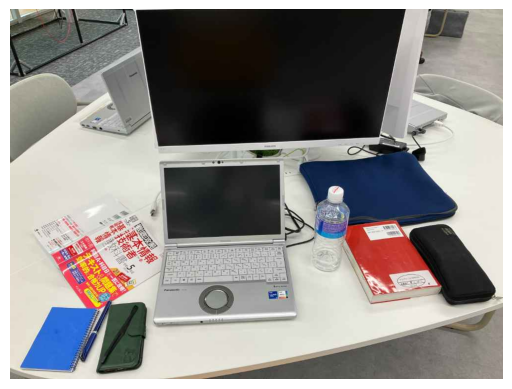

In [74]:
#@title 犬猫画像判定サービス { run: "auto", vertical-output: true }

labels = {0: '汚い机', 1: 'きれいな机'}

URL = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gHYSUNDX1BST0ZJTEUAAQEAAAHIAAAAAAQwAABtbnRyUkdCIFhZWiAAAAAAAAAAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAACRyWFlaAAABFAAAABRnWFlaAAABKAAAABRiWFlaAAABPAAAABR3dHB0AAABUAAAABRyVFJDAAABZAAAAChnVFJDAAABZAAAAChiVFJDAAABZAAAAChjcHJ0AAABjAAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAAgAAAAcAHMAUgBHAEJYWVogAAAAAAAAb6IAADj1AAADkFhZWiAAAAAAAABimQAAt4UAABjaWFlaIAAAAAAAACSgAAAPhAAAts9YWVogAAAAAAAA9tYAAQAAAADTLXBhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABtbHVjAAAAAAAAAAEAAAAMZW5VUwAAACAAAAAcAEcAbwBvAGcAbABlACAASQBuAGMALgAgADIAMAAxADb/2wBDABQODxIPDRQSEBIXFRQYHjIhHhwcHj0sLiQySUBMS0dARkVQWnNiUFVtVkVGZIhlbXd7gYKBTmCNl4x9lnN+gXz/2wBDARUXFx4aHjshITt8U0ZTfHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHx8fHz/wAARCALuA+gDASIAAhEBAxEB/8QAGwAAAgMBAQEAAAAAAAAAAAAAAAECAwQFBgf/xABHEAACAQIEAwQGBgkDBAMAAgMAAQIDEQQSITEFQVETImFxBhQygZHRI0JSobHBFTNDYnKCkuHwJERTFnOT8TRUomODwiWy/8QAGQEBAQEBAQEAAAAAAAAAAAAAAAECAwQF/8QALBEBAQACAgICAgIBBAEFAAAAAAECEQMSITEEQRNRImEyFCNC8IFxkbHh8f/aAAwDAQACEQMRAD8A15OznUpfYk0vLdGSsstR+Op0salHEwmtpxs/NGLFR0UvcZ+k+3U4fW7TCQu9Y91l0rtnN4ROTqToxSbkrq7OjWq4fD3WIrrMt4Q3M9bWu0iLVt2PJK3s2XWWhgq8aUbrC0FH96erMdTGTqq9WpKb6E6Q7V0sRVpKN1Uc5xd4qOxVPHNwvTUacWr3OdLEZI3k401yvuZu3zXyRc+jlsXUi+46E8U5c5VGUVMTZ2lNR8I6sy2qVP1k3ryWiHGkoezFW+BUN15N3hD3y3J4Sq8NOp2jf0nfTfO24lDm7a8mQ4haHYxvbs7J+/cDnqtUXFrSm1GXwO7TnTxUHtGtGNn+8vmcPjEclSjWhy0bXgdChaUIzi7O+jNI1Unq14GDiVHPhppe1DVG1PJU95DExzycb2vGzC4svBKubB1qPODU17zapSbb00ORwSfY8Q7OWmdOHvOu3klZ3UlzuENOUlpdvy0FJrxv1E0mrzlq+iuClaNk7JbdQE42V2n53BRcVmSa80NptX/EIty0te3K4RFRjLl7yUEktb263sRcJatRem+o7xsrNp9LaALu5uvmxZIWbkn4IsaTj7V34ohG7dmm/BFEOzpzT7q82V+r05b018DRGm9c2a3ghwo3nlT1vzA5vEsJFYXtIQScZK9kLBYOjXwsZzSzXafU72GcZzk0r06d/fbn8TlYSoqtfFKKvHPfYH0r/RlFt2i/M73B8ZVpYWeEu5yhCTpN+C2OeoZtY8uTNPD5KOOpSa1zW08dAOFP0j4rmf8ArJLyjH5EH6RcUf8AvKn3fIx4+l2OMr0/sVJR+DMwV1Hx/ib3xtX4kf05xJ/72t/Uc0AOg+M8Rf8Ava/9bE+L49742v8A+RmAYGx8Txr3xmI/8jIviGLe+Kr/APkfzMoAafXMQ969V/zsi8RVlvUm/OTKBkFnaS6sM7IABZnDOQACedhmI3ACWYMxEAJZgzEQAk5BmIgFSzCuIAHcVxAA7hcQAFwuIAHcQCCGIBAMQAUAAIBgAAAAAAAAAAAAAAAAAAAAAwAAAgAAAAAAAABgAABQAAAAAAAOIiUE5SUUtW7Ae34BQ7Dg9C6tKpeb970+6x0RU6apUqdNbQior3IZFMBAA3sEUNldeWTD1JdIsDzE8KqWIr8RrTUp5pShHkm9jFHESe+re90dLiDUcBJSVszSRyNkEaY4lrkvvRasV+9OPlL5mG4Xuijo0akqks0puaWzdtCyFSV7qtbycl+ZQ/o8J0b0M6kZi10/WK8LOFScl0VT5o0LGVOr/qRxlN35k4VWnqXSO0sZU5J/cEuIOG9Kq/KF/wADj9q7jdeWW0Wxod7DYmOIpZ0ra2s1ZrzL009zHgo5aCbd2+pouRVtkQaSYrjU7PUge60EnbcldD35AR0ZFpFll0FlQFYEsgAWY6C7FOrONNxeaKb1Zy6+IjKDhFN+L0Ms62Z31k+rMlbEpJxzd7pHcv8A6M6/bdGTi7xbT6opnWte2i6szxxrVOKyd5aNtlLed3n94VZPFRXsp1H4bEFiK0lyiuiFlsTyN2d0/eQCklrZuXVsmqt7JijHXVJvoiWTV30XkFl0kpWV1+JJVL7u7M1TEUKSvJqX8O3xMs8dOSaoxyrrt94hfFdWVeFKzm4rnve5zsTxOM5yywzuSas9tTP2NWs05tu/uRdHCJKzaT6IqIQxOLqrLdTilbLJbEqlLFyyundWVpWdtSyFDs6qjykrl9CKcXK9rlGjBynLCw7X246PxNE3eKlYywnKKa0ZY60knBxVuoWenKxL9X4n2i0WZTR0+IcQ9Xr5YwU4tKV0zm8UTbp1G0/q6GjCTjLDwapwbtZthAuL0796k1/Nf8i39KYWXKS9y+ZKUYuPfpR8NCuOGw0nrF6+FwiyOPwzesml4RZNY3D8q0UujM0sBh72T16WsQ/R1N+zUa95R0liIVe7TrQafJSRLs5bpOXnscqXCna6qadWVrh9aL+jn8AOy466L4Cs23m6dTk9hxCHs1Ki8M7+Y1X4pSds035xUvxQR11dxTWay3YsVWeFoOKblVqbLml0OV+ksdH26cH/ACL8rBSxdbE4+i50+856t3A7tGLw/DbS9uVov8WcHhTyY+tSd3e/3M72OnKCoU4wcl7Uneyjfm2caWGycQWLp1ISpTqZbJ66roFdLLadpPMuiJXlCzWiTvz0FFOMr+z4tFme6bbjdc2tWBxPSekqfGazjtUtUXvXzOQeg9KFneCr/bo2fmnZnnwoAAAAAAAAABgIYDAAIGAhhQMQAMBAAwEADABAMBAAwEAAAAACAAAAEAAABAIYFAIAAYCAAGIAGAAAAAAAAAAAAADEADAAAAAAAAAAAYAAAAAAAAAAAB0OCUPWOLYaD2U8z8lr+RgO/wCiVFyx1WtbSlTtfxb/APYHq3q2xDAikNbiHHYBmbH1FDDNP60lH8/yNJzuLzdqUFu22Bw+LVc06cFsk2YN0XY6aliGk7qKsUplQmSpxzTig3LsLC9W/QlFmLlbJBcldmexZWlnrSfK9kJWE9FRWgatE8vUeUogm9jRhqfa1oR6vUplG2x0uDUrznVe0dESjqJWSS0Q9iV0LQilcB2QZSAQ9SNhgO7FdgmxgLMAMAPJOc6l88m77JaIIw0tZF3ZrZbdGPIuctgiuNO3sxfmW9m56uUU/wB7Qnooa2SXOxQ8XRpybaUl8Ci7s7R1s/FO45RUI99qPnu/cYZ8RqSTVGCgnzWn37/CxT2dWr7cm10Wi/uNDZVxtKnLLT7z8Nfw+ZiqVK1efebS6LX+xfSw1lt7kao04rZOPuAx0qFo2l1ur62L6VBR1sn56mhRtok2vLUlBa2e/i7Bd7JQ01UUut7CypXur+JOSV/Zj7mDWmi052KyhUkrZraxV9idBtUIrLFd1a2uxOUFyuvFbknK0PDkkAk0prL1JT1k21fUVLWSvstegZt2+94XsGv+LPjqfaYWdt46op4TPScbu61VjXKOa8Xz0scvBSdDGZHzbiwy7DV/bbbfiNSd7Qs/ciPtPXV9GGXL7Vl4IAd3LVJPwJqMpJvLp1kJLut6gvZu3oANK+iv5EnCMPrST6J6kIp30b+BN3Uu62l4lQ1CSWaV3Hx1FmzXsrL8SMrLVv3t6FFfHQhZayl+PuCtCjLXWOXm29EZ8RiMPSSUbSqX0aja35sotisU7u9OH+fA14fA0qavZzn8QaZorGYxpK8YLruaKGEhR+rKU731fM1KDhbvWXkTjdLuxWu7tqFDcoNZr5ny6BJK+qaT8S1wo06eks0/wK733+5hGfjcFU4JQqLXsq0oe5q/5HmGevxsVV4HjILXI4T++x5B7hSGIAGAgAYAAAMQAMYgIpgIYAMQAMBAQMBAAwEADAQBTEAAAAAAACCAAAoAAQDEMQQAAFAAAAAAAAwAAAAAAAAAAAAGAAAAAAAAADAAAAAAAAAAAAAAGAI9f6KUsnDq1T/kqW9yX92eRR73hNH1fhOFp88mZ+b1/Mg2CAAoJEeZIAOHxet/rbXsqcEn+P5ncPJ8WxGbFV0nvNr4aAc6TcptvnqRJJppi8blQ1JmzDdyjKbMUYuUlGKu2bKzVOjGlze/kZv6WKbkokUkxqyNInm6g5+AlsPI2tgBy0O9w2n2eDhprLVnAhBynGPVnpYJwhGK2SsSqs0YW6Cz9R5l1MhhawXXVDsuoCE2huwmAroYgsA7XAEwA8xTqwVGNWrUhFNc935JalFfidO2WhRTl9qXyMMKbqX6c1exopYZJavL4W3NJpS516zvOVvC35ciynhnKV7N+L1NdLD88ui57IuUKa6vx5EGeGH5u5dTpaWt8CxpbJ3/AAHotL3b5IqbJRW1rDaaT6DWWN07X+BWpK+110CLO7l1uDcWrK68WypyTd9kPR7ySC7S8Oa+AX5aX8NSOS+qbfkJKy733hffpKbs9Xd/FjypJN3v0IqC3i9Fu9rEopz0gmlzbZU1tKCtFtacrkZJX0afvHLRJJNpdUKPl8URb+klHTSLb8Dk41Ojjc6Vr2kdd2/9Oxz+KU32cKiWidrlR0IPRSTUrrSw03G94x157sz8Obq4WNldx08jRke+aL94DayvVe8lGyd18WxRu2m1Zcm2V18ZQoae3UfLd/D5hFsYOSbcrR6vmZ8Ri4UXlzXfKK1ZW/W8Z3m+xpvR66stoYKhRTbTnLqF0yqOJxUucIv4mqlgYULO13zuaFSlFezKP4FkIxb0s34oKUY928kkvC5NxyxvBZU+dy1UoqN3KK8tyrLF7JxXi7hDzTSV9ffclkc7b36JCeWMVlu2xpyT5xfhe4Duo6Tvpskgte2kkui5j7RNd5t+eooycG1FOMmBbRg6sMTQbv2lCaS8bXR4mejZ7fBScMdTztvNK2/XQ8djqfY4utT+zNx+8KzgAAAAADAAAAACKBiGAAAEDAQBTAAAAAAAAAAAAAAAAAAAAEAAAAAAAAVCAAAAACoAAAAYhgAAAAAAAAAAAAMAAAAAAAAYAAAAAAAAAAAADAAAAACyhTlWrQpR9qclFebdj6LZQtGO0VZe48V6O0u14xh7rSDc37ke0vqRTAQmwJLckVolcAnNU4SqPaKcn7jyM44aq7zqtSe+p6jHvLga3jG3x0PNyw9N+1CL9xKKfU8PL2a7F6hBf7hW8ix4Ohe/Zq/gNYSktov4snn9nhBQp4dOVOMqkjLN1ZycqlOab8DpRpqOxO2hYOQpW3TXmiSqK+51cvQjKlGXtQi/NFRzlUJxqu9jW8JSe9KK8tBrA0Xykv5mNiODi6uJinstTuKTMWCw0aN3G7vzbNqSJVF0+RJbEbIkgoZEsUUwcCIhr1C7JOIrAAXaAa8gI530AbADxOEk1VS66HRhBLml10OZWi6GKlFaWd0dWm4zpRntdaGmU3JZbN3fmRTfRv3hJ23V/AFJPuyul4IIbd1ra3gNSj9RRXiQdOOji7/ykcvetpuBL+ZPwHeVkkvhqNq+iTTXUjaVrXVih5U13tPJDcoKNl+OpDvNWsrLoDV7N2XluBKLtLuvKgeW7fwvYjFyjok7MknFLVrN43AcFzeX+Ynmhs3b8CCbbs/uZZFW2Uvhcaa7VFLLZwlcO9N2d2/Mfdi9mvMG3s5NLfUMk7pat+9FdelKvh5wa5aNk+2UG0mpPlpdmevjVs23LbLHV/JBU+HUq2EoyVSSUZu6UWOtjacHqlKT+qld/JGaFLE4i1r04bWT1NuGwdOhZ9mpeMv81Csq9ZxctZdjB6Pq15mmjg6VD2Y5pdWaJSzbpdNrInFbybv8GAsrzbu9uaJJJN5rN22SJpScW1aMV4DjBzvlhp4IIrj3nrt0TJ2drQjlXOz3JU01PRZpLnfYdSTm0nK766AQsktdHyuSyzUde6vLUU4tezTt4vUjbKrR1fPUCyCstoy5aiyuPedk302Flc92/BLUMnRPzAE7Su43fVMlKUadssdXvZkVminqn5CzXWspJ9AJRqSp1FOKTs7nE9JaSpcZxFtptTXvVz0NPByq2blJLrLmcr0tpZcXQmvrUUr+WgV50AEAxAMAAAAAACKBiGAAAEUAAAAAAAAAAwEBAwEADAQAAABQAAAAAAAAAEAhgUIAAIAGBQAAAAAAAAAADAAEMAAAAAAYhgAAAAAAAAMAAAAAAAAAAaA9F6J0fpcTiH9SCgve/wCx6O5yfRul2XCc73q1HL3LT8bnUuRUribI3ACxbDW4kSjuBi4vK2HhFP2pX+COPrc6fFpXqU4dI3+P/o59l0AS6Eo+KHYGiCSt0Ha/IgkyVmUOwOCbuNJkkmQQVNE409RpFkI3AnCLSJoEieVgRBDysLBTTGpEQIiTdyNgs+QeYAG4xWs7oAAG7gB5HicVLs6sUlydkSwFROk4yu8r0NOJpuph5wsr2v5HMwVTs66XJ6am2XWlJ2V7JeAoRhu3r8UCSTT0bfJaE3+8szXK+hEQlPM7LXT6oLom/JD01z2XgkPNC3daXuKFkWt24kVZb2aJxleLUtAzJaRX5gRaTtZR9zBwyvvRd/MmnZaK1+dh77ZQI5VZOL16ciLim0r38y20pxd2rLxI2aa2S6gSTcEtmvIeZJu8IvyuU1a1KN7NzlztyMdTFucssbyf2YfMDfKtSjdZW58kndmOrjG3lUnJv6sNX8SNPCV8R7byRf1Y7G/DYOlS5x+GgVhjhsRWjeX0VN8o8/eaqGEoUlaKd+vU2Rhdyl2sdBxpuUlmypPm3cKrSSva+nUshdpNw971J9mk7Rs/KVhWUlaVRrwCINK6Vm2+RJp6KWa3RDhDNdqSSXNafeGijo1H3ADta2q89xvdJaLpccM62mtOpJV6l8kLXfggIznLLlbdvuBZZu0FfxY5t6Oym3zIytG2aNulgJQpym8sbpLfRInNU4u0HKUubWxXJxS0ckul9wSc475IrwAmkkn39PLQryrMkqll5jjFtqNNKobaOBTtKtFX6J6AUU6Uqiyxln6tbI2UMNGnrN55dXyL4wUUoxVl4FdXE06V0nnl0XIC5LS70RwfSuEamCw9aGuScoN+epsq4idV956dEZuJx7XgmIjzpzjP8grx4De4gAAAAAAAAACKBiAgYAAUAAAAAAAAAAAAEAAAAAAAAABQAAAAAAAAAAAAFQAABAAAUAAAAAAAwAAAAAAAAABgACGAAAAAAMAAAAAAAAAABgA0IvwND1rF0aH/ACTUX5Nge2wlPsMBhqO2Skr+b1f4llx1GnUlba5G5FMcdyNyUALEShuyCLIbagcXG1I1cbVipax0sUqNinCyeIxGIxFms8m/i7mrKQpKJJQJRjbUmvIogoAollugWYEMo0uqJWY0gDKnyJRiNRbJxjYgFtuO48ostgo15C1GNAJ3BeQ2IB2FYORG7Ih2AVwzAABo0AHCcotaNN8+6cXFQlQxLtprmjY7tKkm7u+VK7OdxiSquM1ZZe7ZG2Y2U4znh4V3fLJe0loSUcyupRVuuhj4XjuyoOnOUmk7pckdBdnWtJTtf3ohpTlvdt++4KLaVn4kpXi8rjf3AnG/eX3lQauV2lLwsF19WK8xymtMssq6DTVmozbb8LgRvFqzbv0Q8jk9dL8iudejRTu88lyXXzMVXHVK7yU02ukdF73zA2VK8KN4tqbXKL/FmKpjJ1nlgrv7MdviSo4CrXtKo9Oi0RvpYTsNEoa6JNBdMMMBXqxz1F3Okdjdh8PQp93I7+RohFO6nljboySjN+zG68GFVRoqTemnW5dCUY93IEc8VZK13q92CypO2bN8QDR2aS0+s2NQs257+LCE7Nu95feEIqbbSvK+19Ah3d7xTt15Id45W23JpCqZpNRSy35RW4404Qiu0vmvsnsBVmt7PXoXd3s8znC/SwSgnFZW4rxiRpKpCL0VurWiAUISbvma8lqErxWVq1/HV+YrZp2grvm3oiapScsi70vCWiATjJRUssop9RO+ZZXJrxRbUpypq9Xv+DkFKk60nlhNdGnogK8t5vu5mt2aqWFlWtmWWPW+5po4fs0r95ls5woxvUkl0XNgOnShSVoL3kauIp0fbd39lbmKvj5yvGl3I9eZku3qBprYypV0Xcj0RQr38CN0vEjJt69ALc3Qtpx7ahiqL+vQlbzWqKE7o0YKSWLp32k8r9+hFeKmrSZEvxdN0sTVg94yaKCgAAAAAAAAAigAAgYAAUAAgGAgAYCABgIYAAAAAIAGAAAAAAAAAAAAAAAFQAAFQAMAAAAAAAAAAAAAGAAAAAAAAAAADAAAAAAAAAAAYAAAAHX9G6efisJ20pQlN/C34s5B6T0Xp5aWLrW1eWmn97/IDttiEBFSJx2KyyOwE0QxlTsMBXq7Zacn9xJGL0jqShwepCEW5VJRjZK+l7/kBwMHxJ0aUVJQaersrM7VNRqwjUhfLJXR5fD4KviJqCg4p7ylpY9PRXZUo043tFJICzI0PIJN8yS8wGooll8BAgHlHlQJjzALZjTHdcgIGr+APUiNMKa8gBPUYCsGgxWsArCyg7p7krgQcQykmRYQZQEAHDrSVCjlv3pau3TkYI0e3hUck25K0fAsxLnXxChs5O3gjao06MFCMtfBGmXCwVR0cUk9L913OrKi4rPSllb3XI5ePp9nim1e0u8jsYeUJ4aNW6V156/kAU8X+zqpxfiyyUIuOZSuvExYivTlCSspeL2XvM3rVarBUaSvHnpowNtTE0oRajCLa+s3ZGKeJqVXlppz+5FlLATqPNWk3+B0KNCjTirK78NLe4DnUsDKtrWmvLZI308NTp+zrbwsi9WaspJLxLMloNxyfG4VTkvq+6iyMZKLcEowW7nbUlld7z/ATUU1nzNAOEY1Fqpac0lYnFJK0ZNpdVsRc43dvuJXWRNtLwg9Qitt3etrdNh9rLKl0FKc5RaabQ41ssMusbc7ASW3eeT72DrLK4w0j4LUjCEpybhJNdZIk4pJJZX4p2AIvLrC8Wt5XvclFRleVpNreTtYqayyV+94J3J5rvv3Uei5ARnJtuzv4smptwsp3S30sE1GdmrQitiUpRyRinFQ5pcwIKazLKnJPk23csbqOSyRSb+qiyjhJTam24R+83U6dOjF5El1k3+YGWlgbvNW36I3LJShd2jFGSvj4RuqSzy68jBVqzqyzTk2/wAAN9biFtKK/mfyMMpSnK8m5N82R5a6Ccny0AmrLR79CDbYkN9QoGIewCg7XRbCWWcZdGmVPSSa2JgcX0ipdlxjEJbSlmXv1/M5R3vSiN8Th63/ACUY3fitDhAIBgAhgAAIYEUgGACGICAAACgAAAAAAAAAAAAAAAAAAAAYgAYAAAAAEAAMoQwAqABgAgGIAAYAIBgAAAAAAAAAAADEMAAAAAAAAAGAAAAAAADW567glHseD0nzqzlUf4L8DyKPc06fY4ehRtbs6UYvztqBIZFEiKaLEVx3LEBOOrRn4k7xpx82aaftGPGvNiLdEkBlhFJlqkiI7agSSuSSsQ1JoBktCNhoB2Q7IErjSAjlGSlHukLgSs7CysE2O5BHVBclcQUJsmm+ZC2pJJANpC0AAEyJITAjYBgEeMnDFK123Z3VpbEvWsXHSUqj8+8djOl3VGLexXKh2kndRuuTRpGDiGStg6NRR+kS7zslcOF4mCozw9WEZRbvFtNteRueDo86Tlbe23xNWD4ZObzYfDqknvN6L4kHIp8OlVm3UzS10TVkjo0sE6KWWyeyitWdqnwylFfT1JVX9laRNMOyoK1KMKa/dWrJscilgMXUXehGMXznp/cup8HgpXq4i/hCP5m6VW/K5U6svIm6GsBhkrPtGl1lYfqOE/4//wBEM7bBt30HkKXDcO/YlOEuTUrlNTh2IS7tbtF0e5fmfUI1JLmXY50nJNQqUlm6OJGUknapBeUXY6s+zxEctaKl0fNGCtgI0k55pTh4fmXaKUob5ZO+vgRTi9tXfZ3CNknllP8AITjk+vvyKLd01pK2raZCcr9FHyBzzK0nFr7K0Fk1TjH3AOnNRuklr0iTlUiofW05LYhGDnO0IvN0RspYWSX0rzPoBRShUxD2WTq0bqOGp0+9a8urJxWVJLQmgp2dtVoczG1JSlGOqir6X533OomYcbSum4q/NAYEGboR33GAcxiY1qAxrVeRElHRgQnWp07qUldcluVXq4m9r06fXmy90oOeZxTehMCEaahTUVd26lkHdBYI6SaAzekFPPwzCVOcJyg/xPNHrOJx7TglePOnUjP46Hk2AAAAAAAAAAAAAEUCGIAAAIAAAKAAAAAAAAAAAAAABAAwAAAAAIYABQDEMAGIZUAAAAAAAAAAAAAAAAAAAwEMAAAAAAAAAAAAYAAAAAAAAwNXDaCxGPw9J6qdRJ+V9T2VWWapKXVnmvRuln4j2nKjTlP37L8T0QU0MSGQSiWIhEmii2ktzHUpupXm21GLlZN7G2Dy02/eYJ1nPR7EFqwdvaqxS8ES9Wor9pL4GaFZruSfkyzN4kFnq9PlUfvQerrlUi/cVZmhZ2Bd2E1tZ+TIunOOri/gQVSS5ko15LmwAaJdupe2k/ND+ilteL+KKE3oRs+hN0pP2JKQrOPtJrzII+Y1uCeupL3AQy6hZ9CegwqvZhcmxMCOoaklZiaAQhsQBdAKwAchxhB6SUn0j8zThMBXr2k7U6fWS0/udHD4GhhY7dpP7UlovJFtSs+b1G2UaeHo0kk12slzlsvcSqVnfV3sUyqNkG7kVZKs3tovArbYgABqV90IQEhBfqFwBvUTdge4nrzAZKM909U911Kw5AU4mk6Uc1NXpP4pmW+1/ckdKMlqnrF6NGV4K1RxirweubY1KjOmpPbXa1tDRSwsp6yWWP3/ANjTRwtKi7pXl1fI0XSKaV04KlG0VYlcTkrho9gJrzJaIrRLdAPMmyFVZ4+WxKySGtQONWhkqNLbdEDbjaXNLYxIBiWmgxPR3AkNAhgPdDQIYBYJLZ9BjtdEE1DtsJi6X2qLa81qeNktT22Af+ojB7STi/ejxuJg6decHvGTRRSAxAAAAAAAAAAEUCGIAAAAQAAAAAAAAAAAAAAAAAAAAAADAAAYAMAAAKgGAAAAAAAAAAMAEMAAAAAAAAAAAAAAAAAAAAAAYAAAMQwAABAej9GqeXDYqr9qUYL8X+R1jJwmkqPCMOudRyqP3uy+5I1hTGIaAnEmiCJoCVaWTCyfhb4nNubse/oYxXNmFRbIE7NWY4Td8r3X3jyMjKnK2i1WzCLc4XKoSzLXRrdE7gSuFyNxogkO4gSb2AmptF0a8krPVdGVKDS1FYDQpU5+1HK/AfZp+xNPwehnuNSaCrZRlH2k0RvYca8lpfToyeanNd6OV9UBHRoEkx9lzhJS8NmRd07NWYDyoVhDvbdhSaIMldvmK4EQHZcgAlOq5baFb1E2K5EO4NiuguA7iEAEkIQXAGwuJsVwGIVwuA7iuK4BDuWU58inwYJ2ZRr15BZBTkpRXUkrWNBWXRDsgbsVyqcl8QHKST0EpsrGrgXZlYE77ldiyjRnUdoLzYEK0M0DlTjkk0eopYWEItS7zas2zhY6h2VVro7EGQGroYFCh0JkdmTAESEhogYxDAlReSvTl0kvxPP+kFHseL4hcnLN8dTveJzPSun/AK+nUS0qUkyjggAAIBgAhgAAAAAgGACEMCBCJCKEAwIEAAAAAAAAAAAxAAwAoBoAAYAhgAAMBAAAAAMAAAAAAAAAAAAAAAAAAAABDEADAQAMAABgAAMAAAGl0A2cKpdtxHDU3s6iv5LUD1fZ9jTp0f8AihGHwWoDnLPOUuruJEDJR3IkolE0WQV5IrRbS9oKzcSquEoLK7JN3toYPWujPQxw6nFTzSUnvZ6Gatw9SbzUoVF1tZkHH9aZKOJvuaamCoRlZxnTfQisFS5VfigimUk+/HdbrqSzXSa2ZY8Io+ys/lJBToT1Tiow3WaWwEESRY6KitKkW/IralHW111WpBK48zXskIyi+ZNLoAXk/rMkriTHcBgRuNMCQXFcLgTU2ti1Vrq0kpLxM9wuFackJ+zLK+jITg4+0reJWpWLIVmlbdAQsDTLXCFTWDyy6ciqalB2kmgFr1AE2AVUActBXIguPQiFwJCFcV7ASzciNxNsTYRK4r6iFcB3Bkbhcod+QhXC4DuFyLYXA0UJd619zQ3bncwQlaRNYyFrDatDdyNipYmA/WIF2i6yH7iNCMsTK1KLfV8kdTD4WFFX9qXVjYooYNy71XRdOZujFRSUUkguQlP3Igm5JHP4pRU4Ka8ma0nLfRFWJnSjBxk9WtrgedaabTCxdiIZZ3WqfMqNBNaEo7AC0YDGgGQMAABmX0lhn4fgq1tY3g3/AJ5Gojxen2vo+3bWlUT/AM+IHkBDe4FCAAAAAAAAAAAAAQAAAIAABAAAAgAYCABgIAGAgAYxAAxiGgJIYkSAVgsSACNgJWFYBAOwWAQDAAAAAAAAoAAABDABCGIIAEABcZG4ASGRGAxiGgGhiGAHY9HKWbGzqvajSk15vT82cix6H0fhkweIqfbnGC92r/FAdMkiIwJEo7FZYgqSL6OzZQjRSX0YG+FskUnfQkc9SlF3i2i6GJf11cmkaJQjNWkk10aMdbhtGpdxzU3+69Pga4VYT2evQkQcOtw3F023SkqsfB2fwMU+1hLLUjKMuklY9SRlCM1acVJdGrgeahNvQedxd0zsVuFUKl3DNSb+zt8Dm4jhWLp3dPLWj+67P4MozyqQn7Xdf2kCqShrJ3j9pGaeaEnGpCUJdJKw4VHHYDapqWqZK7RjUk3eDyvpyZZCq72ejINGa4XIKae+g7oCWZsZG41ICaHYr7QO0AtArztjTYFsZWL4VVJZZq6MiZJNphV1Sll70HeP4AOnVt5AQZRPUNxNgK4XEK4DbFcVwCC4rib1C4BcCNwvcolcVxCAdwuRuFwGFyNwuBK5FcMnu6yXkhJ3kl4nShCVSVoJthWFcOS3rS90TZhuCqTUqtSeX7OzZ0qGFjSs5d6f4GgCNOnClBQpxUYrkhuVhSkVuWl9l16gScru27Iykoq+Zac+SM9WurZY3S/Ezyk5e09iexPF450qX0d9dLvdnLi54uq4udmtX5G+pCNWGWaujK8BaWaFVprZ21NIurUk6SSXsq3yMJvp0asX362aNrNWMlaDhUem4EBgADQxIYDGJDQDL8nbcLxtL9zMv89xSa8AlKdSD2nCwHg5KzIl2Ig6dacHvFtMqKEIYAIAAAAAABDEACGIAEAgAAEAxAAAAAADEADAQAMYgAkhoiiaAkiSEiSALBYlYLARsFiVgsBCwWJWCwEbASsIBAABQAgAYCAAABAAmNkWAhDYggAQXAlcaIDTAmmSRBE0BJDQkSAaWp6fAw7LheGitHJOo/e9PuR5qEW3ZbvRHrasFScaK2pRUF7kBFVJLxJqoud0VklEC1NPZliKaa1LkBJGlWjSV+hmWrNctIoKru3sviFnzdyQghWJwrThs7royIWb2A0wxUX7SylykpK6aa8DA4rmwTcXeLsTQ6AGSGJkvbVy+FaE9nZ9GQOpShVjlqQjNdJK5gr8Fw9S7pOVJ+Gq+B0hAecrcIxVK7ilVivsb/AyOWV5KkGrcno0euK6tGnWjlq04zXigPMq6Sd7xfMsTOrPhNJO9GUofuvVMx1cDWoy0jmh1jrYoz3BXZbGEF7c0i6Hq/KZBmUGyapM2KFO2g3lW1gM0aLJqkWZ0QlVSAMiE0kVyrXIqbYF0UAqbAChsVwYiKBMLibCBkbg2JsAYr6hcjcokIVxNgO4XEJsB3C5G4XAdxNhCMqklGEXKT2SOzguFxp2niLTnyjyXzCseA4fUrzVWacKS2vvLyO7TpxpxywVkO5GUwJNpEJT5bvoRu5PT4sz166h3aTTfNkFlWrGmrzd3yijJOrOo7t2INtu7d2V1q9OhDNUlZfeyybTelgzLHGRclF05Zmr5U03Y1cjVlntJdgdxqnN203LVGNJXfekRUYU9M03ZGXGQT70djTObk2VySd47uxRzhjnHLJoWiV3oiAGRVWOfs2rX2JoARNRBK25S6sqrcaDtFb1OXu6gTnVUJKEFnqPaK5eZfw6LhjIzqSz1JJq/JeCKIwhRg7aLeTe78xYetOriqXZK0IyV31A4fHqXZcVxCta8s3x1Oad/wBK6WXiEaltJwX3aHBKEIkAEQGFgEIYAIQxAIQ2JgAgABAAAAAIBgIAGAhgAAAAMQwGiaIImgJxLEQiTQDHYAALAMQCESEAhMbEwIsQ2RCi4AIimMQAAABQhMYmBFiGxBCAACAaEMCSJorRNAWIkiCLEBt4VS7XiOHg/tpvyWr/AAPQzeecpP6zucn0fp/6irVf7Ok7eb0+Z1gBEhABZAmQhsTQFlJXqRXiap7oowyvU8kaJJXu2BAMvXQeborCANFyuDbYgAQwIynGHtOwDE9FduyKJ4nR5VbzKZVM00pTWa17XuyDdSxMu0jCF5XdrcjoHNwOHbrRquNorW75nSIEAxAAgACnEYShiF9LTUn12fxOXiOByz58JWtb6tT5o7QAedi8Th3lxVOULfW3T95eq11oztcrcjJV4dQnrCPZS6w2+AHPdQqlO5orcPrU9Vaov3d/gZlHJLvLbqFNRuWQiKNRSdkizNGmtdWEO2XcCDlJu7Wv4AFVNiemwMjcgLibB6iYQhNg2K5QXEJsGwC4mxXC4BcLiE2A7mjC4Ori52grQ5zeyNOB4VKrapibxhyhzfyO1CMYRUYRUYrZIKpwuEpYSNqavJ7ye7LwC4EWpMrqtQjmm7JeBdchWiqlNxeniBhq4ipVVkssei5lNrGXERxWHxDca1OUG/Yadwr4utGa7Ckq0baqMlcqNSaz2kpKP2krlsoYOdO7jna2vFp+ZRGsnS7ScXHS7TWqIUsZh6srQnFvwZfQnSoQU5OhTSlLeW5qjTjSV288vFkI1lTi0mklu2iOjld6x6LmN7E5ylO3Lx6AoQjG+vi2wTgr5YZfISUWu9p4ckAnd6R0jzFq13H7yydnHk1z1K5N6JReXwAzYmGuZamOrGcp9xbq+bodGbjNOKWy5GNtxbitWQRo01T1t3urJynGnFzm7LqQanBOavUv9VaahGm3LPValPkuUfL5gJqdfWonCnyhzl5k51IUYK9klokiutXVN5YrNN8iWHwcqs+0rO76EEKdKrjJXn3YckdWhQjSSstiVOkorRFyQHF9Laeahh6nRtHlbHtvSGl2nCZS505KX5fmeKa1KEFh2CxRELErABBoTJsiwIiGxARYhiABDEAAAAIAAAAAAAAAAAGAAAASRNEESQFsSaK4liAkAkMBiAAAQxAJkWSZFgJkRsiFAABFAxDAAGBQhMYmERZFkmRYCEMQQDEMCSJIiiSAsRYiuJOO4HoeCU8mBq1H+0qKK8kr/i/uN5Vgo9nw3Cw6wzv3u/4FoAAAt0BaiRFEkBpwq9p+4se5Ck8mGnLomzJCvD60Mkuc6el/NbMDaBUqyyuWaM4JXbjo15plc8ZBSyw7zA0lU68IJ65vIx18Tli5VpqEXtf5GKWMlUuqFNu315+7l7/uIOhVxU2u7aMeosJ2deUpVpTUFK2mlzmqFarNSk5T1vblu38vgbqEat++0k+VgOnPh2DxDhKF04ezllp8Cv8AR0qc81049UvxIwhPJ3dzReusqV2rakVdTTirIsuyqnWi3lneM+jLwhDAQAAAAgGIACwAFKxVVo06ytUgpePMuCxBza2AnGLeGkvKXzMGWpCX08HF8kz0BGUYzi4yimnyaKOGpAdGtw6nLWlLI+j1QActsg3qNsi9yITZFsbZFsoLibBsjcB3E2IGACBmjB4Kri5XistNPWb/AC6gU0qc61RQpRcpPkjuYHhkMPadW06v3R8jThsNSwtPLSj5ye7LgoAQAAAIB3ISTezJABnnSb9qKl95mqYKhLenlfVaHQEByngGv1decfB6nPqcGlGopwSbTvpL5no3CL5EHSXJhHAxtGpXwjo1IVIP7aVxYCpLDUOzr13Us+67O9jvOlLwZVOjGXt00/NF2MUcXSe1SPv0LY1W1pr5MlPAYef7O3kyiXC4bwqSiNi/tL7q/uIyxEI1I05KV5bOzt8TK8FioPuVbrz+Ym8bT9qGZfw/IDfJRna7ehmr04wkmkknyRQsVUXtUl7nYc8VGUPYlmWwQ5S0M060qjyUPfIl2dXFNRScY8zpYfBxpxWgVlwuCUO9LWR0IQtyLY07bJE1G3Iggok0hrXYklYDPxCn2mBrw6wZ4CS1Po80no9mj59iqTo4ipTe8JNFVQAwKgExgBBkWTZFgQYmSZFgREMQAIYgAAEAAAAAAAAAAADEADAAAaJxIIkgLEyaZXEmgJ3HcjcYEgFcAGJgIBMiyTIMBMVxNkWwqVwuQuFwbTuSuVXHmAtuFyrMGYCy4myFwuA2RYXEACGAQAA0A0SRFEkBNF1GLqVIwW8mkihM6HBoKpxGjm9mDdSXgoq/5AeoqqMZuENIwSivJaEDbhquF4pHPGtCf7sHZrz5ircPqR1pPOunMmxjHHcTTTaaaa3THEosQ0RRKOrA0V+5gXbovxOeb+IQlPCOEHZto4VeOKpxlK+Wy36EGmtUgouLlG/NOVvic/G1cVCn2lB3i3r2fJHPq27SKp2dXN9Xd+Z1aWErVYtUpZOrva5RnpY6piYQeIgmo3SurXOxgYUsTFyjmvF6prYwrgVecovtYS11zN6fcd7AYNYWh2d80m7ydtyBRw65aE/V30uaowJZSKywhlfNGiE2iVuqDKugDlGnVVpxv4lffw77zz0/tc0TtYkndWeqYRJNNXQFdKOS8U7q+nkWAAAIBgIAAAAKAAAALAABZAMAPMMTC5FsITItjbItgDYhAAXBXbSSu3yLKFCpiJqNOLfidzBcOp4ZKUu9U6vkBjwXCXK1TFaLlDr5nYjFRioxSSWyQwCgQAAAAgAAABAAAAgAAEMQAIYgBpPdIi6cX4EgsEVuk+TuQcGuRfYdgMrinvFPzRW8JSm7uCXlob7LmkRcV0AohQhBd1FiiiVgAEhgADGIaAUtkeJ49T7Pilbxal8Ue2n7J5X0qpZcVSq/bhb3osHBAVwKpgABCZFkhMCtkWTaItARYiTIgIRKwrAIB2FYBAMLAIB2CwCAdn0HlfRgICSpyf1X8BqlN7Ql8AIAXLDVntSm/wCVk1gcS9qFT+lgZxo1x4XjXthqr/kZZHg+Pe2Er/8AjfyAxomjdHgnEX/s6/8A42XQ9HuJy/2s152X4gcwZ1l6NcTf7BLznH5li9F+IPeNOPnUQHGGdxei2M51KK/nJr0Wr/WxFFfF/kBwAPRR9FpfWxdNeUWya9FqfPG/Cl/cDzDISPWL0Vw/1sZN+VL+5Jei2C+tXrPyikB41kT2y9GOHLedd+9E16OcMX1Kr85r5AeGEe8XAOGL9hN+c/7E1wXhi/2ifnOXzA8CCT6H0KPC+Hx2wdP3uT/MsjgsHD2cHh/fTT/ED51ll0ZLs5vaL+B9GVGhH2cLh15Uo/Iksq2pUl5U4/ID5wqNV7Ql8CSwtd7U5H0bM+Vl5JIO0n9uXxA+eLh+KltQqPyiy2PB+IS2wdd//wBcvke+7Sb+vL4hmfVgeFjwDicv9pVXnFotj6M8Uf8At7eckvzPaX8QA8dH0X4i94QXnUj8y2Porjec6K/nR6wd0B5ReimK516K97+RZH0Ur88VR/8A18j09wugPNx9FJfWxdNeUWzocN4LR4ZUqVqtbt06bjkVPf7zqXMnEqmTCtfaaWnxA5eJ4fwuUnPCV62Dq8lKLsvjqFLG8XwtNxjP1qmuaeZ/MUc9SMlFzcea1t7yt0rO8VZ+DApnxSKrKahOlUftqV7SfU7uC7DHUlLD14qfOnLdHKnKo45asu0i1tUippfEpwdX9H42NSjTpyjb2W3uQeieDrR+qn5MKdCoqivCyTvqQp8cpyX0lCpH+FqSNFPieDquyrKMuk04/iN0WThm3ZRVwyqQlB7STTNccs1eEoyXVO4ZCDh8Npxc6uGrU4LEUXq7e0uTN/qselvIhxTB1E4Y7CL/AFFDdfbjzRrwmJpY3DQr0vZly6PoBClTybfea4vTYIwRNRAFYYWQnKK5oBg0RdSPK78hZpPaNvMB2FdLbVg037Tv4IAHHfXckJIYDEMQAAAAAABQAAAAAAMBAB5dsiyUiDCItiYMXgAM2YLh88Q80laJowHDHK1WvouSOxGKjFRirJcgqFGhChHLBe8sAAAQAAAAgAAAAEMAEAxAIBgAgGAREdhgArBYYAAAACbExiAQAAAADABiGBGp7KfRnF9IcFWxeHpdhTlUlGTuoq/I7jSkrMrqRypNMo8THgXEZbYWfv0LY+jnEn+wS85x+Z6y8tdfIkr8wPKr0a4g940151F8yS9GMbzlRX856i4wPMf9MYvnVof1/wBgXotiOdeive/kenADzP8A0rVe+Jor4/IkvRR/WxcPdFnpAA86vROHPGfCn/cmvROhzxkn5Uv7nfADhL0Uwi3xNV+UEvzLF6LcPW9TEP3pHaAo5C9GeGL/AJ3/ADr5El6OcLX7Kq/Op/Y6gAc5ej/C1/t5vzqElwLhi/2vxmzoABhXBeGr/Zw/ql8yS4Vw9f7On8ZfM2XFcChYDBR2wVD3wuTWFwsfZwmGX/8AVH5FmZLmhKUXzXxIBU6cfZo0V5U4/ImnbZRXlFEHOK3kl7wdSCV3JAWZ5dfgGef25fEyVcfhaMc1SsorrZlL41w9K/rKflCXyA6OeX2n8R5n1Zypce4fHeu/6JfIS9IeHf8ALP8A8bGzbpVaypZb3d9rFTxtNX7snb+/yMX/AFBgHqpVJeUCMvSHBR+pVflFfMbht0XiVnyxg5a2093zJ0anawzZcutrHIl6S4RJWpVtdtF8w/6ko2uqFR+F0ibht2m7COOuOOrSc4YZ3byxTnv9xvhXm4puMUyjSIodafh8CLrS5sDSIxes1Ju1JXX2noiE62Jgu9llf7OhNm3QEc1YqclmzyXgWTnN0l3pXem5ZdjcK5i7z5sANl11C66maOjJqQ2Lbhr0fwIqRNS8RsGWT5MTp1G3ZtfAmmxqTGxHsptW294Rw81zv5ssUjNxPHSwWFTpxz1qklClHrJgSrqFBZq9aFNPnKdjN6/gqvc9ZpO/79h4bg9FPtsf/q8TLWUp6xXgl0NssFg5xyywlBr/ALaGxTBLLmgsyfOOqMmOx3qygqdJ1K0naMHoVcSwmF4dTdfB16mFr/VhB5lN9LGalVrUMR61xWhVeeOlSOqiuluQGyePqQWsIPyucaXpJi76UqK84v5noovC4mnmoThOPgeQxfD8VQqSvSco30cdQNT9I8byVL3R/uY8VxXF4qUXUqWUdoxVkZGmn3lZ+RCTsUdLC8dxuETVKosr3TirM1w9JIy0xGEptfu6HA1YNPoB6WPE+GVt+1ot+N0X0KOFrObw2Mo3krZaiV/c3b7jyLBTlF6NoD2Vbh9WjQlWbi4R0Vppr8TDKSis0mcKGOrwVlUbXR6lk69fE5Yx3tsgPVcAdR1azpOL7qum9FqdpvE9KfxPCcPqVsM1JSkqk9IqDs2e5wVPEeqU/WpfTW7xKJL1m+9M5VeFXg2L9ag0sLXlarGK0hLqbMbxTB8Ouq+IWdfUjrL+x5niXpRXxcJ0aFONOhJWeZZpMD2kYzlFSVZOL1TS0Y1TfOpJnzR4zETjGEq1RwjoouTsj23ovXniOFJTk26c3FX6WTX4gdbso83J+8ahBch5fEeUgXkA7IAIjsDAAGIYAAAAAAAAAAUAAAAAAAAAB5eRWwjPNHxJ0aFTEVFClG759F5hFaTlJRim29EkdrAcMjRSqV0pVOnKJfgsDTwkbrvVHvL5GkKYCAAAAAAAAAAAAAAAQDABAABAAAABYAAAAAAAABAMQCAYgEAwAQWGACGAAApxzRsSBAU9jLqh9jLqi4YFHYvqh9i/tFrItgV9n+99wsluZJsi2BF6EW2Nsg2AOciLqSXMTZFsBupPlL7iPa1OogsA+0qN+00gzz+0/iILANSk/rP4ilduyb8WSfcj4sqzrZMCbaWi1Y4xtq92KEorbfqTWvO5URqkaPtSLKkZPaLfkiNKnUUn3JfACc4ZotCy5tN4rqSnGol3Yy+AKE0l3WBnq4SMk8qSvyezOLiuFRzPKuyfR6xZ6Ls5/ZZVWp1rZYUnK5LFeMxdCpQlaS8FZmRzcWnJM9LxXg+OxMYRo0bpO/tJfizDD0d4ndKVKOXnepH5iRNMEJOyva7Jxk9nt0O+vR2PScXa36yJOHAKUfaaf8VT5Geqaec7SWZLTXU24fBVa+rThF7ylz8ju0+E0qWsPV4vrd3/AALHgm33sRSS8G/kOq6YMOorEwpwV1CPdR0e0rR9qF14FlHD0aPsTgm93fVjlSdR61Fk6R5+815VCVZPSmnOXRcvNi7Nz1qtP91bFkaMabeWTS6chvJf2ia37CE9iXc63IyaV7RbNDHClKpWk0rQ5sunJOSt7MdiLxP0qjKNqeztyuXVo6okmhBTHmIWtuDqRjzKLVK240ymLcnfZFiZBYpE1IpTJJgXKRLP4lKaHowLlKXKxg4tSrVIUK9KGeeHqKeVfWRqsuWnkwV+r+IGePHsG49+U4T5wcHdFc+KYnE9zB4d00/2tXRL3GxpXva7JxX2l7gM+C4alV9YxNR16/2pbLyOnkTVrlHcirtZfHYpqY/C0V38ZTj4OaYFOJ4Lh5SdSg5YerupUnb7jHOhxPDa/R4uHh3ZF1b0iwNLas6z6Qg/zMlT0po/s8NN/wAUkjUlNqMRiMLNNYvDTpT5KcbX95ynw6tjG50KUacHsnK7NeM4/WxVKdLsKUYTVndNs5lOrOm/o5yh/C7GphWblE6vDMRhl9Jl+JR2cun3jndu7bbfNiTNdE7H2Te7QLDwv3m35aDTJpmpjE3QqVNbQXv1JqWXRJJbaIVxGtRGrC4yeGrqtTUe0Stdq52o+kTlh6ikpxrZHlcXeOa2m+x5onFmbjKstYq2d1JOpfM3d3IpSfI6FSmq0Mr9pbMx0otVMsltuc8sdNS7OEHzv7ke59F8NUw/DnOW1WWaK8NjyFNd499wru8Ow6/cRitNV2PUdwuyBagMYEbDGACAYAIBiAAAAAAAKAGIAAYgABgB5bBcOrYmet6cFvJr8D0NChTw9PJSjZc3zfmWJKKSSslyAgAAAAAEUMQAAAAAMBAADEMAAAAAAAgAAAAAAAACwCAYWAQDsFgIgOwWAQDsACAYAIBiAAbSTbdkgI1VelNdYsDJLidNPRO3kR/ScPsy+BT6rC2l7hGhKcl2tnHwdyi18Th9mf3CfEYP6s/uGsLS+yP1el9kCH6Qj9iXvsHr0f8Aib95Z6vS+yiXY0/soCn12P8Aw/8A6YvXI/8ACvizQqUPsoapQ+ygM3rS/wCFfEPWf/4Imvs4/ZXwGoL7P3AY/WH/AMENQ9YnsqNP4XNVSjGcbPu+KRGnCFFNZ735yaAz9vU/4qf9JTPiLhiY0HCKnK20NLvY3uvRjvVprzkimVbAurGrKrh88dpOcboDLj+JVcDh+1lBNt2SSSKqHGalXBes96KUsrSSeptxGJ4biKbp16+HnB8nUXzIUsXwvD0VRpVsPGmvqqSYE418TOMZKcrSSa0HnxT+vIT4tgF/uqXxIvjPD1/uofeNCb9Z+02JLEP60it8b4ev9zH4P5CfHeH/AP2P/wAS+Q0Jt1YtqU5JklCu0nnlr4mafG+GSd5VMz/7b+QP0h4evr1H5QY0NXY1vty+Ier1X9d/Exv0kwK5Vn/IvmRfpNg+VOu/5V8xobvVan2vvF6pLqjA/SfDcqFb7vmQfpPQ5Yap/UhodL1N/aQeqP7Ry36UQ5YWXvn/AGIv0n6YX/8Af9ho266wn7wp4bIlJd7Xaxx/+pp8sLH+v+wv+pavLDw/qY0OzTw2e7leOu1hul2bypt6FfCcfLH4edScIwcZ5bJ+Cf5l9fNmVugorcWVzpRn7UUyzO+aDMmQZ3RkvYm14PUsUZwg88tfAsVrnN43xGrhacYUrRlP63Qsm0pznTtU7SagpK2rSI1uLYbJlVeN091d6e481UnKrJzqScpPmyNjpMGeztz4vQv7VWflFL8WRXGqMfZoTfi5I44WNdIdq7S4/Bf7eX9Q/wDqCn/9eX9SOJYVh0h2ru/9RU//AK8/6kJ+kUeWGfvn/Y4Vh2HSHauy/SOf1cNH3yIP0jxHKhRXnd/mcloVh0ibrrP0ixb2hRX8r+ZW+PY6X14rygjm2AdYbroPjOPf7dryivkVT4njai72Kq28JWMo7F6w2JSlN3nJyfVu5FxuSsMuhXYkkSsOw0iFhkrBYogxEmhWIBE0iNiSKGACAY0RGgLYs0YbALGVZOM8s7bWvczRNGGrToVY1abtKLuiZTcJdV0sP6PzlNZqjS8j1VCEaNKFOPswikinA1oY3DQr09nuvsvmjUos87qaY7isOxAAAAAAAAAAAgGACAAAAGAUCGAAAAAAAAVAAEAAAAAIZQAAgGAAAAAAAAADAQwAAAAAACAAAAAAABiGAAAAFgsAAFhWJABGwWJWCwERWJWCwERSV4teBKwJAc6Oux5SXGOIZn/qH/RH5HrIaNHicRHLXqR6SaNDQ+L49/7mfwXyF+lMc/8AdVPiZACNT4ljXviqv9Qev4t74mr/AFszABo9dxL3xFX+th61iHvXqf1soGBY69V71aj/AJmJ1Jvecn7yAAO992AgABMYmFRZFjZFgIAABoYkMAAYAAAMBAMQCAYBANCGgPT+jD/0db/ufkjrTV5e44/oy/8AS1v+5+R2mpOM3TSc0tE9myVVUqZF0/EvUZzo3t2dRx2etmJQllWe2a2ttrkGdxa32PPekUm8VTT2UPzPS1bRi7tHA4vR7eOZSTlHbTc3jdVK4NrO3J7DsNrkwWq1O7mjYBgAgGACAYAIRIVgEA7AADQDQBYLDH4ARGAAOwrDGURsKxICCNhjBIBWCwxARGmAATTJplaJJgdjgvE3gcRabvRnpNdPE9nCUZwU4SUoyV01zR83izv8B4v6tJYfES+hk+7J/UfyOeeO/Maxr1Woh3GcW0QJCsAgHYLAIAAAAAAAAAoAAAAAAAAAAAAApAAIAAAAAAAAAAAAAoYCGAAAAAAADAQwAAAAAACAAAAABgAAAAADAAAAAAABgAAFhWGAHNkrVJLo2eMx0cuNrr99/ie0q6Vp/wATPIcTjbiFf+NmhjsFiVgsEIBgAAAAACABgIAATGJgRZEbEAhgNBQMAAAGAAAAAAAAIBiAAEAHpvRh/wCmr/xr8Du0k25Wtsjgei/6iv8AxL8D0OH9qXkiUScZc5fBEJU09237y5kGmyDNOlG3sow4ihvZHTlBmatB2A8pxHCunPtIrR7mB6O/xPU4qgqkJRktGebr0nRqShLkd8Luac8oqYAtvIDaABgABYAAAGIBAMAEMAAaGJDKAQwAEMQwgEMAEMACkxMkJgRAYiBjTIhcCxMsjKxSmNSA9VwDjHs4TEy02pyfLwZ6M+bQnY9ZwHjHbxjhcRL6RaQk/reHmcs8fuN413gEM5NEAAAAAAAAACsFgAKAAAAAAAAAAAAAKQACAAAAAAAAAAoAAAAAABgIYAAAADEADAAAAAAgAAAYAAAAAADEADAAAAAAGILiuAwENAc+vpXn5nlOLRtxGt5p/cesxP8A8ifu/A8xxmP/APsJvqk/uRoc6wWJ2CwELCsTsJoIjYRIiwEAMQAFxAAxMVxXAGIYgAaBIYUwAYCAYgAAAAAAACI2IAAQBHpPRd/RYj+Jfmehoe2/I856LP6PE+cfzPR4f9Y/IlVfYGMTIISKakbo0NEJIDnVaZw+L4W8O1itY7+R6WrC6MGIpKcZRktGrM1LqpXj9n+IbFmJoujWnTfJld7pHoczQAhgIspUalaWWlTlN9Iq5fw7Ceu46lh72Unq+i5nv8PhqOCoKnQpxpwXTn5mcstLJt4P9FY7Lf1Svb/tszVKM6TtUhKL6NWPoVeq4ysouVWycVyXiJ4KnXodni4qs5aty1s/DoYnJ5dLx6m3zqwHX49wn9G1lKm26NT2W914M5B1l25WaIBiAYABQxkRgMBDCAAAAAAABDAKTEMAIgMCBDEMBplsJuLTTs+pSNAez4HxpYpRw+JlauvZl9v+52z5rCTi007NHr+A8Y9cSw+If0yXdl9tfM454/cbldsAA5tAAAAABAMBAFAAAAAAAAAAAAAFICAgYAAAAAUAAMBDAAAAAAAAAAAYCAAAAAAAYgCAYhXAlewXIAUTAVwuQSAjcdwGArgAwEFwGArgAyurUyLxJt2RRT+kqOb2jovMDPWjKNTvbtXODxuKWLi3zgvzPQ4r9an+6ef49pXpP9y33lHOtELRKswZiixpCcV1K3IMwBKNitknIg2EJiG2RYAFxCAYgEAwENASQ0JDCmAAACGRYDAQwAAABMQ2IIQAAHofRf2cT5x/M9Hh39L/ACv8Ueb9F/8Acr+H8zv4KTdd3d+6/wAUSq3CGRZAyLFcTAhNGWtA1yKKiKPMccw+WUayW+jOOt7dT1vEaCrYapG13a68zyclZ+R2wvhzygGIZtHZ9F4t8RlO3sU2/fdHs4zjOKUtGtTynozTUJSqc5xfwTPRp9NTjn7bxXUKGWUqlSSlUk9/AvvGO7MeYHIw3bcruuT6XVVLB0Yr7f5HkTv+lFZyqUKSTyxTbfi/8+84B3w9OeXsAAGmSGAAAxAUMBDAAAAAYgAYAAAAAAhDABAAEDAAAdy2jVlSnGcJOMou6a5MpGmB7fhPGY49QpzSjWtZ67+KOsfN6VVwkpRbTXNHq+D8cVZRo4qSU9ozfPzOOeOvMdJdu6AhnNQAgAYgAKAAAAAAAAAAAAAKQACAAAAAAAAAAoYAAAAAAwAAAAAAAAAQxXC4AK4BYqEBNQb2Q8llqBABtWEAJ2YSaT6CB6gO4XIXyb+z16EyKdxkR3CGAgABkXKz8Q1td6ICFeooxfUhT0ox10tfTmRrPYhTleMVcCvGylFQcXbRnE4/+wfgzuY9fR0/NnE49rQw8vP8iwcW4XI3C5Q2wuRAIbZFsLiYA2RY2IBMQxFAAAADEBBJMaZEYErgIApiBiACREYEgAACw8oEkAlTH2ZNSsSzroB1vRuOWWIXhH8zuYLTES/hf4o4vo+06le3SP5mniFWthqcK9JPNTqKVuTWqf4gegEyrDV4YnD061J3hNXRaZEWiLLGiDQEGVzRa0QkBjrRPJcRpdjiqkUud9uX+M9jVWhw+L0rru2c5tRS0vr+OyN43SWbcKFGpKcYRi3N7JanQpcPjTipYmWv2I/M30KXq8JRjHv7Slzl/YtlCVWO17bW2RvtamiwNaFLSMVTgno1+Z2qdWMopv4p6HHo4N1JWTSas3fZBOFfDPOpTpJ7S+q/eZsV2863U/wISrRWma78DirGYp2+np+9R+RKdXEdpkqSdrapfInVdsPpBNyxKSu4q/e8en3HIPRTpxqxamrp73ONjsHPCTV13JaxfU6436c6yjEM0gAAAAAAAYhlAAAAAAAMBAAwEMAEMAFYBgQKwDCwCALBYBpltObiyoaA9bwPi/aKOGxEu9tCTf3M7x86pVHCUWm9+R7fhOMeLwac3epDuy8ejPPlNV0l23AAGWgAAAAAAAAAAAAAAAAUgAEAAAADEBQwACAAAKAAGAAIAGIAALiuAFANRcnogilzLo1EtlYIUaD5lipJEoyzBJ2AUnZGeUm2Oc7vcrALgIAAAFJ2i3a4DI2cfZ26GDEYis/aeSL5RfLz/wDQUeItWVRXXVbgdJO6ArhJtKSur9UWWbWuiIE5WDV76IaSWwgGrLYjUlaDuMxcVlUWHtTT13fQCMsVRqykoVIuUVtfUhhZZne5x8K6U5OdLvWulK2518ImraBV2Nu6MfBnF44v9BRfSVvuO9iP1SficXjqvw+/Son9zLEecBiAqHcLiAAEAgAQxAIBiKAQwAAAZADEADAAAAAAAYhhTGRGAxkRgTuO5ALgdv0df01dfur8Tq411FQlGlh/WHNOMoJ62fP8Dj+jj/1Fb+Bfid2VTs2pe7exByOBcSWAnUwuNvRi3dZ01lfR9Lnp4zUoqUWmnqmtmeZ9IKUK8aeMiruPcqLw5MMJSxOHw8cXwmo6tFr6TDz1s+dgPUXuJmDh3E6OPg+zeSrH26ct180bbkCaIOLJNkWwKaqaTujkV8tTFUObU5Sa8ov5HYm7rUwzpU4TlNRSkkywZYxnUnduy3NEKMbq7UlLx2IZZTTyxu1HLvt5kIu9HNGTWSDfdjp8XzO1YxjVGXYwiqeikrvd3G55JWzZXJXavbUzxnCFGDpuped1FZhyoxjOGed82ja5MitNNRjOm5RTUnd2SkHFacIVozp+xNXTM96kY5r6RWSz0u+iI9t3uxqqShvbNdx8f7Ce0qM1GcL7MzV4dvQdGbvbWPgzXXounBOMrxfMpjTco3byyfs25mrJ7iSvNyi4yae60AtxbTxVVrZzZSaQwFcLgMAQwAAAAAAAAACgAAAYgABgIAGAIdnyTIAB5JdAyy8PiTcNEA8knzj8Rql9qaXkrjtF1UQinJ2im30RYo0I+02/OViXrMYq1OKS8DNy/S6SpUcrUqrt0ien9GoSVGtVatCbSj42v8zzOFTxOKp0ksznJI95TUYQUIRUYpWSXI5ZW/bUWoZFDMtGAhgAAIBgAAIYAAAAAUgAEAAAAAAAMAAoAAAALilJRjeTSXVsipuan2cXeOl5JpATZFyvTlOCU1Ho1uThOnbTvzW/JGXERqutGqqqhTjvfZddA1jju6qVWcsqnTei9qJOnNTjdJ+KKFZy7Wg247NWLk7WnC2V8rlSzV0sGRhJSV1deD3RIICUFd8veRAC+VVRVlqymU3J6kQCAQyE55Vom3bRLmBIV9LrXyIXVWFneL3tfVEIRqU5PIlbz0fu5AUYirUe91HpH82QoYycJZWlOPnt7+Ztce1V5xcGQfYYVZmlFvZbt+SBq30cqcKsczTV+TX5BRwkKbvGCTfN6sso1oVKeeCd1un7S93IhTrXrqLlpUvZSet1yQWyz2dTEU6U8kVKdTouXm9kZ/W5Sh2jmk1rk6+HUqqTeLUqkKMo3i7SSjLMk7Pya+9XFGCzxjQTldu/d67u+wHQpVI1YKcHdMmyihSnTzSqSjeX1Y7Is7RZrEEjPjqLxOFqUczipK10aBNXQHFw/DnQSjGUbLQ6NGm4k3S102LIxyoCvEr6F+DRxuMLNw2p4NP7ztYj9TI4/E1fh1byX4liPLCGBQgGACAdhBCAYgEAwsAgGACAAAAAAAAAAGIYUAAAMAABgIAJAIAOx6OP/VVv+3+aOzi6FPEUlTrRlKOa9ouz2ZxPRx/6yr/2n+KPQ2vKK8fyIORW4Tg3FqnOrTb+07r7zDheIVuB4qpQnFVKbae9r+KPTOnpqvicTjuAVSj2sI96HToBonDD8WfrfDK3ZY2GuX2W/NGzhvFliZerYqPY4uOji9FLy+RwsFTpcSpXbdDG0rfSU9M3RtfmTx9StlUOKU7zj+qxdJfj/lwPWMTOTwHiksbSlRru9emva+2up1mQVTRgxLiqlOMm0pS1a6WOhIwYr/5EE9sr08zWPsqql9DJxmu+pOy5NEJSjFOFnFSSTzSbsvApr1J06kYuScUm1m5pW08OZHD4hV5Wpyjl5xm7W/zwO1xvtl14YijBRjHJTcVaMnTU18baFNZyq0ZdpUpza2mmvvt+JnkouSdKq6cn42/FkakJudozpteOjv521OezTpxoN0pyqVqUZqOaMb3a0OHllnTvmTe6dzS4VIu7VO/XtbfmVxSp1FK8VrstS70WN2JSeBqVG+mVJO901v7mZ6T+i7V/Vi7+4KrhVgtnb4GapWUeH4lp3SSjfrd8iYSzFdbefldybtuxqnJ8rDdfohdpJ8mze6zqJdl1fwH2a+19xHNP91DzS+0vgP5Hg+z6P7g7OS5X8gVSS5xfuJqt9qCfkx/I8KmBd2lPnGS91xxpxn7N/gx2/Z136UAa1hJS2hL8CawD55F5zXzJeXGNzizvqMI4wk9os6CwttO0pryT+Q/UpyV41IW2u7/Iz+WNf6fP9MPZS8PiHZ9ZBUzxm4ySTTsRzP7Rv+VcrJE1TXix9nb6vxZS6nWb+JFzh1v7xq/s3Fzaj9hfeR7VLZr3Ir7SPJP4CzdIjr/ZtJ1pWshOVSXO3kJzfVISbfV+4eIeRkfOT+IrLqyapzk9IN/eaKeAxVTSNKfuiTtDVZMi6NhaK6fidalwHF1NXTt/EbaPo5P9pNLyM91086vBN+40YfB4jESShC3i9T1FDgdCnZtZmdClhYU1aMUiXKrpg4LwqOCXaS71V83yO1FChCxYkYaNDAYCAYAIBgAAAAAAAAAABSAAQAAAAADQABCpWp0o5qk4xje129LjjKNSClCV4taNFBKcYe07cyqVdyisrUFNd2cuvSxHspp2clGado1HrJroSjljK8I2TfebesX4f2KIxUpPNKLXKXaPpzSCqpKMcjz1YruynzXRLa5OzbSik5pbvXMhWjlSjzejX1WBHDzhWaqq8ZLRx8TS0pJ32fIrpyTWSSSlvbr4lifJ7hdsLp1MNiF2UZVIz3W9/MvUJwquUZXpvduRdOKlFxfsy0djnxoSoylSqRz0ZPXw8TPp2n+579xY5Rw081NZ6c3upXv5s1wmpxUou6ezMkYRw/0c32lKWq8PJGhSjHbWL5plicmlogTAriBAJySCIYihHE0XTndJ80Z6FOeEpunWl21PlZeyam293ZDjFvZW8WBWoK6lu+Ta1HOpCks1Saii5RS8Wc3HYNVsSnUqQSlbWc7NLokS3TeGMyuqlisXKLh2LTpyXtRlv77aFKjVnRjKrOFOM5qM5uPtb6O+t9FztqXKph8FOhCc6dWDb+kbTcG/wRixMc9VvL2kJJuc02lUhfey3aMV6sMZ6kaYYihg6sYYe1WNrVanTXe+z3/A14nDxqNN0lUpt96NvvOZhcNUxLjF/RQyqWZq7mnpdck2tGdXDUfVaPZuo5QTbi5b26Fxtc+aYz78jDXpxdJwUIw0VlZe4lUqU8PTcpyhSguug3N/UWvVmVUI4ujSrYmChODcsslmem9kbcNeNozxVXEU1LDQcaMk32js3ZdIsjg51O9SrSlKpTftyjlzp63t9xoniV3YUlJSqbOPebXVvZIw4ufZVqValTq1KqlkUNm4Pd23fmEdFSZLMVtXjmWokyC8CCZLkBCsvop+Ryccr4Guv3Gder+qn5M5WJWbC1l1hL8CxHk7CsTtqLKURsBKwWAiFiVhWAjYROwrBEQGIBAMQAAAAgAAAAGAAIYUAAAAxAAwEMAAAA63o6/9dU/7T/FHoo+3Hz/I836Pf/Pn/wBp/ijscSrVsPg5VcOr1ItW0v5kHTT6kalKM4tNbnCwnpHCcUsTScZc5Q2+DOxh8dhsQl2VeEr8r2fwZB5jG0avBuIxr0Vem3t1XNHoqPZYzDxq0WstRbNXT8GiHF6FGrhZKtKMFycnbU4HDcVi6CnhcJafaS7ra9l9UUXTw9SjxeUeHtUZwhrr3b7teWx08LxtwmqHE6ToVds/1GXcO4asFTk6j7StU1nLctxGCp4im4TgpR+y+Xl0A2K0opxaaezXM5mK+kxNWP2IxX5/mYl61wSWak5V8HfvU3vDyNcK1KriJVE7RqqMoylpbTn8TWHtLdOVxOpmvF7pJfeyOAUVh5ZoxlmeiaKuI/8Ayqi6Mvw8PoIxavpv0/y57taxc8bvJfGUm1BVHZbKSzJDanUq3tByfOMnDZEU4qbtJ213Q1BSWru797Q5XGV1WyxFR01B0opJ6WqafgRdecKekaUYz5NXISg7tt30tcTs0lLM2vgTpj+lKtO8byk52ez2+BTxCpKPDWlFydSqnZa6WCpUUHtFu1rdPEnWbdGhB8o3+JjkvTHbtx4d71cRRxEvYoT/AKSccJi575YfxSX4HS0XJEUeO8+T0z4eH3WJcPqP2q8fcmThw2Cf0labXSMbfma0tTo8JpYaviuyxMW8y7jUra9Cfkyv21fj8WE3rblrA4ZLSFR/xTv+CRbChRgtKMffdnrP0dhKcrLCwa6ykXQjSpfqoUKb/dXyNayv24/m4p6xeWp0akv1VFr+GFvwL44DG1NqNV/xafienWeauqll4R+ZYlbm35jp+6n+ps9R5qHA8ZLeMI+cvkWrgU1+sxNKB18bRnVpKVJtVIO8dd/A5tXCSqyUoxUY1FeSk0nF9f8APEv44zfk8lRXBcPT1q41e6K+ZbLguHcGqFacqtrxUrWZbRw9XsclWSUo7NJu3+fMuoUpwgt04u8O69PAvSMfn5P28hxXCSa7VRalHSSOSoSf1X72e74vhVl9YjG0JfrFbZ9fyZRw3CYSpTssPT7SGj8fEuOVx/ivJjM5+SPHRw9SXs0/gmzRT4Zi6ns0qnuie8hhox9mMY+SLeyS3ehrtXDTxNL0exs94OK/ekka6XotN/rasF5Js6WN9JMFhakqVGEsRJc4u0b+ZzqvpZiJK1DDUqfjJuT/ACG6N1H0awsPbc5vzsjZT4Tg6KuqEPOWp5arx3iNW98TKP8AAlH8DFUr1azvVqTm+spN/iND28sTw/D911sPB9E0UT45w6G1dy/hhL5HjLgND1U/SbDp9yhUkvFpEP8Aqen/APUl/wCRfI8xcsp0u0i2p2klez5kHrsL6QYCvNQqOVBvZzWnxR2YxUoqUWnF7Ncz57Sw0qsLwmm+cbam7hXEsRwtpJ9pQb79J/V8ugHtlEkV4evTxNCFajLNCSuiwigAAAAAABDABDEADAQAMAACkAAgBDEAXC9twsQaAjWwVGvJ9rCM4u/dkufUeHrZ7wlHJOGjje+hZTl9V7iqQs+0gu+l8SiupFQdmrQbun0ZXWdSDcopNr9ZG3tLqamlUhaS0fJlTpye93KGz5NFEqWSpTjKLzRvdeBY4qUcrWnQUGnFWVvDoSuBS6TUFZ99bPwLIXqLTlz6DUk1eNmZakq1S6l3pR9qG0Gn4gbVKnFad9/cV1PpLKVrJ3XgZO2hQejvSbsmlpDwNaakroDn1KslVdLEq8HtZbeKLcPCpQcoyadJ635GipTU42fufQro0Z0k1VlePJX1M68u1zlx0mouMtHeLJOVvEqnONCDlOVl06manxGDnlnFrxWtvMu2MePLKbkbW29wjFvb4k4xW+420rXaV3ZFYJRS31Y27K/JGCvxJKP0EZST7qnl0U+S1IOc8RRz1YwjK9nTqz7sGnbVc7v3GezrOLL3TlxOcqkY0sPdSuk5S08+lidafrlHsacY1Kmzm0koPrrdnPlUq1pxpSqVJVL6RX1HtstrP4pm7h+BeHaqyeRtZWm76eZmbrtljjhN/bLSwUMVXVPEU1GVNZqqilFXeyVvidKnh7UIQxDjU7O+Wcum34DnWo0Z2vGM6mt3pexzavEK06840Yxr0pNRjNp5Yt8m+ZdSMbz5PXp04zp06KVOypxWj3VvAwt18U5wlFV8NXTy1I6ZV43DCYGGBcamOq58k1Gkk3ZX8OQuIVa9OSwmHglCo06OR5cr53Fq44TtqeVtPF0sPh3Hte1lTahOaWkF18TNDFVKWIVatJtRfZV1e9vsy8jJPFNTpVat61ZqUa8FG3c6P5luG4fiMbCE61TsqLhlWXWU43ur8jO7fTt0xxm8mrEUpUozjSxFSNOtK8ck9VbeKb0ivG5VDCSjmT7lNq84U5PVdZ1Hq/JGnDcOcMDPC1UlabdOcd+ql5kJ1Kk4SrVKU5Tw91OnF+02tV0ytanSPFlJLqHhIrByVG6jRqSfZRb1i93H5GqUcr8GcrEYlVqLVTs6eGqWlTrTvGUXySjza67HRwuJjXz0ZqUa1LSUZ2u/3tNNSsrYlliEVldmWLYgjNXi14HMazQlHqmjqNHLjpJFiPIt6hmCatOS6MiUTzDuQACd0GjIhcB2RGWg1GUvZTfkTWHrS9mjUflFgUgaFgcU9sPV/oY1w7GP/b1P6QjKI2/ovGv/AG8hrhGOe1B/1L5gYRHRXBcc/wBkl5zj8ya4Di3u6UfOQHLA7C9HsS961Be+XyJL0dq88RT9yYVxQO2vR2XPEx/o/uSXo8ueJ/8Ax/cDhAd9ej0OeIl/R/ckvR6jzrzf8qGx58D0S9H8Nzq1vc18ia4Dg1vKs/OS+RNjzIHqFwTBL6k35zJLg+BX7C/88vmNjywHq/0VgVth1/U/mNcOwa/28BseUA9asBhF/t6fwJLB4VbYel/ShscPgOmPf/bf4o79atDD0+0qSyxTV30uFOjRpO9OlTg3peMUjJxrXhdb3figKOIYjhMryqwVWo+dJav37HLpcOrYqpmw9CrTpvZ1GtPednAU8LTo0qkaKzuCeaWrvY2PELkBxKvBMa7LNGokrJqe3xNvDOFywVSM6rvJbK97HQjOUnoi2Kb3A0xkmh5VuiMIqxO9kQVVaSmmmk+pya+Ec5OnSSSUdFfpsvgdSvVjShKc5KMIq7b5GXDyjWn2kfYlaS62aVjWNsu4mUlmq87UpSdRxmnmvZ33NkVaCjtZbncxPD6WJacllqLaa5nOr8Or0ndR7SPWO/wPbjy45zVeHPDk47vFk1buldrryG0n7Ub+8kk09VZ+IJyirJmrjFx+Rl9xXKcV3VSlYqlKpNSTiknzkam3vuVpSm3kjmbeyQ1I1+bK3wpo0Uptz1ykq2tXySNkMNKE4yqaKW8V+ZlqSUq05Wsr6Hh+RySzUfV+FhlvtkpqbpEQlK8mwTPE+olEnFuLTi7NO6fQhHcmEr1eDxUcbg41cinNaSi+T/zU0J1MjywjB30VzzfCMZ6rikpu1KppLw6M9SenC7j5PNx9Mv6VJVXe8kulgjTne7qNloGnFFQSk5a3fiV1qqoWeRO/Pb/P/ZcKcI1I5ZK6A59TiVVNJU0uVt3f/PvIwx1ecnFyir+y0tL/ANzTPCU4p5uzirbu/wAyt1MFTfexNG66WY3GpLfRYfEuqnDEWcWssk195y6sKnC8esusd4v7Ueh05cQwEXf1lt88qev3GTiXEMDisNkjKbnHWEsj0fvMZarvxY5y6s8V1KNWNWnGpB3jJXRwfSriroUlg6LanUV5yT2XT3kuFY5Up9nUdoTdrvlL+5w/SWWbjFe13ZR//wCUXG7cuTC4XTlX18ySZXvpzHF3RtzWoBJkgAAAAJRk4STXIQAbYSU4udO2ZWk42bbsWXhWhmpd1rSSOfGUoNSi7NBKUpycm7t7k0PQcB4i8HWVKpJ+r1HZp/s5HrWfNFOUdn4HrfRzi7xNNYTEP6WK7jb9pdPNDQ7wgAigAABgIAGAAAAAAAAAFIABAAAAANBcLgVzVndFsJKUb315ohJXRBNwlcsF4N2WuiEmmrrYhUVOp9HUs76pMoKk5RdoRTbT7zfdT5XMdCvOpJ4fEVIxxKd0oqy/P3Nl9p3tJarRdJIz4vCxrShmjLtFrFppN+F+T8SNa16W+sqLbSbs++r6rxLMRSWJpxlCVpR1hJMyxmq1RqLtiYaO+0l8/P4G6jqu81HqhC69xTDDNWUnDK/bio6NlmXsMua+TaNl9xdmW1OP8zM88TSVdUlONStLaOYrMlvpfn07qsurMOJx8KXdpd+b2fIsxcpwpSm0qso/U2ivHxObiaWedPEYd5VOVml9SfQza9HDx427yUV51p2qVXJqTte/3eBfTnFxUYxi1LlFcurLcjxSqU6l51U7p5u7Hx8jAoTo1nTmnfbKtLmHvx1lNfcdfhuI/wBvUknKPs/L3FvEKcZ0G6tZ0qUdW4xu78jmwozclOM8jTvG2tn+Z18NWjiKGfTpJPZM1PM08fNj1y74vP1Zway0Y03KSV9VKT6tb2b951KeAc5RnVhThDW7u3KafKVzVRpUcNFqlG7bbcmt2wlOTqJS2YmLGfPvxiS7HDXjRp3k1fTd+Ou5nq4uLqOLm8z7mR2i03s1fkX+r166yXUcrupx3/sSdOnQpuU7VJ2tabvFe+134G3C3ftXHCetUU8ZCm8r0Wtr/mVVeJU6dJYfBw7OvKWRKUbOPiWp1pTp9rkpuStFqN2vDw0KsfhFiMVhXKl2lNNqp5W0M3+nTjst1l6Y8RhqlGvDCzxT7HEu8pNJvN/c0UMC5YKph5U3Tq053jU170uUrixSw3DZQeGw9KVeT0hduXu3IVasq05VcTCth+zSU+yrpuN3zjyM+no3llJr1/36WLD1KWNhiq1OOV0HGs1qr8/MswWJwFCl2dPFRy3bSnK1r8tTRhMVQqrJRqupk0zPn7+ZzuLVaGGxdOThSrRs1OjlV/MvryxJeTLpkliMZSwmOjXhiIVKNW0akFNPK+TsTxk6WLp1ZYB062Jpxvrdq34N9LnOxeElVhRn2VGjKu0qNKkrtrq2dHAqXDK6wVazp1HelUta76Mkt23yceHTx7Z6VBV1SxTwcpYqplV6knOKXNxeqT8yWJU4Up4zD08RUrUHZTrd3NC921orrlqaMVhHhqtbE0JOEKlOSms1lB/bM+E4dGMo1KlSdWc9FVm80vctl978jo8To4eqsVh6dVQlDMr5ZKzRbF8mYJp06qeGUe2jPJOMpNZ1a/Pd9DTRxFPE0o1aMrxf3eDAuZy5aVJebOne6MVTCV51JSpKGVveU7CIwfo/COTk8PFt6vV/MksDhF/t6fwNfqWI5yor+Yl6jW51qK95RjWEwy/YU/6UT9XoLahT/oRop4Z5pxqVqd4taryLPVqS3rx+8gyqlSW1KmvKKJq0fZSXkaOxwy3rx+D+YZcIt61/Jf3Apzvq/iGbxLb4TlUl/Sgz4RfWm/cgKrhmLe1wi5VH718g7fCr9nN/zAVXC66ljxeFX7J++TE+IYVfs4++f9wI6vZNkZSyuziyT4phV+zpe+X9yt8Xwq+ph0A+0XRi7Tw+8i+N4dbdgvKILjcH7OV+VP8AsBb8PiFmV/pmb9mM/dSfyD9L4h7Qr/8AjaGhcoTe0X8CSo1XtCX9LMr4pintTr/CxF8Rxj/ZVvihobfV6z+pL+lj9Vrf8c/gc94zGv8AY1PfNEXica/2XxqIDpeqVvsS+75h6pV5r4tfM5na41/UprzqP5Bmxr/4V/PL5DQ6Xqs/3f60Hqsuc6a/nRzf9W95UV/UwyYl71aS/kfzA218PUUqUYV6UM88rbd7d1v8g9Rnz4jFeUV8jHClU7WEq1VTjFt5Yxy8rb+8v+h+xJ+cyiz1KK9ricvdGPyMfFsCqmAlChjJ1ZtruuyW/kWSqUY3tRi7dZvx8fAsTpyh3aUYvqm/mAsPSjCjTg0m4xSv5F6pQf1SipisPh9KtWEH0b1+Bmq8ewtPSlGpVl4Ky+8g6kaUUWRgkcSPEuJYlf6bBqKfNpv5CWB4vif1+J7NPkpW+5AdmtiaGGX01WFP+J2ZzcRx+hF5MNCVefgrIjS9HKSlmrVZTfM6FDh2HoLuU0QcdYfGcUqKWLbjSTuqcdDs4SjCleMFZJ2t0tyNSUYLRWSIUaeWFn7Td35lE3omt1+ANZlZSaJJK9pMb02V18CCqUISVpxjLzVyv1TDP9lH3IvaT5Csuli7sS4y+4o9Vw62ox96IZYwutIR8EaJX6FNSyi3ZNvqLbfaySemeUM0lFd130fPzOFWjOi5U5e1F2Z36N88nJ95owcYw6vGvFX5S/JnPKbj1cGfXPVcgkiOlySOD6SUNyy5CCsTRWTudzB8bp08LGGIjUlUjpeKWq5czhBcstnpjPCZzVd6fpBH6mHf80iifH8Q/YpUo+d2ci4XNd6xODjn03z4vjZv9dlXSMUiieMxM/axFV/zMzkt0Z3XSYYz1BLvO8nd9WAARsCGJoCFRXizBxKrOrWhVnrJxUZPrbn8DotaGbEUVUg4yW5rHLVcuXj746cmSs7rZ7Bfmt+ZJxdObp1P88SLWWR6XyrNXVTUrpMnGRTtqtmTTCLg5Wt7yMWTAQAAANMAAe5OlUnSqRnCTjKLumuTK0yQHu+EcSjxHDZtFWjpOP5rwN58/wCHY2pgcVGtTb09qP2l0PeUK0MRRhWpO8Jq6MiwAAKAAAGAgAYAAAAABSAARQAAEDExiaAQpK68RgBCEsrs9iyVOM0r8ndPoQnG+qClNJ5ZOy69DSGnnvGSalEuUHbNJpLqyupKNN5o/wBUnt5GetjqdOOao80ug8RrHHLPxIniMNTrTU4XjNfXS1KcTi6NJqOeVStslBXbOXj+I16sfo3liuSCNKWFtjFUjGNSylC+bRre6eq8DeOPabby47x3WXtHG8VxNaapKXYU27N811uZ6eArVMdKFOqlKHfVRvlyZfxChCScoOU4v25qPdT5O6VjNQq1HHLp2lJ/W6f51OHJjqvocGcuH8PDu08RLFYZVoKPbU7xqwvo/wCwQw0YKo+9LD1vaTssi+aMP6Sw9DFUq1KblnSjVjlsrfNHXjQzZ1HK6UleMnqkWeXkzxvHf6rlV69bDYlRn3pQ0zdV4LYeO7GvlnQvmXtzb0+LJ8RxGFUYQi+2qU9Lr2bdL8zBOGIrRjNxeWTtFJWXuRnKye3s45uTK+KnPEpJRj9JLysr/izThZV8LWj6xdQq6a8n+RDBS9Ur9lUpNzlJJvey8EdOrgpYuMlUbWzTvz15Fx8zcY5c5P42eKuUbvRXLJUYZPpfNRW5DDV6ai6VN5qlPuykyTu3dnR87KaulSxMcUuzjngkrq2nvK1Bym5yxElGDyxbUd+b29xfClCDbhCMW97LcJJpZacI6ttt7Lx8QXX0z1pYejFTqVIzs0251Nfd4+RYpVJZssZ9lNaS2kr9F0CFGHrMXJ5pxV9Vb4LbqNuMcM7NQWZpeWbl8gjBicLToSjTodvKtNXah7U/FzeyKKNBzm4ZYSpU3erGMstOPg5byZ1cRCtWpXot0pxkpRzP2vBroUx4e5QzYnLUy6xoQ7tNP8/NmLPL1Ycv8fNZcHBVKFHEYFuU6MnF0ptaJ7pP8zpUcFh6MZKFKPfvmb1b95z3xODSlh8tKrTf0lBpd9c7PnYjhOIOnWjTpZquGqVEo1al1lvvG9tSSxrPDky3YuoYLsuLRyU5KhRpPI3dq7f92UYziOIlUlThGEHT1tFqcl5vaP4mnGuo8zxeIVDDXtGFP26nv+Rj9cl2eTC06eGwqllcpQUm5csy5X6i+Fwly1lfLRh8VUVP1vHTmrrShFKyh9prdojLDU8HCrPC1MlCus0Z3zRpS5d3az6mGopru5nRjCXe5ypN9P3Wb+G0KmBi5yyU6E/bzyWj5NPmmManLx462mqFfERtnq0IZlNzTyyk7Wdo65V7/caaWHp4eDjSja7u29XJ9W+bNGgmjo8al6GGqoOblKvUjd7Rj4+ZuqzjSi5TZgk1GEbxU22lZu2oFSdBu3b1W/5fDx8SeWl9qq/ekWqlGEkmqUXyWVv8/AnlkqsYLsrNN37Ppbx8SowVaM3Ubo1uzi1qpRzO/wBxHsK3/wBlf+NG2nVVSpkjFOSdnaEdPvJxz9pNOcVGNrWjqBz/AFep/wDZl7ooPVZPfEVfuOjTbm2nKSa22+QXmqbl2tRvM0rW6+QHPWCv+2rv+b+xJcPT/wCeX8zN1nKjdzqKWz7zFUg4ytGFSS59+Wv3gZFw2POlVfnKQ1w2n/wfGT+ZsdOPaJ5H7D7rk99AhBqpLNCGW+miAyrh1NfsKfvsP1Cmv2NL7i+nCEZ1ZKKu3z2JUouLlmytMDP6nTj9WivgHZUo/tKEfei3uuhFQnCC3etiUpXoxSkp96NnF35oCuNNcqlN/wAN3+Q1TjmyupK9r2UGy2os1RSzyVv3GwVRSm5LM1ltdRe4EFRg79+bt+5/cjCFOpfI6ksrs+7bUnSpKE3Jdo3Le5KDaU7p2zX3ApUISi5RU5JdGhuMIpOUKivtdouhBQTtCWvVohl7SHZzhLupJ6oCHZru2pyebZ50JQWfLkhe9taj+RdNuCg7RSUr6yt/m5BU12rTowVtb52/yAjky53KlSSjzdSWpKMYyjJxjTzR5a6/eWRjnzNuLUuTQsrjVypU0pJ6qOoFV8tOM5xgsztZQvb4slGWeDlDIrNJ3prYtjTago3Xvjcj3vpI3WivaMbMCudRU55XJabtQSsTs737R5cuZWirlqjdJ5mVNyUJVM7co3SWivr5AV0Kk6k8spVI6aNJfIojOU5t1HeV2m/LQ00q7nPLJzjfZu3yMlsmJrQbbtO9346/mBRh+BYdPNUlKd9bbI6dDBYegvoqMI+NtSVHWCL0iASJJAiRArBYdxARn06saaW7FNXV+jHLV5pWS8AJZl9SIRjUvySKXOX1FZEYTc27uSa3WoGnNUW8b+RGUusGvcUwqS7SSUmkupf2l1aSuutgISlKyutOpnqx/wDZoksusXddCmolbTYKytZJRkm0p/iTnGNanKEtpKz8CUoZ6OXbo+hTTk9JtWb7s0uTIrg1qUqNWVOW8XYjFHV4vh7qNeK20l+TObFLKccpqvqcWffHZokiKZJEdAyLJkWgFckrMhYaIp7DQAADQBZdQAN0N+BEAIyV0Sa5iAw4qgqkNPaWzOenfuy0a+47c43OVjaLhLtI7Pc68eX08XyeL/nGf2W0xp2dgvnj4i30OzwrYsti76GeMuRNMC6wBGSaGAAK47gFgQrgBI7no9xX1Wr6vXl9DUejb9l/I4Q07AfSRnnfR7i7nlweIld7U5P8GeiMqAAAAAABgAAAAAFQhgRSAYggAAABMbDzAiVzjZljfTQRRixVObg5U33kulzk5ZVJ21lJnfkrM5WOodlUVSGkZO/kzOUe74nL/wAKzrDVHR7VRvDW7Fh4dq1hJyUY6uMn03tv7y6eLqOj2ea8ZLVNbMzOjOsrQTuue1vea48utd+bjvJhbfcaewXavDV6zdBLNSt9fno+fTn4GKrh5esSUIyUqcrPNppybN9fHqajfvTh7OVuyezu937viZJ1KlV3k9PgjfJZZqvN8fDkxvb1EHGim5tKc29opxivzZqp+t4ynGmpWoxdlZWivgU0FGFVdpT7RPS17e87MaHehCnS7sVo835cz5/NyZYeMZ5evkymLmUsC3VlTrTVOWW8ddzoYTBVexlQnJSTd4tfVJ4rC4aDz4hyc3rlhvZfgZJY6pNxo0MtCnfS35sz0y5Md5XTn2y5Z4a8R6vQUalaSniIK2WErXLoYl4mlF01anbZaW6psxVMNKvWmq0kqmXuOKsmiiUVgpKFf6WnJXcIyaszfDy4f4Rj8eOU1vysxGKp0cXCpRnnklapbaR16cozgpRd1JXTMNZww9KcadCnKU43jCMNVHrIz8KxeSfYVHaMvZfR9D1S6rGfH3w7Yz07FgsMDbxKasZ1GowWVp3VR8vJcxQSo61U5VWn3t726dPIunmyPJbNbTNsY2pSd5Sk5N6Jvmvq22T5p8wLZV5Zn2buna19vDXo9r8mZuIN4mhGdNynSpy+mpRdm1zV106BldS7nJON/ZStHXr4P7maMPGpCslkdOGXnq5Lle3NdeaFm2scut25VbD0Hh40pSiqLTlhqz0S5uMh4fBSrU6NTD9pSozdqlO+ia+slLRo6ceG4aNV1MjeuZRk7xT6pGoxMXoy+RqaxZ6Sy2pzqdrVV3Gc4q6+BzZ0cXVrf/Hy13eNWTX0VSPXzOnirQpOooOcoapIrwtetUnLOllto7Nalsc8MspLkw04UsBCclL1qvSSjVU3bLD91PczVcVVqQlVhUhKOI0eHSc3CPW3JmrHYSOT1nF4mKrprIsnd05W3ZnrTqRqNUcuEeISzRzWdur+yvvMV6sNZefdW4OpTwNSSpyniYzgpRypucV0a5I6lGvDE0VUpS0lz5o5nDo1p00qE+x7NuMpqF4VfHxZvw+GhhlNxblObzSk+b8jWO3Dn67u/aqs5U0027tWdlfNfn4Gapdzoxik3mWjNmLfcS6yMke9j6S+zFy/L8zbzVoUqrjKUsiyu2izfIl2c8+fOr2t7P8AcgpR7OzzrvZtE+tw7WFSUZRdSyvoouz+4IIKXaT1jZdIpE407Ju8k5asrV26icJ2ls7W5DzKUcnZySg1u0ih2arRipys09NPD5hTX0V7NWvZZk/vEs7q51G6y23X+dAStel2aytXd2AqkU3SjeSUnqs3hcdOKlOom7qMrK02+XPUF3+znDJkWzzDcnCUVGEO+9Wn4eQCnGLpp5YvVarXn1JR/Xyj3bJbWI37a8YSisj17rfP3dB1O2ik1Ugm2l+r/uBGo06FZ2i7X+r4ErWrwSull2UdBOMqmanKTs46tJLclUUo021UlovAB3eaou9ZJWutPcKDl2VLLG7dtb7abgs3dWrUlq+g1TUY2TlZLTUAip5u/du26enwId90nkSk+0e/S5GEZOlGUc8m9++0Tpdm1ZKULt2Tk9QGoSU4tyU7Nu70aIpOUa0U0nmtr5IKcLwnl1lf6zv+I1lU2pUoxu9HbcAUMtm5qUm03d3S8hN/SVFGai3HR72eouzXaVVBRjJq97DWen7aUormlqA3JOCi6scy3bQu1gq98ys4730HosQlbeN9v86k4RdOn7Upta67sCqVSlJ27R53zjq/uB1Fng0qjto3kfyJyk3Km9Vfkw+klNpJQSe++YCLqU42WWp3np3Zbj1dWTyNxcUnt4/MK11CMno1JbPq7fmTStUk9LNL8wIpqnCKVJtR0WqdiKi5KanTvFu61RKqstKT0010HKCqQinJq32XblYCCpQTTVJXTuZMTf1yTateC577m2NKMZJ5576JydjJxBWr0Z8mpRfno1+DA04bWD8zSkY8FLVrqjdEzQ0gaJIGgIMjcm0QaATbUbvbmK0XDR8tCWiirq4lJKNstktNAKakajjlUoxT5ocKS21yrRdWXKnmd4vQeRrl+RRUqcU+62mSa1V5tKXK3MlCyezTHKzik1ezIBxyre6KKm3luaI2aeZ8uhlku9+CAaWhRNdnWT+rU0fn/wCvwNTjZIqq0+0puN7N7PowqEoRqU5U5rutW9x5+pTdGrOlLeLO9CblBNq0luvHmYuJ0W1DEQ3jpLy5M55Tb0fHz65av25mxISk07rRjvfc5vomtRyViD0HcAEFwIqSY1G70t72RTa2G5uas7fAoYWBDv4ACBiGiA8CLVmMbV1cCBTWpqUWmtGXCkroFm3Bq03QquL9zB6rMjo4zD9rTdvaWxy4PK7P3noxy3Hyubj/AB5f0l+KJJ6Cas9BXs/Bm3FdBlq1RQmWwloBIBXABjuIAHezG3cgCYFkJOEk4tprVNHuODcSjxDDd52rwVprr4nhTTgcZUwWJhXpbx3XJroSj6EBVhsRTxWHhWpO8Jq/l4FpFAxDAAAAAAACoAAigAC1twhDtbcL9NBAO4gGBBoRMTQEWrooq0lVpypy5/cXkJrmtyktl3HEqxhh5OM+/P7K0S8yipWnUSi3aK2itEjdxGEZtVFpJaSX4GJR6HO+H2eHOcmMy+1e0lFJObXN2S8S9YRVsPLWU8QpNZVsl4Lp4mijwyrXjGpJqlGO0pdDTHG4PCyjGg1ZtKU3dvz2svxO2v4bx9vn/IzyudlvhRhcC6dBVMY+zS2jvKS8jTT4hGVSNCilQpvRNLVmTiOLpyVllnV0leNmlve8uehmp1XTnGpTttdZlexx5Jc8O2tOvBrknXL3PTtRgqalNq19ZXd2+u/I52IwtNYmEVLJSqK6kzVRrzrUYzas7WlKWkfBkq2G7SlLtFVqSjs7rV+CPk4Z5cef8q3jbhl5ohiaMperUqjTUbRm9bsyVIzx1fIuzUoR1aftEaXq9FSo4unJTv7S5GiGHw1FQxMa84wvo7G+uPFbZvf14+3TUwu4z4W3b1Hia86emV2l3peBuxWHhOlkpwhSjDVSkrWd+vitTDjKtKviIyoRcpc046S9x0MO1iKVOb+mmtk42jB9LeXM+jxZXPHdmqzy7ms/Szh+K7enkm/pYb+K6mw5WLdq8auHk54iHt5Vfu+PibKWOo1Kamr67q2zOnaY+3k5OPf8sZ4rSU16Lm708qb0lfmuT80xPGU1ykWUq0a0FKDuhjyY5eJXG42e1boxpwzNynPe+121r4WY6VZyeWpZS5LqWSllje1zn4qvDDxWIdKU4OSU2lrDx8jbLoykoxcpNRit23oU0MVQxSk6FWNRRdnbkzk8Tr0uI1cLTwT9YqKalKNm6aj+8jqRwNCni3iacclRxytRdoteQGgSSV7cxiAqr4eliI2rU4zXK+6MmE4ZSoSqTqU6c5Sk3HS6iuS1OgImo1M8pNSlsvAi2NshJlZZsS+9BFGHu8VWkldqCsvj8i2s71vJFGF2rVLTledko9EvncI0U1NOWZVFpZZpJph2SrUIqTa56Cz926p1bvlswUF2iSzWjHa4F12pJW0tvcqjCNRVIzV05L7rfmOmnkcqqcGv39LEZ06alBRVk5Xdm9SiyMOzjGNKyinrfoQUo+szTaVoL8WONJdpPNTp5dMuiCooOg8sYuLXTQBqVOMFCEopLZbkXKLqU7yTtfUlkn2kWp2gku7bz/t8Cd75kt0BFVabV4tPxViE5Ls4q8pNNa2u/uHBOpTg8zXezac/AnKTUksrd+fJAJVoSbSzO2/dfyISX0c1CM5OV9/7hCCq9tGV7OS/BFlpU4RjCOa1lq7adQIRqyTydjNNK921b8Rq7k5KGr0feDR1532yr8yUYRpxapqMeaXICuDqU4whljfzJpuUvZjeOm+33Ean6ynfqOaov2nFa335gRfaUlJrJrLq9BOpPtHDtIJpXd4Pb4hOS7N3qKbzJr4osnKm4PO1ltrcCE41YxlUjUg3l+xp+I1KScVOftJu6VloHdyStKTTW29vIcJpUoqSe2ugAoKbVSNSTaTSat8vAjFy7OLvKbbSetiUHB2lBNK1lZNL4EKcpRhZ0qntO1rbX0AmslSzUno9NbEYp2na8mtruwKpnlm7Cd4c3ZW+8IuacpZFllteSALwk3CpF6W3btcFFesTTcmsqesnbmNym55HTjprqx5Z9opWjtbcCOSCotuMLpPVrmFoxqwcElGUeSsOU5wlGKjHveP9hTjOTi7xjld+t+QE5qTlGyVk73uZ+IL6GD+zNP8AL8yxznf9bSXL2f7lWNjUeEqtzi8qzaRttr18AI4R2qL3o6UGcmjK04y5XR1YMlFqJWIImmQRcSLRYCsBU493yIShnjlfxNOVMqnCULuKvHmgKcsqUm18SxVn5kY1G/Zd/B7okoxndtWZRJTjLeKQ8yekdfDqVKMOqXvJJLeD1XQgrrSntZ3/AAIRptVEnuty2rUm9FG3i92OjTa1e4BJaFTVjTJFUohWGquzrZuU/wAf/X4EskakJQmrxkrWLa1LtKbjez5Poyqg3KOukly6MzVcX1aaryoWvKL08SuUXB2fI6nFaF4QxEVrHSS8COLwUFRhWpyzKavoc7H0ePl7SbctgSkrOzuRMPQLXAcQaAQxDW5Q7ak9GJO6sxoIHESeWV1yJoUo2YA7PWwloCHsBXJaiLHqiDRFVzicrHYfJLtYrR7+B2CqrTUotNXTNY3VY5MJyY6cSHeVufIN9CVanKhVcXtyYpcmuZ6JdvkZSy6pxZbFlHO/UuiVEwC4AAAADAQASQ09SKYwO1wDivqVfsq0voKj1/dfU9knfVbHzRM9X6OcV7WCwdeXfivo23uuhKPQDEBFMAAAAAAqHbqF+mgiKL9NBAAAAAEAxAAAwABWItExAZK9FVItSW63KcJTo4ehUr1Y55QllUXyZukrnPx0JQjKcfZlZSX4MV34c7L134rPisZUxErydktktkYuwU68I5lGM3ZOWyfQmxOKkmnz2fRl48+uT6HNwTLDWP0vjg4OnOELSrQ7yb2a/D+/Mpm7zcotzpzs3K1rSfwJutOvT1TlWp+1FtKNvzvo+hGbhOaSUuyq7PLs+eVX2f4nqs3NV8rHK4Zbi/B16tOfYqagpaXntE29pGhCMpVM01vll7T8X+Rx01K8btyjve2q66GmkquISjTWapF722XLyPk/I+PJlu+n1NY8uMzn/lRVn2lSU1FRu72XI6EYSxmGppqNGhT+s3e5ZDCUsn0kY1Jy1UoOyb6IyY+nGjNU6bko2u4t3SZx/Jjy2YY+412mdmOP02J0cPhJ1cIk3F5c8lqznUcQ4VXnlPs5v6RQdrl8NIerTqtRXemoxVlz3KqrpZWo5G21lUU9PNs3w49Ld+bfv+lwxnmXzt1XVp0aa7OSVNSUqcaDvKa8Uc6VSdGu6vZ5Kc37PQr7GdBZq1NxUlo2rk4U5YylUcHFVIJfRq/eX9j07mcYxwmHne4tjOtJybnCMfqyUL3XxLMHOdCeSMGoR9pya1e72MNCuqV41H9Hz/d8SNatUxUnh1PsaaX1t5/2OOspdSOeXDZlr6d6hxDDYibhSqptE6sZ07TpLNrrHwPO08DTtCMKko4rVu+3kjo4ficsKlRxsZKS+ty9zPVjl+3n5ODX+HlurRy5ZexTurxWlmW0akqkbuLXj1HTq068LwkpRZM28oAAAQhshOcYK8nb8wEympV72WCc59Fy8+hLLUq9acOnN/ImoxpxtBJIgwTck5uVsy3sGCm4YaKVKb1b082QrTtRqVHtq2acNFww9OL3UVfzKiunFU5ZqeEmna17x2+JKLqKcpdk9Ut2hunU512vcicLQVnPN4tgQzznJwdONra3egazyyjkyx8RwX0s2/Bf58SWVRhljoktNCiEpzTillebx/sJ/SZqcZRTja+mwTnBVaalOKt1diSrUE3apTv5oBVHVjBtThdfuv5hmlnjBz1avdK34kXKPY27TO+qXyLI1YuKy5muqRAo0nCGVValktNvkVrOqSeapVd7cvkWJxvKXfV1rdMjSqJU13ZXevssomqUVffV3epXlt2rgnKS2VyTknJS7OTa2dmKMpxnN9jNptW1j08wJRjHKqlRZZtK+v3ClCDrwTjdNPd+QOdSX7FrzkvyYWqupGeWGias5Pnbw8AFSoKEW60acvFRWwpqm40pQjG2bTull6vSC9/9hThUmkrxVnfa4ClCspucamZatQewVZt4ardNSjF3C9XtMuaGv7r+Yr9qnDtqbunpFa2+IFujcXd38NhOTzuNnbLvyKHOUKSk6kmr27qXj8gU3ODca1RWaWuV8/ICynHPSs1ez/BkrTi4/WV9Xe1iqSjS0+klzdmPJFV4q8rOLdrgTh7dS/NicZLWMo3slZvRCj2cpuyld7vUhG0abeWUmpNWzPqBa/18H1T/ACJRjlUraN87FEownTzOla1vaRZ6rQ/4afviBGq7Km5TTlGW+1+X5k59nNWllkvEjkhSqQyQjHNdaK3j+RGSrqrm7SCXR32AG8NGTTdPNz2uSdSnNON7p6MlGa7WVpLZPfzJZo/aXxA5WHu6MeuU69N3in1RyqelSpG98tSS++6Ohh5Xpx8NCUa0yaZVFliZBIQ7gAJ2JKXuIWGAVKNOprJWfVaFTw9SPsVb/wASuWj1AzulW/8A437mEaVW+rS8kaLjAphh0nd6vqW5bKxNAwK2iLiWMiwqiUTJOPZYhS+rU/H/ANfgbpIpr0+0puKdnun0ZLCITjGcHGSvGSs0ZeDxhHEVsFiIxeVZot7tGijLPDXR810MmPi4TjiYrvUnaava8X/n3ma68d89f2t4jhMEot0rRmv30r/ecScVGVtztqirQnChGpRmrpxjrbzDFcLvDPRTkt/EzZt7MM5j4tcHmPdF1TDuDaaakuTRW4WWpjT0biFg2GAU0SXgdvhuDwVfCwqdnmmtJXk9Gbo4PDw9mhTX8puYbeXL5El1p5mMW3azfkaI4OvNaUZv3Ho7xpwb0hFLXkkQ7SU39HBtfalovma6OV+TfqOFHhWKl+zsurki+HBKzXeq015XZ13GrL9oor92Ov3i7KXOtUf9PyL0jF+RnXOhwOH16zflEtjwXCr2nUl718jW1lf/AMiS8Hl+QKo3KynCb6bF6xi82d+1C4Vg4/sb+cmN8PwiVuwh8DTGak0mnGXRjaLqM98v28dx7hfZTeRd2WsH08Dz0b6xe59KxmFji8PKlLRv2X0Z4PieElQqyk42lF2kvzJPFdMv9zHt9xhWqaJxd0Re6aDZ+DNvOuiyRXEmtgAYgAYCABjIjAdydKpKnOMoNqUXdNciDEB73g3E48Rw3eaVeGk118Tonz3h2NqYHFQrU3rF6rquaPfYevTxNCFak7wmroirQEMgAAAKgACKBWGACAkKwQgHYLAIRKwrAIQ2hABXUipRakrp6NEwKrhYmg6FRxeq5Pqig7uJw6r03F6NapnEnBwk4yVmtGc7H1vjc3fHrfcKM+zqwrJZnD2o9V/YtxPZqUasWp0antfVSl57/wCMp2dymrSnNpQayck3pE9HFnPVrz/K4LvthPZ4ipWp1IupDLNa3a1lyd+pfSrSpVI1Kbaejt+RF6tOUnUaVlKS29xswtKjXpSj3pV31e3icfk8uHX06cHFlw425+r9L4VlXzqjDsqV806kuT8DRLDxkpZkp1Gv1koHNw9VYXEOFVKUE9edn1RsryqzpWjKEINL6Sc9X8D5HLx3HKTDxP2Z4WZTXpRJZK06E5QzWX0k1bu/nyNVKjGk04xjme0pqzl5LkVYiFGrhp1qUIyklZvVLzQsFUkoSpzlU7R6qNtbebLnbnhufXsy3cdxqlBYinlmnle65+85lKjKGMjGnWjBp9yfJnSVOVvpVFR3UE9H59WKtRjiKeSSypaqT0t7jnwc34sv6Zwz6+Po+zw8Kc3UlGWduLnlV2+djk4jDKjN0qiai9YO1mtd/A3UK7hVdDEZYTjHLGe1uiXTzIUcNWr0+yrU1GN7qq13v7n2NzKbi47w32v/AH+nPtXw8ctSnmS1zxdnFdf7jr4yU6CoXjiL6Rk13l7jXUbw8XQxK9lXjK+qRprYOhQoxr0oJK2s+d/yOWNu+tXLkmN3YhwnCLCQjUr1rznpGnF6J9PFnSjWzqMkrRk7LXUyKjUp1q0pdnGGeM4VJ6JPn4l1OnLJUjFNqUs0Hsl9yO13JqPn5ZXPLtWoCMpqLtq5dFuLs5VNar0+ytjowjnc3akr/vPb+440lF5pNyl1ZakktBMgiyms7U5PwLWZ8S7Un46BHPxMc1Ds/ttR+JqqTpU/ajJ6a2bf5mav7dJWbSkm7dDQ8VC/sSfuNB1FCVJNJq7tv4lknkjfI5eCM9TEqSVqctHzstAeNlyov3tAXqMJRcnTSb6rUphCMMK5woxlK2ZJR3IPGVGrdlFfz/2FHF1IRUY04tJWu5f2Avw8pzot1KSpO77oU3JYWMqcU5NXS8zO8ZUe8Y/EjHF1IQjGOW0VbYDbTc3C9RJO5XTdWWHpSp5LtJvPcyvG1mmu78H8yMcXWjBRjltFW2fzA6FPtUn2rg9rZbhQ/UQv9lHOeKxEk1m0fSIlXxCSUZySXSK+QHVGcntcS95z+C+Qf6iX1pv3kHVdhZl1XxOX2eI59p75MTp11vmXmyjrXXIL+D+ByOyqPd/Fi9Xb3UQOlOpCFaLlOMdHu7dCMauDhK8KlFS20kjAsO+qXkPsH9oDX2tCUMs6m0m1bnv8yMqmHhSqKnN5mtmuZn7D94OwXVga3isM93fS2zIyxlHtoSTbSTT08vkZuxj1Y+xj4gaXxCl9mb8kvmVxx0IuVqcnd3WxX2MOgdlDoBZPHqcXHs7XW+Y0VnUWVU4Sd92tfcZOzjZ91EHLEbZ528wNs050oucLNPWMl7iupTmqqdKjSUYvTZXVuZl+nas5Tt/Ewy1nzl75AdCzVWF0tY6293zIxhiO1Um42vrZvbyMDpVHv97IuhJ7qIF9ZZcdV8VGX5fkasO+614mCnSlCV9LeBsw777XgBtiyxFUS1GRIZEYEhkbjuAxiuMAJIQICQmAARESIgRkipouZXJBWOS7LEfuz19/+fgSqwzpuykmmmnzRPEU3UptRdpLWL8SFCeeCZFU8FnWo4ieEdWKpw78U+afQ7l4QTb2PP4yMsNVp4ulvTl3kucXuv8AOp2KFOFSg0taU+9C/Ik/Trl/KdleKwFHFLtKbSl9qPM5VfCLs3dxzeVjTDHPA150qsWteWzN1SnDFQVSPei+ezRLJXSZZYe/TydSDjKz3RW1ZndxnDmtYq68jkyoyTasjnY9eOcsaOEYr1fEqEtKdXR+D5M9Geao4CrW0jBv8jvYSVTsIxrxcakdHfn4nTC/Ty/Ixm+0CvVlObWZQdoRb0bW7+JY+0emiut+hXKMoTk1UlCnLV5Uu6+e62M1WuoauNWaU0nJzcU49VsmdHkblGfOd1boVTnQhO1StFP7Ln+Rmoz7Vu9KOVWekc9/C6v/AIy6vTc3TlQhKDg9sqSe269wVOMaKXdhOXR5WSz2klGhJt7bL8yMpz7XNGEYvpOpb7kmEKLk41FKF7uasm9WrdQhqVSsmstO38bbX3E6MpShabvKLs2ubK6mbM4wqt1fswilbzunYto0+ypqLlmlu5NbsKk0cbjvD1WpOvCKcoq011XU6eGnWnnVeGVxlZWTSa95c45k01dMlm2sMrhdx8yr0XRqOP1XrFlVrqx6TjvDexrOK9mXeg+h52cZQm1JWfQY36a5cJP5T1Sg9C1Mp2lpzLYs04pMQxAAxAAxkRgPkAAA0z0Ho1xVYeo8LXlalUfdb+rL+550lGVncD6aM5Ho/wAR9dwfZ1JXrUrJ3erXJnXMqAAAKxDAikMACAAAAAAAAsAAKwrExAQyg4dGTsFiitxZg4hhc8e1gu8t/FHTE43JW8M7hl2jzVJxjVWaKktrN2Q61Nwl7Diuj5GniOE7GeeC7kvuKqFRulOnGKztW0juvmY0+xjydpM8WYvpYbENKpClNx36XHQiqeMhGpa1+e17aXOrXqzSs7xjfVx32+7U83LnnMpjjPbn8j5H4/UY54VYiipwk5VHrqrLyMuGqKDdPsIVJTkknLkbpuWV1qXL9ZHdefmU4rD5o9tRv3dZNaLzRyxtm8M2eLkmWPn1V1apKnVVOEHWrW6WjHyRXLCVajcp1HOv0W0fNkaWPcqcvWKknbRRgrOXvLvWaFRU5RrSpKOrpRjq2cuvJh4k/wDPv/v/AHymssPpbCvCce0laEov6SMt010Byq1amWyp0tHKTfekjBVr1ninXp03DSyvG+h0aGIp1KLlFru2V3Gyuzly8OXHJlr/AOmMses3P/xCtgqVSm8kckt7tttleDxeaCpWgqy7kM0na3N77kMRi26vZ0ZJS+09den9zA51I1s8vbUr6rn5Hs+J+TGfzrphx3PHWTuYjAxxVK1SV55bKWWyXhZGOlialvVasksndVl7ViFTiDq07zcVTbs6UH3nz3eyv0IxhXx845KcacIaLKrJe/mevPHt69uePHZP9z00tJavlzeprw6rOFvZhyb3J0cLGnZzeefVl5z4uG4Xtb5ePPkl8RGEIwWi95IBHpcgRY2JgQZmxW0V43NLMmJd6kV0VwilwTd2HZx6DM0sFGWdqrUjObd5RdnZ8vw+BoaMkegZI9CiWDTVu2rau772+/zEsFBP9ZUe/wBYC+0L20v0DJHoihYKlFtrNq+unP5l8oqWjAWVdELKug8izX5jYELLoFkSCwEbEKk4UoZqklFfiPEVo4enmlq9orqzj1ak61TNN3b+7yA01eIzbaoxUFylJXfw2MsqlWq+9Oc/e2RjeU8lOOeXV7I1wwsd6zlUk+V7RXu/9EGPsn9jXyGu0pPRyh5XR04RowVvVMPJeMP7ilQwlRO1KWGlylSk2vfFgZaXEK0NKlqkfHR/E6FGtTrxvTe26e6OTXg6NTJUtr7M47S+RGnOVKopwdpIDuWAhQrKvSU0rX3XRlhQhDABAOwwEA7AAhgU4jEqhKnFwnOU72UbclfmxJbdRFlSOenKN7Zk1foVwpVIxgnWbUYpaRWtjNieJeqpOrhqkc215L5kcJxWOKrxpKk4Zr2blfkb/Hlrek7RsdOTjKPay12a3QnSb/azv4G31eKSb7aV0n3ad1t1J4vBqhhalWEnKUFez2MRWFKySve3UtoO1ReJnw9R1qSm0k7vRF0HaUX0ZbNXVJdujAsRVAtRhTGAAAwABjuRGA0yRAkAwEAADAAIkZImxMCloyW7LENfVnqvPn/nmbZIz4im50+77S1j5hTnFVIOLV01YxYGdWhKrhFKSnBZqfe0lHoa6U1OCa5oycUoyyRr07qpT1vHexmunHdXV+0IY9Sq9lxGlmhfSVu9E6qr0MKoxlPuTV4z2v5nJhXqVKUJYunHE0pL24e3DzN0MHRnhXetGVBruSk7ZX7yR6M5Pt0FSp1Ipqea+zT0ZyuI4GVOLnHVGClisVhFlSbhF77o7GC4hRxtB0qs1GptZ6X+I3KnXLj8zzHGo18RNulGrkvp0Ojh8HisJWhUc3Ug1aazOXvMOKp5MQ4xSTvozqYPiNP1fJXUs8dO7FyT+BJ7b5MvHhrWpB0oZs0Vkl1iRjjqab+hk1y0S/FkHjqjTUaMF5v+x028elrlKO9aK/iX9yE41Kkb91pc1dGao3UlmcYpvpf5icJytmlLTo7fgTa6xOpjKVNLNNT5WjDN/wD5GaXE3N2hQqzj0vlXwS/M0RpJKyJqCRPLUuE+kI4uu4Lso0qS5xlBq3wKpV8fLavCP8MPmaMq6Ax5Tvr1GRwxc/axlZ+Sy/gQeFm13q9aXnUZsbsVVJ2Gl/Jkx1MJTWspOXm7nA4w4yrxUIxThBXt/nSx3cXWjCDc21Be18jzNacquJqVJq3aNyt08CyMZZ5WatZnrHxRKDuJqzGlY2wmhkUSAAAAAAC6QDGRzJB2nQBjIZn0G2+gG3h2NngMZSrweidpLqnufQoTVSEZx9mSurnzJO8klq/A+j4FTjgcPGrfOqcU777Eo0AAEVWAARQAAAAIAhgIYAAAAAAFDAAAAGAFdalGtTcJK6Z57EUJ4as4u6a1TR6Uy4/CrEUtF347GbNvR8fm/Hl59V506eCxHbQ7Go++lo+q+ZzpRcZNNWYk3GSlF2a1TRw5MO819vq8nHjy46dmKcZybnpDZy2SfhzK6kJUZwaeWjLbPtDzXzJ4SqsUlO9qkN14/InUteSnqnpNN/59x4blcs9X39vk474crMnNr06cZycLSX5llKi7aXz/AGXHSPW5GqvU5PvpRfeTbteJZWlTnDtUpTkrO7loz7Px5Oks8uHy+XK59d+EK8oVKVoL6SG+XRRV9l1KJyllXeaUvaSe/uNEJwjJ1IZc7fKLSt/nQyVqyqVm2+dka5dddN/AlnJ2t1P/AJTnU7Oq4QaUIuyy21XmE3PE1EorM9rpasuwnD6mItKSyQ6vmdrD4alh42hHXm+bPNMI+jyfIw4/8fNYMJwpK0sRq/snUjFQilFWSGB0k0+dnyZcl3lQAXFcrAALiuAMixtkWwiLMdV3rSNjMMnecn1ZYAAAoBAAAIYgAAABAMhWk4Uakluotr4AcrGVe2ruz7sdImWV3JQirtrUna2hr4fGk6NWcneq6uVLokrkE8Ph1RhrrN7stsTEEQAlYQGfF0u0oSW9tbHOpSzRs3dx093I7LSyu/Q41JWuud9fu/uFb+GztWlDlJX96OkcnAr/AFdO3V/gzrgKwWGBQrBYYwFYLAMBHO4zCMqdBzV49rZ623TOkUYvDRxVDs5ScdU7pGsL1ylZvpx+zwdKCqfQ1nFXcM9m9H4vqtPAWGxFCWLwyo0FStO1+bT0Nq4JR51aj8rIvocOpYe+SdTVptNrk79D0Xkw17c+uVdeMnKjTti4UbQtlbV733LO7OlUpyxNOammrZlfVeZzHSTm5pyTfR2JRvHaUve2eO3L6enWGvNZ8NKm4SVKpCaT1yu9i5bkKOHpYfN2MFHO7vV6liWppzk1NRvp6pMuRnoPuL4GhamVSGCGAgGIBgAAMAGAAAAAAACESFYCEitouaK5JhWNLsq7ja0Z95efP5l0knF32I4mDlC8fajqhKSnTTT9ogxYahVw0pdlNZG7pSV7feX1abrxy1n2iTuk+XkXWDQmnS8mVZY4KnFSik1GTu4p2TJxwlKG1OP4l90RlVjH2nFebCdsr9kqaWyS8lYllRTPHYeG9aHudyr9IU5fq4Van8MH+Y2dcr9NmVBoZVXxNT9Xgqj8ZPKNUeJT+pQpLxeZja9L9tN0F/AoXD8ZL28Wo/wQL8Pw6FNt1KtSs39t3S9wSyT7RdRLnFebF2l9sz/hi2bFRhHaNvLQkqcU/ZXwKyxJTltGXvsg7Kq9ofF2N9hDRth9XqveUY+65CWF+1ORvZXJAcnE4KE0k02lybOPxDApU3KnHvR1PUVIXMOIpXT0Kjx043V0V3OhxHDuhWzRVoS+5mKUU1dM0iKY7sg4NcveKwE7vrYV+skCg3tFv3D7KT5W83YBXXVhmXT7yXZdZIOzjzlcCGbwQZmWZYLk37xWj0XxAru+o0rlqy8oo6fD+E4jGu7TpUvtNWv5EE+F4CNGCxmIU24WlCnGF83n4HtVXpuMZSqQjmV1d2OVR4WqaULUpRskpPNmj5ahLCuFRqDTvvJ8zKuzGSl7Mk/JgYKHD4PvVWp+EYpfjqAGwYAFAAAQhgAAAAADEADAy43GwwcIuUc0pPRJ2Ma47T50J/1I648WeU3Ixc8Z4rrDOSuOUedKqvh8yceN4V7qrHzivmX8PJ+jvj+3TA58eMYN71JLzgya4rgn+3X9MvkZ/Hn+l7Y/ttAyLieDf+4j8GNcRwj/ANxD4k6Zfo7T9snFMH+2gv4l+ZyT0Usdg5xadek09PaOHio0o1n2VSM47ppmbx5fp9H4nyZP4ZVChWlQqqpDdbrqju0pwxFONSDdmuR5+66r4l+ExcsNN5bSg943PD8n4ufJO2M8x6OecfJNyzbdW4VRrVZ1JqKlyaWz3v5mGq8ijapGbd7qy0NFfiFWrHs6cMl9HrdsKPDmqbrYp5KcVma52L8XDmxl7uOOOHFN8n/t7cXiGIeTJmblLfyDhcZRxcFdKnT9tvbM/wDEZMRXjOvUruNoRfdivuX+dB2cYRi3e2r8z6WumGng5eT8me3s44/DU4/SYmkv5kV1OOYCG1Zyf7sH8jyIHJz7PTS9IsIvZhWl7kvzK5eklL6uHm/OSR50WoTbvT9JZv8AV4WK/inf8jPL0ixr2hRj/K/mclmOvUc5WTtFfiDdd58ex7f6yC/kRZQ9IcTTmu3jCrDnZWfuZwsNUlJNSd7cyyYN17rD4iniqEK1J3hNXXyJs8/6O45QjPCy3u5x/M7ykpBopOyb6IxR2NVZ2py8jMtiwAABQgGIAAAABAAAQqwdSlOC3lFpEwA4L6ldGt6tiU5u1PNq/PmbsbQcKrkvZlqvzMU4xmrWvyb5PwIOxuFjlYbFVcMuznGVSmvZt7UV+aN8MXQqLu1Y+T0YF1hEJV6UVd1I28zPUxy2oxvf6z0QRbiK0KMG5OxzYXacpe1J3Y5rtZZqjbe+5OjSqVZqCjmv9ZafH+wVs4bT706nJKx0CFKmqVNQjsvvJlAAAAAAAACABgIAAAAAEMAEC3GAGmi9DRFmaluvFGiJKLUyVyESRAwEADGIAGMQwAAAAGAAAhgBETJCaArcUzBWo4ilUth6SqRd2u9a1zoPcLhZdOb2HEan/BTXjdskuHYuXt4y38MDpXC5NN965y4TF/rcRXn/AD2ROHCMFB37FSfWTbN1wGjvl+1NPC0Kf6ujTj5RRcl0AAzbsAFh2ZUICWUMgCAnkHkArsLKW5QsBVkIuBeyLQGaVMoqUW1sbWitoDhY7BKrTcZR0PNYnBVcPJ6Xj1Wx7+UFLdXM1XAUanKw2PBxc072fmi6KrS1UZv3XPX/AKKpxd4qN/IksFbkXaPI+r4if7Ob8xrh+KltSsvcevWFS5FioJDY8jHg+Kl9lFseA1pe1O3uuerVJdCaproTavLw4Al7Tk/Ivp8BpJ96LfvPRdmuhJU+iA5WG4XRotOFOKfW12dOlSa8SzKoe21HzIvE04+ynL7kQSknskEVGGtSyXiUSxNSWzyr90pb5t+9ga3i4Q/Vxb+5AYJVorbV+AAdcAAKAEMAAACAAAAC4HP4vieww2Re3U08lzNY43K6iW6m3J4jifWcVKSd4R7sfIygB9fHGYzUeG3d2AADTIAAAAACgABADJ005VIxhPLJ79zNp8CDaSu9kX4Nump1o1M84ruwa3f3NeZw5suuLpx47ro4PE3xuRUoSWW/ar6yVk0l5tFXpLj1DDxw8H3qmsvBE+G0Y0KEsRVjkzrPJ32VjzuLxLxWLq4irfKu8l4LZfgfPxx3XstUdm6tanQtpHvTt1ey/wA8TRU9t9LmrheFyp1ZtuVnOd+u5k5tkzu6zQACMIAAAK60skG1vsjJy6suxM03boLD0799+4q+ltKGSNufMlLcZF+0RGvgt/0pHwpv8T1cGeX4Cs2OqS6Qt956eAbgxD7iXVlRZW1lFLzINFEQGFihAFmOz6ARAllYZX0AiInkl0YdlPowIAWdjP7LH6vUf1WBnqQjVg4TScXyZzq+DnTd43lHqjtLC1PsjWEq9APNNcmtGRcVL2lfzPSS4Z2l81Na9Cv9BpveS+HyIOA6UIqDUUm1f72CTb0V2eh/QaeW7lZK3L5F0OERj7MEvvA4FDB1KrTayx8To0aMKMbQWvN82dNcOn1H+jX1A54HSXDvEa4dHmyjmAdX1CA1gafgByQsdf1Kkug/VKK6AcezCzOz6vRXQfY0V0A4uV9AyS6M7fZ0VyDLRXIDi9nLow7Kf2Wdr6LoPNSX1QOL2M/ssl6vU+ydd1KS+qiLr0V9le8Dl+rVH9UfqlTodJ4yivr0/iJ4+hznD4gYFBwspIvjsLEYmlWnGFJX1u2OBKLESIokQAAADAAAYAADABgAAAAAxAFhNEgAraI2LQsgquzHYsshgVqI8hMAIqA1FDGEKyGkgAKAAAGIAAAAAExNEgAraK2i9oi4AUNCsWuNhZQK7BYsyjyWV3ovECqw8qCValDed/COpVLF/YgvOQFyhfZCk4Q9uaXhuzJOtUnvJ26LQrbUVeTSXiBrliYL2IuXi9CqWIqS0TyrpHQySxFOO15eRXLEyfs2iBqk0k5SaS5tszVMfQhpGTm+kTlYis61XVtxW1xRRm1W6ePqz0ppQ+9k1ma70nJ9WZ6FO6zP3GjW5YGArgUegAYEAAAAAABAAAAm0k23ZLVs8xjsS8ViZVLvLtFdEdbjOK7KgqMX36u/hE4B7/i8fjtXm5sv+JgID2POYABQCGOwEQGIBgC1Ff4ALNeajGpGMujtqbatKU6tDCOKklaba8N/u+JThKcnPtKkISpx1dv76M2cOjT+lxc7wi9U39WPh0R8/nz3dPXxY6m1XHcSsPhYYWndOprJdIr/AD7jh0aTqVYUraK1Sf8A/iv86k8XiXjMXUr1W8u/lFbI3cGw7qQVWVnKq878NdEc/wDDFv3W6pD1fhlWf1pK3x3+65wrnf44+zwdKnzlK/w/9nBscCkAxWCArqzyx03ZNtJXexkqzu2+uwhEEu0qKHxNiVlZFOGhaLl10Ly1aLkHzJvYhK+VkR0/RyP0ld9Mq/E9JDY4Ho3G9GvLrUPQRQbW0KUalSTk1pZWNHqtLmzl16lShUjVpq6taS/AHxKV7ZFt1KOp6vQXMOxoHInxKUWk4PV20Tdg9fqW7yjHzA6/ZUB5KC5HEnxGaXclTb8WL9Iy0vUj7kB3PoF9Ueaivqo4P6Qbf6z7geNl/wAv3oDvdpS+yhdrT+yjgPFv/kfxYvWv35feB6Dt6f2UHrEeSR571n96X3iddNfX+A2PQ+sroiLxkVu4o8pVoTqYqNaOIrxivqJK34mvtW9oSGx3Z8RhBxV08ztpyI/pKPa5L6Zb5uXkcNynK30b08R/St37PXzGx2Y8TUlNvTK2l+94lcuKNUYSXtO103t1OWoVtbU1rvuHZV2rZI28hsdd8Rj1l8BfpKPSbOWqGJfJL3D9VxD529yGx0XxJfZkQfEv3f8A9GL1Ou/rkvUKz3qS+I2NX6Sb+oviL9IT5RRnXDqj3m/iNcNlzm/iNi71+ryjH7xPH1v3V7iC4WubY/0XAmxF8Qqf8sV8CDx9T/nXusXLhlO5NcOprkNjK8bP/mZF4xv9rL4s3LAUl9UksFSX1UBzXiW/rzfxIuvf7bOssJT+yhrDU19VAcftb/Um/cGd8qbO0qEF9VD7GHRAcVOo/wBn95ZGE5bxsddU49ESVNdAMVCjl1tqaYqxdlQZUBFIY7BYBDAAABgADEMAGIYAADAAAAAAAAAAAAAAGAAAAAwAAAKAAAAAAAAAAAIyko6tpeZTPF0o/WzPwA0AYJ46T9iNvMpnXqz3m/JaAdKdWnD2pJFE8ZTXsxcn8DB5lcq9KGjmr+AGyeLqS9m0fIplOU/ak35mSeL+xD3yKJ1a9TaenSJNrpvnOFNd+SXmUTxkF7Ccn8EYGpJ67+IarcDTPFVJLRqPkVtuWsm2+rK011SG6sFvJFRYirFVssckX3nv4Fc8S9qa97KLNu71bJaHFFtODlJJEYo2UIZFdrVk9qmkopLkSWoS1QI0h8wBAFd4YAQAAAAAwCAjOShFyk7RSu2SOTxvF5ILDQfelrPwXQ3hhc8tRnLLrNuTi67xOInVeib0T5LkUgDPr4ySajw278gAISdjSLAIpkkAiSIjuAPQCXLUi9wBkX/BmT3GPDxhUxCWecH43in+Rjky64tYTdXSjGnRpUaSnTqVmrq26vrps/yJ8axCwuCp4SnK7mtX0SLsKpVsbUrTlFxpLu6avda/50M+L4TXxdaeJqVqdt2tVlivE+ZveW69vqOJlcpUqEV3qjUpeEeX+eR67h9DLG9tzhcIwkp4qpVqxtJuyXRHqqMMsSZ5bpI4PpDUvioU/sw/E5Jq4rW7biNaXJSsvdp+RlObN9gdyN7ldaeRb6sCuvUu8q2RSouckubCRbh46OT56IrXpfFKKSWyHcYWIyjJ6aEG9CckVz2A7no232VWL9nMn7z0MEed4BGSpzuraq3iehp7BuJToqa6GGpgJt91/A6S2AK5X6Pnzkw/R192dUTA5f6ORJcOidGwWA564dAmuH0+husNIDGsBT+ySWBp/ZNQAZ1g6a+qhrC0/sovsOwFHq9NfVQ+xh0RbYLAQ7KPRDVOPQnYLAQyR6DyroSsFgI2XQLLoSsFgFZAOwWCEA7D0AiBLQAIgSACIExARsFiQARsFiQARsOwwAAAAAAABAMAAAAAGgGAAAAAAADAQwAAAAAAAAAYAAAAAAAAxN2K54ilDeaAtAxzx8V7EW/PQonjastrRXgFdJtLd2Kp4mlDeab6LU5kpzm+9JvzZF2Su2kvEDdPHr6kG/Moni6s/rWXgjHPF0YaZsz/AHdSiWObdqcLeMmBubcvabfmQnUhTV5zjFeLObPE1Z6Sm0vDQha71A2T4lQiu5mn5KyMlXideX6qMIeauxOClvFEHRT2ugKZ4rESd6l5rz/Ij65CCvPNBeKLnQfJpkJUpJaxuviNLtOniYzV4Ti/JlyrX3s/vMXZQX1En4KwKm0+7OSM9TboKqurXvCTUlo18EYU6i5pk1KfQml2vcfIg4rqghml0XmWKhJ7yQ1TauVuSEotuyV2XqhHm2y6KjBWypF0m1dKio6y9roXchc9AWmhUS5ESXgHMqhAAAegAAIAAABgAgiuvWjh6M6s9oq/meVrVZV6sqk3eUndnT43ic9RYePsw1l5nKPo/G4+uPa/by8uW7orBYYj1OAE4p7jYFAhkRgAwDcAED0QAFr6KSi3omXxdXD4eUpKM3NWi0rPp7ylRvpKmpxa01CpKMc7ipQp0k7xtopeXy6nj58/p6OLH7LHYhYfD0sJh+7dZptbu+y/zwMccRVoQWSclKo7WT0a8UVLNWqZpvvS3Zo4fR9bxue3cjojnqY4+XX3XpOHUFGCla11t0OhOSpUpTe0YuT9xXh6eWKKOM1ey4dVs7OVonkbeTnJyqSk+bEMAwi2oq7MdWbcv3nsXV6iTa5Lczwu3ma1exYsTUW0oLd/caFG0FFaWWgU4ZI67vcmiJarVfLpUTXjbQHiafJt+5ljipboi4RXICp4m/swk/cRnWimozvFvqWtJaWKMTSU2m90kCPS8C1VR9bWPQQjocbgmBlg8NGMm5N63O1DYNxNLQLDQwqIEhAICQARGAAAAAAAAAAAAIYAEAAAUAAgAAAAAACAAABgAAAAAAAAAAAAADABAMAEA7AAgGACGAAAAMAAAAAAYCGAgGAAAADdtyqeIpQ3mvcBaMxyx8F7MW/PQonjasvZtEK6VyE8RSh7U0cqVSpP2pN+8jYDoSx8F7EWyieNqy9m0TFPEUaftVI+Sd2US4jTXsQlLz0A3TqTn7U2/eR2OZLH1pOyyxXgimdSdTWcnLzY0OpPE0ae81fotTPPiMVpCm2/3nYwKI3EuhfPHV5c1H+FFLm5u8m2+rFbQMrewElo1ZMkiC8yd3yQA2k9USRDMO4E72ZJIUdtSSASjcfLYYgBpPdIrlShLlbyLdL67Ca1AodH7L+JFwnE02Ym2QURZfCXiQcU9RxXQC9WGtSuLLAB+BKL8iI0rvQCTQIS21Y7O4UOwCsrgB6ABgQIYAAFGLxCw2HnVe6Vkur5FxwuM4ntK6oxfdp7+MjpxYd8tMZ5dZtzZScpOUndt3b6sQAfWjwgAYFQBYAAVgGBQAAADZBuybs3bkkO4rxc0u2UGt1p7tyZXUWTdTp5KcW4yqQa2Unu/C+jMuLqNU4UYzu5d6okrK93b5/A01pypwyzktNbpWvbXY52aVaq5NJSm76bI+fP55bev/GCTcKLy+3U7sfLmeh4LhFSox01ZxcHR9axqS1p09EewwtJRikY5cvprGNEI2icX0kq2pUqK5tyf4L8zuPY8tx+rn4g4L6kUvz/ADODV9OZYhUlkjfmTuY69W7uvJCMRVN5525Lc04ene05e4poU87tyWsjYWrak0IYOyIyQmMGgqt7iaz1H/Go/BW/Ikldhg4561Bfbqp/h8yrHtqKtFLwNMSmmi9EbMYgAYhgAgAAAAAAAAAAAAAAAAAAAQDABAMAEAAAAAAADAAAQwgAAAAAAAYhgAAAAAAADAAAAAAEMAAAAAAjKrCHtTS82UzxtKOzcn4IK0gYJcQk/Yh8WUyxVaX1reQNOo5JbtIqniqMN5p+Wpy25S1k2/Nhayu9iGm2XEI/Ug35lMsbWls1HyRiniqEPaqx92v4GefFKa0hTlLz0A6Epzn7Um/eRscmfEK8/ZywXgtSipUqVdKk5S8G9C6NuxPE0KftVIry1M8+JU17EJS89DmWHzGhrnxCtJ91RgvBXKKlWpU/WTlJdG9CDSuRdyiSQ9iKVne5K9wiS6h5AgCizQajC13daMBpaXZJeBC5JPQB2JLRXRFXTHmu9gB6oasK92S3WwBF6k29CCJICQBYFowBj8R89xN9AEJjHoQQaDWxJ25DSAI7FqdkQSGgJAhoLAId7hYLBTWoBsAHfGIZAAAgjPjcSsLhpVPrbRXieYbbbbd29WzfxfFdviMkXeFPReL5s559L4/H1x3fdeTly3dAAA9LiAAAALhYLAMQDAQPYBMoVr7K7JQzwhedOKTV5KL1v+ZVJKclBxnK3faj0vzLlG9SFOleLldyjtolfY8vPnqajtxY/bJjLJxhaydtPjy+HwMtKWWhdfrH3F4MeJquvUquDbULKL8v8ZZgaKxOMyxXdVpfE4Y3WLvZuu5wPCdnSUmtWegpxsjNhKShBJI2WsjzW7raLPE4yp22Lq1H9aTf3nrsfV7HB1qnNQdvN6I8VJ7siVVWnbup+Zku5zSW72J1p2Wu8i3C0sqzS3ZfSel1OCpwUV7xkg0IhrYrldt9CyxFWyOK35gRUujBNtkoxilZJMWW0bcwFJ2jJ9It/cXcHhmx+Fj0u/8APgZ5/qqj8LfF2N/AY5uI030h8/mVqPXQRaiuJYiNGMQwAAAAEMAEAxAAAAAAwAQAAAAAAAAAAAAAIYAIYAAAAAAAAQAAAADABDAAAAAAAHpuVyxFKHtTiFWgZJY6kvZUpFUuITfswS89SbNOgJyUVq0jlSxVae82l0RU25e02/Nja6dWWKox3mn5alMuIRXsQb89DBYrnXo09J1Ip9L6jZpuljqr9lRiUyrVZ+1UkYJ8RoR9lSn5Ky+8olxOb9inFebuPJ4dOwpSjBXnJRXVuxxp4uvPerJeWhS7t3k231ZdG3YnjsPD6+Z9Iq5RLii/Z0n/ADM51gsNJtpnj8RPaSgukUUzqSqazlKXm7kOY7FACsA7BBayAY1YBBYbEADEtx31AQW0G0mLzAlFaasfIV9BgK5LZBYLBSWrJISRK2twHbmA0xfcA07jIpNDs+QE7WZJaLQhd26k4tW10Aa1Ho9xXT2H5oBkdB2uLkwAB2W41t4kBuC0CzACaQNCT8CVuoCWhISQ9/MB+YW6CGFNLqA2tLgB3gAGQBj4livVsM3F2qT7sfzZrPNcRxXrWJcl7Ee7Hy6nbh4++X9OfJl1jKIAPqPEAACoAAaANhMYgAAAADmApLPamoOTndWWmnNt8kS3U2sm7pPCwlWn3asdJNtJJpR5X53ISpVMU6tempKVKLSavb3eerL3kjhb1KfZVKndhKytFJcmui+J1OGYbLhYZ7xqSSc9La2Pm8ue69mGOo8hfvOaUYxacMl9V0O9wDB5KUZyXekjTX9H6c6rnDRNptHVw2GVKKVrWOfbxpvS6lCyJSZJKyIyMK5XH6qhgFG+s5Je5f4jy2m72O16R1c2IpU7+zG/x/8AR5zEYjNHs4RtJ7ssZVXdeu5W7q2N0VZWKMPSyq5oIyQANXAV7JsI+Y3FuLSQKlP7OnmBFO1QJO7aWy5k1Qk3du3kNwS7sd1uBRW0pNdWjq+jtN+vVLu6jD8bHHqpzrRitle/5nofRmm5KtWa9tq3l/6sVqPQwRYRiiZGgAAAAAAAAAAAAAAAAAAAAAAAAAAIYAAhgAAAAAAAAIYAAAJyS3aRXLFUY7zT8tQLQMssfTXsxkymWPm/ZhFeepNw1XQB6bnLliq0vr28ipylL2pN+bJ2Xq6ssRSh7U0VSx1JbZpe451hSlGCvKSiurdidl6tksfJ+zBLzZVLF1pfWy+SMMsbh4/tE/JXKp8Tgv1dOUvN2HmnhulKUvak35sSRy5cSrS9lRj7rlFTEVp+1Vn7nYvWm47U5wpq85RivF2KJ47Dw+vm/hRyL3eoWL1TboT4mv2dJ+cmUT4hXn7LjDyXzMoXRdRNrJVKlT25yl5srsNXC5UIBgAAIdwDwGhqwADEMLAFgDYYANPUAswCW6EDDYBgmMVgJe4TQWJfiFQt1JJfAYeQAMEPkAInoyA0A0gtqMNAE5IdyLSvclayQDVxoVlbUa3AbV9BsaDQATaeoX3BhuA4u+iuPZi2H7yB3bFZvQavYSbTAdrK5NO6IJ+JNIBoe4rhpfQKfLQBJg1fzAd9AHbRMAPQJp8xM5FOtUp6wk7Gqnj3+0j70RBxSdSOElGkm5T7rtyXM886c1vCS9x6lVaNdWUrMplhKjfdqprximd+LmvHNac8+Ps804yW6fwEeieCrcnS/oIPBV/s0Jfyv5nafK/pzvD/AG4AHdeCq21w1CXvt+RD1B88HD+Wp/Y3PlT9J+G/txRo67wC54Wa8pog8BDnRrL3pmv9Tgn4a5YjpSwVLnGvH+S5B4Oh9uqvOk/kX/UYJ+LJgsBteDo//Yt5xaF6lD/7VL3uxr8+H7T8WTE2KKc6rpupPWyUacW2ut7L7jZ6kr3WIov+Y00aSwtGdR5HkjlhCGurf36sxyc0s/jWsOOy+WWlfGYynSXehCyvNJOLWr0+7kejpU7LZI5nDMBKnUlWmpLNFJKb16+7yOxFWR8/K7r1RHLYkhgQJkGSZnxdR08LWnHeMG18APJcVr9tjq073vJpeS0M9PDxSvNq5nq11GreabS2QljYN2ULeaKw25aceYXp8rv3GN4uSerUV+6iuWKcm7SmyL1dC6+w/gLPbaMV5yRz4znN6xnbwRbDt7ZYUk9dHJu/3MGmp1f3or4i7Vc5/cQ9Ux9dJZLLpGnZe/QtXA8ZUtmSivcgaVyr00tZtvzSKKmJvHJTlGK6nRp+jdVvvTS95toejlKLvObfkgacTC4eeJmqVKLebd9f7HtOHYSOEw8aa5b+LDCYGjhY2pQS8eZsjEKaRIEAUDAAAQwABDABAAAAwAAEMAEMAABBdcyMq1OPtTiveBIZnljaMfrN+SKpcQj9WDfmTcNVtA5ssfUe0Yr7yuWKrS+vbyRO0XrXVukQlWpx9qcV7zkuUpe1JvzZGw7L1dOWNorZt+SKpcQX1YN+bMW25XOvRh7VWC9+pN1esbJY6q9lFe4rlXqz3qP3aGCXEcPHZyl5L5lM+Kf8dL3yY8niOi7vdt+YWORLiOIls4x8kUVK9ab79Wb8L6F61O0dyU4Q1nOMfN2KJ4/Dx07TM/3Vc4u+vMC9U7OpPikFpCnKT8XYplxKu/ZjCPuuYg1L1hurp4mvU9qrLyWn4Fer1buw2AqCwAAQgXmMABMAuNAIaiMYC5BYB2uBENyVhNWALX5j5WsL3gAxpCGgATDmNgGqD3AFncBrUe1gQwE0r3QrDvZ2DkAgHbQABMkRsMKk/AVmSWoJWT1AVrPQExhls9wBjjuK2g1oBK130HoF72uGVcgAdroS8hoB2uOzWoXtuFwBXJaMSB6PwIHYFvYa2BoAaaHa+oJvYeqYBYBvYI67gJpDV1s9A5knHLoAk2F/cNBYKHZ8xrYQ7MBroAru4AUxnKGqdi2OI+0veZ731DN15BG2NSMtnqXQr1afszZy0768x9rUpxvGXuZB2oY+S9uKfkXwxtKW7cfM4EcfbSpD3xNVOoqkc0b+8K7kZxku7JPyZI4idtiyGJqw2m/fqB1rgc+OPqL2oxl9xbDHwejg15BGv3CsuhGNWM9kyxJMCLjF8kRdKm94r4FlgsBU8PSe8I/ASwtGLvGnFPrYtBFBGKQwGArAMTATISgmuqJgBwcVwHDziopNW0TdjGvRmF/1it/CenaFlQNPPw9G6C9qbflFI0w4FhI/Vk/N/I7Cih5Qac6HC8LD2aEferl8cNCPswjHyVjTYdgKFSQ1SRdYLAVqmiWRImACUSQDAAEFwGAricrASArdZLdMpnjYR+rIg1AYHxFfVpv3shLiFR+zGKG11XSA5MsZWf1reSK3Xqy3qS+JOy9XZcordpFcsRSjvOPxOO23u2/MROx1dWWOox2bfkiqXEY/Vg35s54DtV6xslxCq/ZjFfeVSxVaX17eRmqVY045pJ28DLLidNbQm/OyJurqN7nOXtSb82I5c+KVH7FOMfN3KZY/ES+vl8ki9am47RGVWnD2qkY+cjgyrVKmk6k5ebINWuXqnZ254/Dw+vmf7quVS4pTXs05Pz0OUtkBesTtW6fE6rfchCK8dSmeNxMv2rj5aFAi6ibpucpvvylJ+LuAICgGC1E9AhgxIe4CYBzfgCs7eIDWwIbQ8oCGgAAYhoAEA0riYAtRoFpsCdwGwAAH5ACYAK4MBgIaDZjbsAhoGwAdriasK473AasSRDclr1AavdgCBgRS7zJJANMKaQNAD6gDQiTs1dCkAk7EkRQwHqx20I3ZJdAC3xCw073JO2gCS2JrkGwLcBPbQExt6i5gNfeNrxANyATs9gvfYTGgJw1jqGqdlqRQ3sBKzvuNLXVkLtvfUd+oE+diSRHbTkO9kA2rrQHtqClcGgosuWocrrYk1oK+rTAS18yV9SNhrUBgLkAH/9k=" #@param {type:"string"}
try:
  img = cv2u.urlread(URL)
except ValueError:
  img = None

if img is None:
  if URL:
    print('!!! 画像が見つかりません !!!')

else:
  X = cv2.resize(img, (img_size, img_size))
  X = ((X.astype(np.float32) / 255.) - 0.5) * 2
  X = X[np.newaxis]
  y = model.predict(X)
  label = labels[np.argmax(y[0])]
  score = np.max(y) * 100
  print(f'これは {score: .1f}% 「{label}」 です！')
  plt.imshow(img[..., ::-1])
  plt.axis("off")
  plt.show()

### より良い精度を目指して

- データセットの量を増やす  
今回のデモでは各クラスの画像の最大量は200枚としました。一般的には学習量を増やせば精度が向上する傾向にあります。

- 質の高いデータセットの準備  
画像データを可視化するとわかりますが、スクレイピングで得られた画像には全く関係ないものがある程度含まれます。これらを取り除き、質の高いデータセットを構築することが精度向上につながります。

- データの水増し (データ拡張、Data Augmentation)  
データセットの量を増やすのは人力が多く骨が折れます。水増しの手法では、1枚の画像を疑似的に増幅し、枚数が増えたように見せかけます。  
<img src="https://qph.fs.quoracdn.net/main-qimg-7565e09ecc4a93604b9c26c8c2a89bf9-pjlq" width="500"><a href="https://www.quora.com/What-is-data-augmentation-in-CNN">src</a>

- モデルの変更  
VGG16は2014年に開発されたモデルで古いため、よりよいモデルが多く開発されています。   
代表的なもの: ResNet (2015), EfficientNet (2019)